# Task 1 Knowledge Graphs

Team 9

In [ ]:
!pip install torch_geometric pytorch_lightning rdflib

In [ ]:
import random
import matplotlib.colors as mcolors
import numpy as np
import rdflib
import gc
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch_geometric
from torch_geometric.nn import GCNConv, SAGEConv, RGCNConv
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#import torch_scatter
#import torch_sparse

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torch_geometric.datasets import Entities, FB15k_237
from torch_geometric.utils import to_dense_adj, to_networkx, k_hop_subgraph

## 1.1 AIFB Dataset


In [ ]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

In [ ]:
DATA_PERTURB_SEEDS = [123, 345, 567]

def plot_results(results):
    fig, axes = plt.subplots(len(DATA_PERTURB_SEEDS), 2, figsize=(15, 5 * len(DATA_PERTURB_SEEDS)))

    for i, seed in enumerate(DATA_PERTURB_SEEDS):
            key = f"{seed}"
            metrics = results[key]
            epochs = range(1, len(metrics["train_loss"]) + 1)

            epochs_for_val_loss = range(1, len(metrics["val_loss"]) + 1)

            # Plot training and validation loss on the left column
            axes[i][0].plot(epochs, metrics["train_loss"], 'b-', label='Train Loss')
            axes[i][0].plot(epochs_for_val_loss, metrics["val_loss"], 'r-', label='Validation Loss')
            axes[i][0].set_xlabel('Epochs')
            axes[i][0].set_ylabel('Loss')
            axes[i][0].legend()
            axes[i][0].set_title(f"Loss for seed {seed}")

            epochs_for_val_accuracy = range(1, len(metrics["val_accuracy"]) + 1)

            # Plot training and validation accuracy on the right column
            axes[i][1].plot(epochs, metrics["train_accuracy"], 'b-', label='Train Accuracy')
            axes[i][1].plot(epochs_for_val_accuracy, metrics["val_accuracy"], 'r-', label='Validation Accuracy')
            axes[i][1].set_xlabel('Epochs')
            axes[i][1].set_ylabel('Accuracy')
            axes[i][1].legend()
            axes[i][1].set_title(f"Accuracy for seed {seed}")

    plt.tight_layout()
    plt.show()

### 1.1.1 Data exploration

In [ ]:
dataset = Entities(root='data/Entities', name='AIFB')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting data/Entities/aifb.tgz
Processing...


Number of graphs: 1
Number of features: 0
Number of classes: 4


Done!


In [ ]:
data = dataset[0]
gx = to_networkx(data, to_undirected=True)
print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features for each node: {dataset.num_node_features}')
print(f'Number of edge types: {data.num_edge_types}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)
Number of nodes: 8285
Number of edges: 58086
Number of features for each node: 0
Number of edge types: 90
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


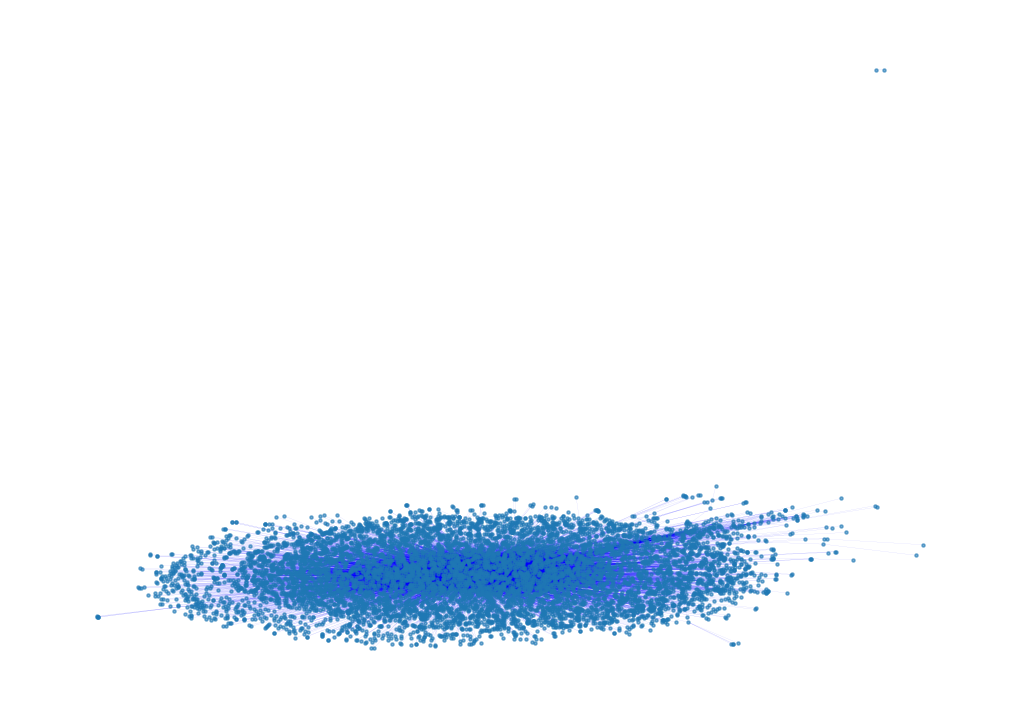

In [ ]:
plt.figure(figsize=(10, 7))
nx.draw(gx, node_size=5, width=0.05, edge_color='blue', alpha=0.6, with_labels=False)
plt.show()

In [ ]:
print("Statistics on class imbalance")
classes, counts = np.unique(torch.concatenate([data.train_y, data.test_y]),return_counts=True)
display(pd.DataFrame({'classes': classes, 'counts': counts}))

print("Statistics on node degree")
degrees = [gx.degree(node) for node in gx.nodes()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))

print("Diameter of the graph")
print(max([max(j.values()) for (i,j) in nx.shortest_path_length(gx)]))

Statistics on class imbalance


,classes,counts
0,0,28
1,1,60
2,2,15
3,3,73


Statistics on node degree


,count,mean,std,min,25%,50%,75%,max
0,8285.0,5.59,25.42,1.0,1.0,1.0,4.0,1246.0


Diameter of the graph
8


### 1.1.2 Random baseline

In [ ]:
# Random predictions as baseline
DATA_PERTURB_SEEDS = [123, 345, 567]
accuracies = []

for seed in DATA_PERTURB_SEEDS:

    set_seed(seed)
    classes = np.unique(data.train_y.numpy())
    predictions = random.choices(classes, k=len(data.test_y.numpy()))
    print(f'Accuracy for seed {seed}: {accuracy_score(data.test_y, predictions):.4f}')
    accuracies.append(accuracy_score(data.test_y, predictions))

print(f'Average accuracy: {np.mean(accuracies):.4f}')
print(f'Std accuracy: {np.std(accuracies):.4f}')

Accuracy for seed 123: 0.1944
Accuracy for seed 345: 0.1944
Accuracy for seed 567: 0.2222
Average accuracy: 0.2037
Std accuracy: 0.0131


### 1.1.3 Feature baseline

In [ ]:
# Random Foresst with node degrees as features
features = np.array([gx.degree(node) for node in gx.nodes()]).reshape(-1,1)
X_train = features[data.train_idx]
X_test = features[data.test_idx]

DATA_PERTURB_SEEDS = [123, 345, 567]
accuracies = []

for seed in DATA_PERTURB_SEEDS:

    set_seed(seed)
    clf = RandomForestClassifier(random_state=seed)
    clf.fit(X_train, data.train_y)
    predictions = clf.predict(X_test)
    print(f'Accuracy for seed {seed}: {accuracy_score(data.test_y, predictions):.4f}')
    accuracies.append(accuracy_score(data.test_y, predictions))

print(f'Average accuracy: {np.mean(accuracies):.4f}')
print(f'Std accuracy: {np.std(accuracies):.4f}')

Accuracy for seed 123: 0.5556
Accuracy for seed 345: 0.4722
Accuracy for seed 567: 0.5278
Average accuracy: 0.5185
Std accuracy: 0.0346


### 1.1.4 GNN

In [ ]:
class RGCN(torch.nn.Module):
    def __init__(self, num_relations, num_classes, num_layers=2, num_hidden=16):
        super(RGCN, self).__init__()
        self.num_layers = num_layers
        self.num_hidden = num_hidden

        for i in range(num_layers):
            if i == 0:
                self.add_module(f'conv{i}', RGCNConv(data.num_nodes, self.num_hidden, num_relations))
            elif i == num_layers - 1:
                self.add_module(f'conv{i}', RGCNConv(self.num_hidden, num_classes, num_relations))
            else:
                self.add_module(f'conv{i}', RGCNConv(self.num_hidden, self.num_hidden, num_relations))

    def forward(self, edge_index, edge_type, return_all_layers=False):
        layer_outputs = []

        for i in range(self.num_layers):
            if i == 0:
                x = self._modules[f'conv{i}'](None, edge_index, edge_type)
            else:
                x = self._modules[f'conv{i}'](x, edge_index, edge_type)
            if return_all_layers:
                layer_outputs.append(x)
            if i != self.num_layers - 1:
                x = F.relu(x)

        if return_all_layers:
            return layer_outputs
        else:
            return F.log_softmax(x, dim=1)

In [ ]:
def train(model, optimizer, data, loss_fn):
    model.train()

    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type)
    loss = loss_fn(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()

    correct = out[data.train_idx].argmax(dim=1).eq(data.train_y).sum().item()
    train_acc = correct / data.train_idx.shape[0]

    return loss.item(), train_acc

def test(model, data, loss_fn, with_dirchlet=False):
    model.eval()

    with torch.no_grad():
        out = model(data.edge_index, data.edge_type)
        loss = loss_fn(out[data.test_idx], data.test_y)
        correct = out[data.test_idx].argmax(dim=1).eq(data.test_y).sum().item()
        test_acc = correct / data.test_idx.shape[0]
        if with_dirchlet:
            dir_energy = dirichlet_energy(out, data.edge_index)
            return loss.item(), test_acc, dir_energy
        else:
            return loss.item(), test_acc

def validate(model, data, loss_fn):
    model.eval()

    with torch.no_grad():
        out = model(data.edge_index, data.edge_type)
        loss = loss_fn(out[data.val_idx], data.val_y)
        correct = out[data.val_idx].argmax(dim=1).eq(data.val_y).sum().item()
        val_acc = correct / data.val_idx.shape[0]

        return loss.item(), val_acc



In [ ]:
data = dataset[0]
NUM_RELATIONS = data.num_edge_types
NUM_CLASSES = dataset.num_classes

lr = 0.002
weight_decay = 0.001
EPOCHS = 25
width = 8
depth = 2

results = {}

for seed in DATA_PERTURB_SEEDS:

    set_seed(seed)

    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    # Perform a stratified split
    train_labels = data.train_y.cpu().numpy()
    train_indices, val_indices = train_test_split(np.arange(len(train_labels)), test_size=0.2, stratify=train_labels, random_state=seed)

    train_data = data.train_idx[train_indices]
    val_data = data.train_idx[val_indices]

    train_labels = data.train_y[train_indices]
    val_labels = data.train_y[val_indices]

    # Update data structure
    data.train_idx = train_data
    data.val_idx = val_data
    data.train_y = train_labels
    data.val_y = val_labels

    best_val_loss = np.inf
    best_val_acc = 0
    best_val_epoch = 0
    best_state_dict = None
    best_dirchlet_energy = np.inf


    for epoch in range(EPOCHS):

        epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn)
        epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_loss = epoch_val_loss
            best_val_acc = epoch_val_acc
            best_state_dict = model.state_dict()

    # Test with best model
    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.load_state_dict(best_state_dict)
    test_loss, test_acc = test(model, data, loss_fn)


    key = f"{seed}"

    results[key] = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
    }


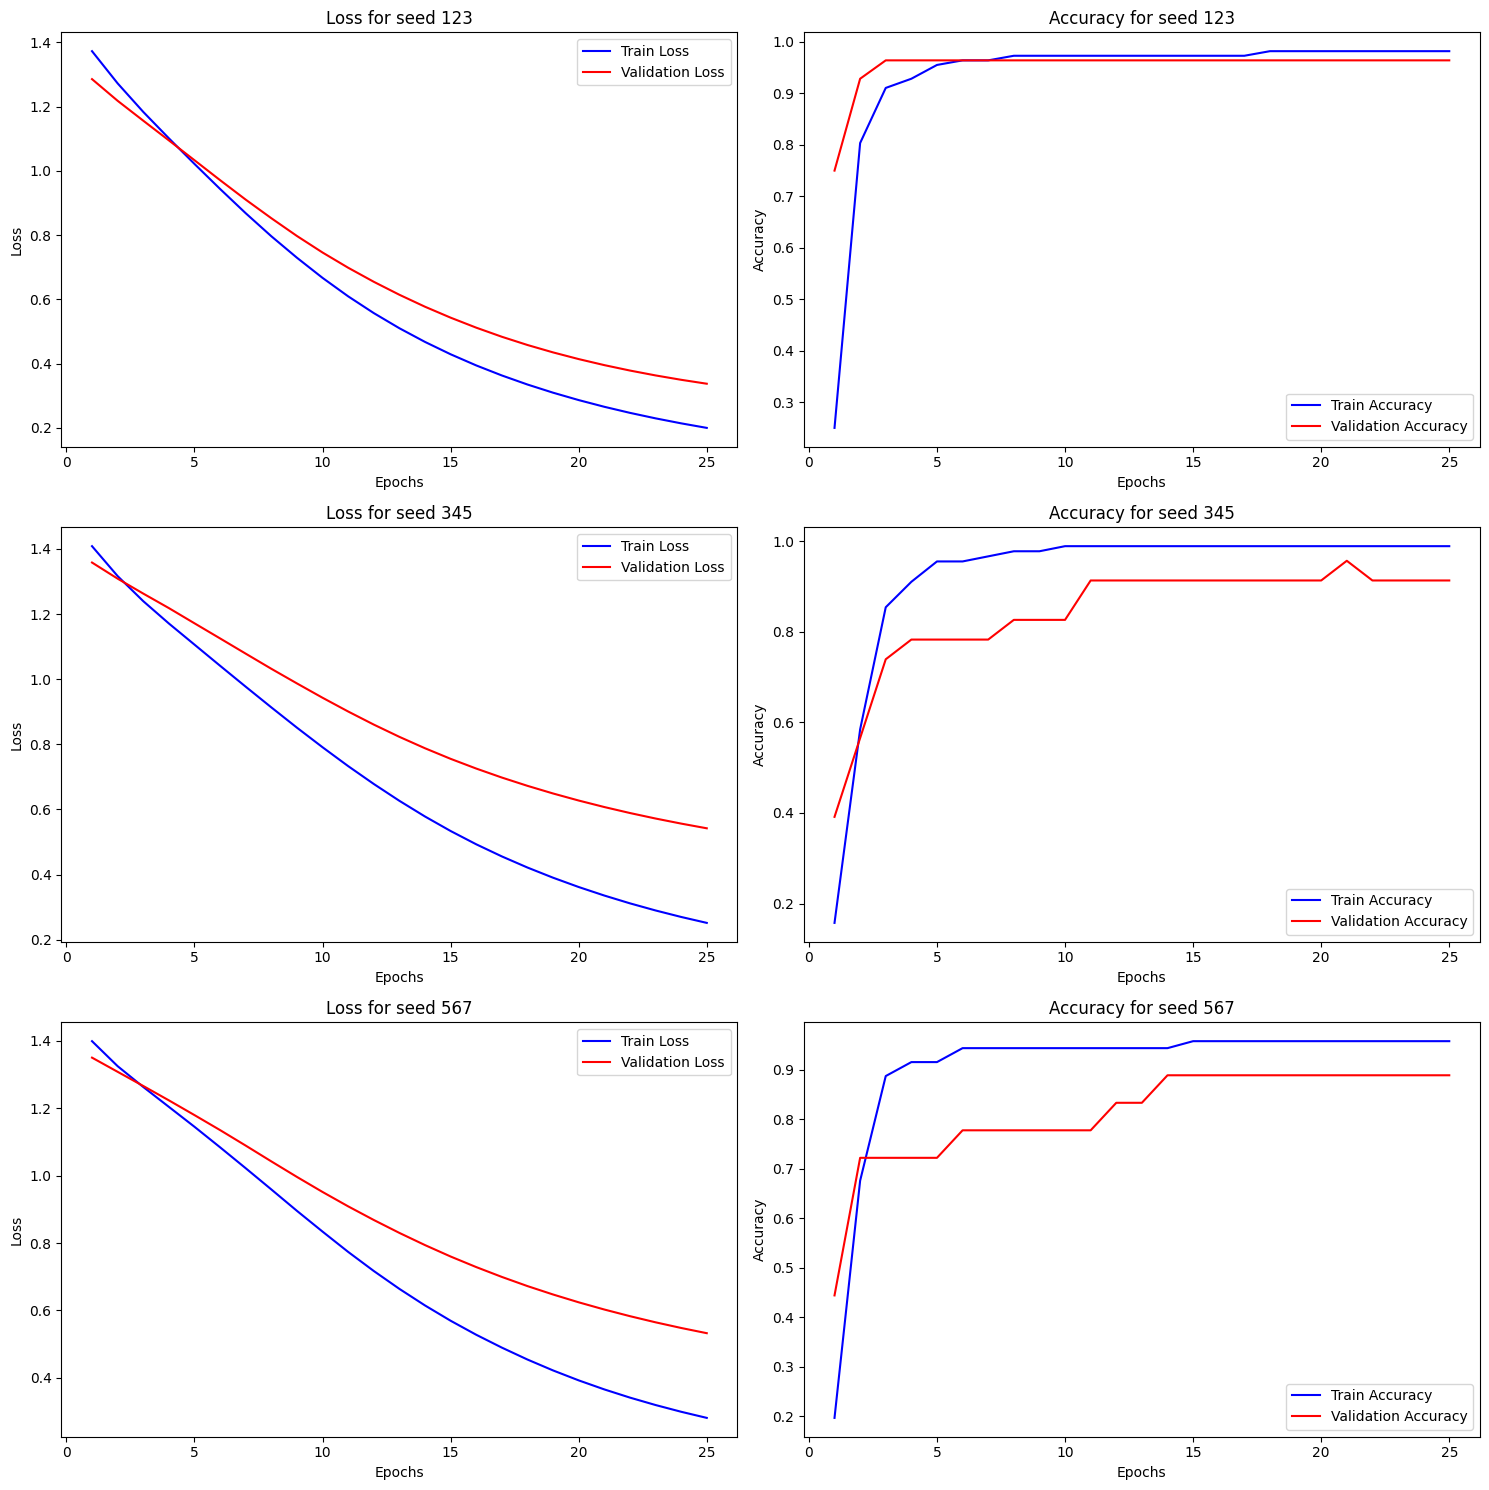

In [ ]:
plot_results(results)

In [ ]:
test_accuracies = [results[f"{seed}"]["test_accuracy"] for seed in DATA_PERTURB_SEEDS]
print(f'Test accuracies: {np.round(test_accuracies, 4)}')
print(f'Average test accuracy: {np.mean(test_accuracies):.4f}')
print(f'Std test accuracy: {np.std(test_accuracies):.4f}')

Test accuracies: [0.9444 0.8889 0.9444]
Average test accuracy: 0.9259
Std test accuracy: 0.0262


### 1.1.5 Oversmoothing


In [ ]:
#
def dirichlet_energy(X, edge_index):
    """
    Compute the Dirichlet energy of a graph.
    We can use the graph Laplacian to compute the Dirichlet energy of a graph.
    See an example derivation here: https://math.stackexchange.com/questions/3581263/trying-to-understand-relationship-between-dirichlet-energy-of-graphs-and-discret

    Parameters
    ----------
    X : torch.Tensor
        The node features.
    edge_index : torch.Tensor
        The edge indices.

    Returns
    -------
    torch.Tensor
        The Dirichlet energy.
    """
    num_nodes = X.size(0)
    # Compute the adjacency matrix.
    A = torch_geometric.utils.to_dense_adj(edge_index)
    # Compute the degree matrix.
    D = torch.diag(torch.sum(A, axis=1))
    # Compute the Laplacian matrix.
    L = D - A
    # Compute the Dirichlet energy.
    d_e = torch.matmul(torch.matmul(X.T, L), X).squeeze(0)
    d_e = torch.trace(d_e) / num_nodes  # aggregate the feature space

    return d_e

In [ ]:
def plot_oversmoothing_results(results, best_results, varying='depth'):

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Validation Loss Per Epoch for Each Model
    for key in results:
        axs[0, 0].plot(np.log(results[key]['val_loss']), label=f'{varying.capitalize()} {key}')
    axs[0, 0].set_title(f'Validation Loss Per Epoch for Each Model by {varying.capitalize()}')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Validation Loss (log)')
    axs[0, 0].legend()

    # Plot 2: Validation Accuracy Over Time for Each Model
    for key in results:
        axs[0, 1].plot(results[key]['val_accuracy'], label=f'{varying.capitalize()} {key}')
    axs[0, 1].set_title(f'Validation Accuracy Over Time for Each Model by {varying.capitalize()}')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Validation Accuracy')
    axs[0, 1].legend()

    # Plot 3: Bar Plot - Depth/Width vs Test Accuracy
    keys = list(best_results.keys())
    test_accs = [best_results[key]['test_acc'] for key in keys]
    axs[1, 0].bar(keys, test_accs, color='skyblue')
    axs[1, 0].set_title(f'Test Accuracy by {varying.capitalize()}')
    axs[1, 0].set_xlabel(f'{varying.capitalize()}')
    axs[1, 0].set_ylabel('Test Accuracy')

    # Plot 4: Bar Plot - Deoth/Width vs Test Loss
    keys = list(best_results.keys())
    test_losses = [best_results[key]['test_loss'] for key in keys]
    axs[1, 1].bar(keys, np.log10(test_losses), color='skyblue')
    axs[1, 1].set_title(f'Test Loss by {varying.capitalize()}')
    axs[1, 1].set_xlabel(f'{varying.capitalize()}')
    axs[1, 1].set_ylabel('Test Loss (log10)')

    plt.tight_layout()
    plt.show()

#### Oversmoothing with different depth

In [ ]:
data = dataset[0]
NUM_RELATIONS = data.num_edge_types
NUM_CLASSES = dataset.num_classes

lr = 0.003
weight_decay = 0.001
EPOCHS = 20
layers = [2, 6, 10, 20, 25]
width = 16

test_depth_results = {}
depth_results = {}
seed = 42

set_seed(seed)

for depth in layers:

    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    best_val_loss = np.inf
    best_val_acc = 0
    best_val_epoch = 0
    best_state_dict = None
    best_dirchlet_energy = np.inf

    # Perform stratified split
    train_labels = data.train_y.cpu().numpy()
    train_indices, val_indices = train_test_split(np.arange(len(train_labels)), test_size=0.2, stratify=train_labels, random_state=seed)

    train_data = data.train_idx[train_indices]
    val_data = data.train_idx[val_indices]

    train_labels = data.train_y[train_indices]
    val_labels = data.train_y[val_indices]

    # Update data structure
    data.train_idx = train_data
    data.val_idx = val_data
    data.train_y = train_labels
    data.val_y = val_labels

    for epoch in range(EPOCHS):

            epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn)
            epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn)

            # Log metrics
            train_loss.append(epoch_train_loss)
            train_accuracy.append(epoch_train_acc)
            val_loss.append(epoch_val_loss)
            val_accuracy.append(epoch_val_acc)

            if epoch_val_acc > best_val_acc:
                best_val_loss = epoch_val_loss
                best_val_acc = epoch_val_acc
                best_state_dict = model.state_dict()

    key = f"{depth}"

    # Test with best model
    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.load_state_dict(best_state_dict)
    test_loss, test_acc = test(model, data, loss_fn)


    depth_results[key] = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    }

    test_depth_results[key] = {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_state_dict": best_state_dict,
    }

    print(f"Depth: {depth}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Depth: 2, Test Accuracy: 0.9167, Test Loss: 0.3230
Depth: 6, Test Accuracy: 0.9444, Test Loss: 0.3242
Depth: 10, Test Accuracy: 0.9444, Test Loss: 0.8374
Depth: 20, Test Accuracy: 0.5833, Test Loss: 33.1595
Depth: 25, Test Accuracy: 0.6944, Test Loss: 1009.4617


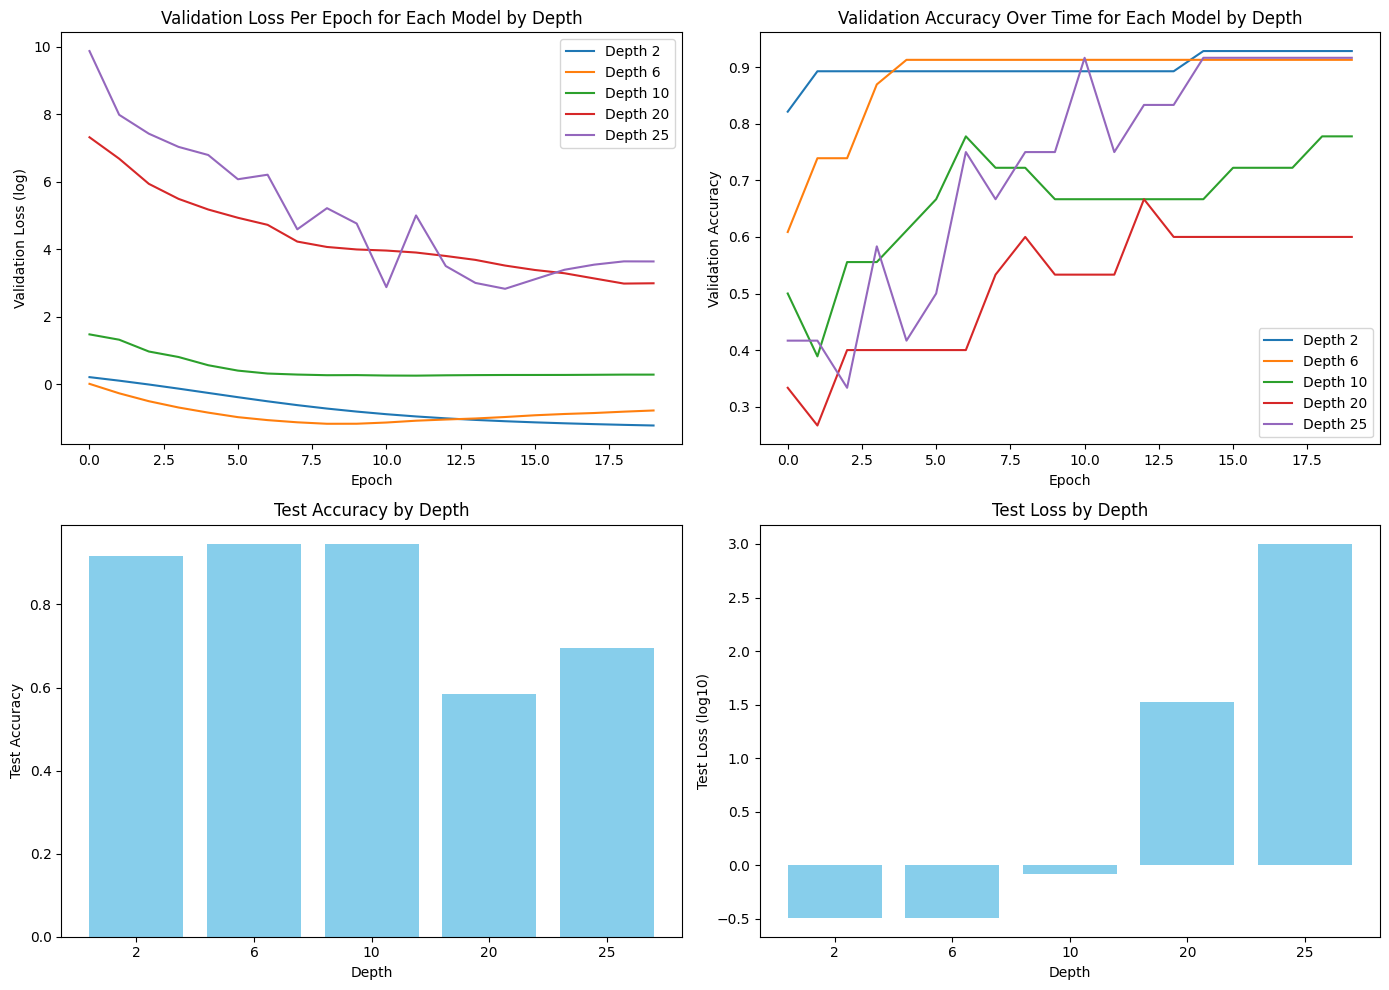

In [ ]:
plot_oversmoothing_results(depth_results, test_depth_results, varying='depth')

#### Oversmoothing with different width

In [ ]:
data = dataset[0]

lr = 0.003
weight_decay = 0.0005
EPOCHS = 30
num_hidden_units = [8, 16, 32, 64, 128]
depth = 4

test_width_results = {}
width_results = {}

set_seed(42)

for width in num_hidden_units:

    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    best_val_loss = np.inf
    best_val_acc = 0
    best_val_epoch = 0
    best_state_dict = None
    best_dirchlet_energy = np.inf

    # Perform stratified split
    train_labels = data.train_y.cpu().numpy()
    train_indices, val_indices = train_test_split(np.arange(len(train_labels)), test_size=0.2, stratify=train_labels, random_state=seed)

    train_data = data.train_idx[train_indices]
    val_data = data.train_idx[val_indices]

    train_labels = data.train_y[train_indices]
    val_labels = data.train_y[val_indices]

    # Update data structure
    data.train_idx = train_data
    data.val_idx = val_data
    data.train_y = train_labels
    data.val_y = val_labels

    for epoch in range(EPOCHS):

            epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn)
            epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn)

            # Log metrics
            train_loss.append(epoch_train_loss)
            train_accuracy.append(epoch_train_acc)
            val_loss.append(epoch_val_loss)
            val_accuracy.append(epoch_val_acc)

            if epoch_val_acc > best_val_acc:
                best_val_loss = epoch_val_loss
                best_val_acc = epoch_val_acc
                best_state_dict = model.state_dict()

    key = f"{width}"

    # Test with best model
    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.load_state_dict(best_state_dict)
    test_loss, test_acc = test(model, data, loss_fn)


    width_results[key] = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    }

    test_width_results[key] = {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_state_dict": best_state_dict
    }

    print(f'Width: {width}, Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

Width: 8, Test Accuracy: 0.9167, Test Loss: 0.2917
Width: 16, Test Accuracy: 0.9167, Test Loss: 0.2647
Width: 32, Test Accuracy: 0.8889, Test Loss: 0.7429
Width: 64, Test Accuracy: 0.9444, Test Loss: 0.7595
Width: 128, Test Accuracy: 0.8611, Test Loss: 0.6881


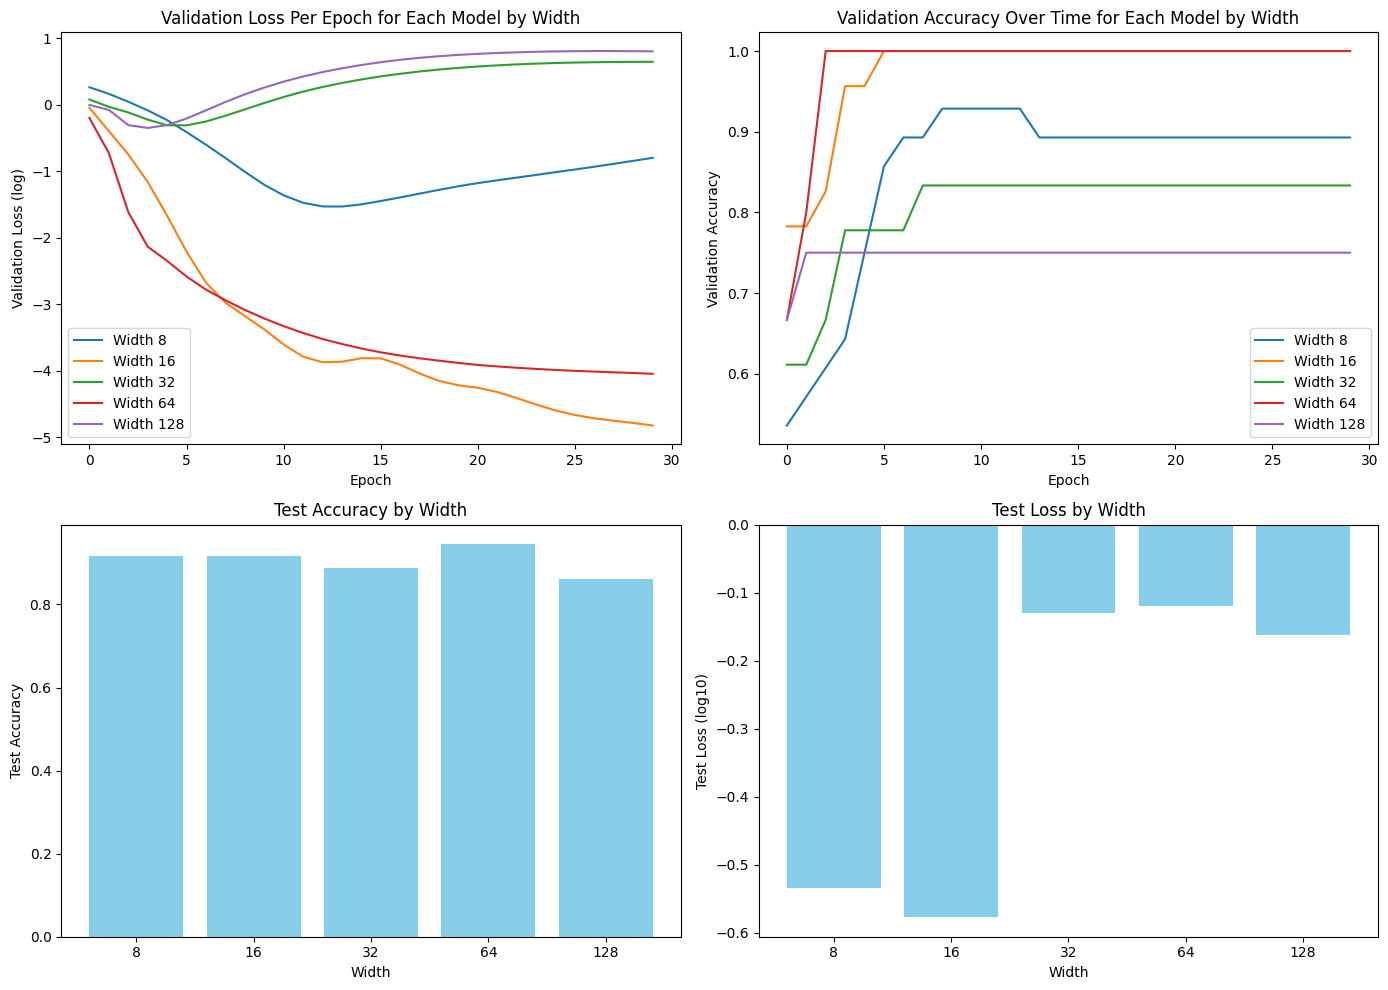

In [ ]:
plot_oversmoothing_results(width_results, test_width_results, varying='width')

#### Showing Oversmoothing for deep model with dirichlet energy

In [ ]:
# get model dictionary of deepest model
deepest_depth = 25
deepest_depth_dict = test_depth_results[str(deepest_depth)]

# load pretrained model with dictionary
model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=deepest_depth, num_hidden=16)
model.load_state_dict(deepest_depth_dict['test_state_dict'])

# Calculate Dirichlet energy for each layer's output
model.eval()
layer_dirichlet_energies = []
layer_outputs = model(data.edge_index, data.edge_type, return_all_layers=True)
out = layer_outputs[-1]
with torch.no_grad():
    for layer_output in layer_outputs:
        dir_energy = dirichlet_energy(layer_output, data.edge_index)
        layer_dirichlet_energies.append(dir_energy)

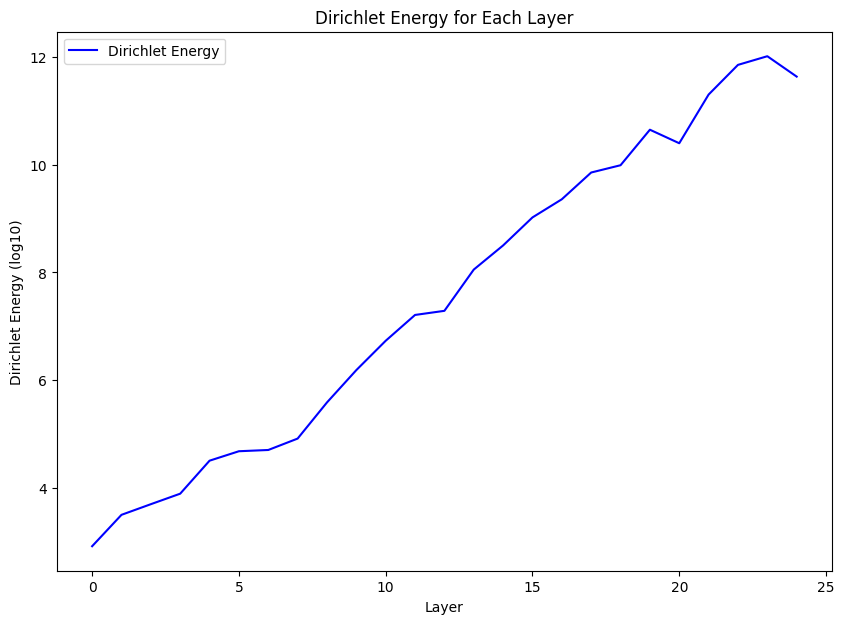

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.log10(layer_dirichlet_energies), 'b-', label='Dirichlet Energy')
plt.xlabel('Layer')
plt.ylabel('Dirichlet Energy (log10)')
plt.title('Dirichlet Energy for Each Layer')
plt.legend()
plt.show()

#### Reducting in oversmoothing with pair-norm

In [ ]:
class PairNorm(torch.nn.Module):
    def __init__(self, scale=1):
        super(PairNorm, self).__init__()
        self.scale = scale

    def forward(self, x):
        mean = x.mean(dim=0, keepdim=True)
        var = x.var(dim=0, keepdim=True)
        std = torch.sqrt(var)
        return self.scale * (x - mean) / (std + 1e-6)


class RGCN_Pairnom(torch.nn.Module):
    def __init__(self, num_relations, num_classes, num_layers=2, num_hidden=16, scale=1):
        super(RGCN_Pairnom, self).__init__()
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.scale = scale
        self.pairnorm = PairNorm(scale = self.scale)

        for i in range(num_layers):
            if i == 0:
                self.add_module(f'conv{i}', RGCNConv(data.num_nodes, self.num_hidden, num_relations))
            elif i == num_layers - 1:
                self.add_module(f'conv{i}', RGCNConv(self.num_hidden, num_classes, num_relations))
            else:
                self.add_module(f'conv{i}', RGCNConv(self.num_hidden, self.num_hidden, num_relations))

    def forward(self, edge_index, edge_type, return_all_layers=False):
        layer_outputs = []

        for i in range(self.num_layers):
            if i == 0:
                x = self._modules[f'conv{i}'](None, edge_index, edge_type)
            else:
                x = self._modules[f'conv{i}'](x, edge_index, edge_type)
            if return_all_layers:
                layer_outputs.append(x)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = self.pairnorm(x)

        if return_all_layers:
            return layer_outputs
        else:
            return F.log_softmax(x, dim=1)


Epoch 1: train loss 4.9591, train accuracy 0.3036, val loss 3.3921, val accuracy 0.5357
Epoch 2: train loss 1.9551, train accuracy 0.6250, val loss 4.4824, val accuracy 0.3929
Epoch 3: train loss 3.7468, train accuracy 0.3839, val loss 3.2322, val accuracy 0.4286
Epoch 4: train loss 2.2909, train accuracy 0.4821, val loss 2.5459, val accuracy 0.6429
Epoch 5: train loss 1.2888, train accuracy 0.7321, val loss 2.6096, val accuracy 0.4286
Epoch 6: train loss 1.9028, train accuracy 0.5000, val loss 1.2428, val accuracy 0.6429
Epoch 7: train loss 1.0561, train accuracy 0.7679, val loss 1.0107, val accuracy 0.7143
Epoch 8: train loss 0.8673, train accuracy 0.6786, val loss 0.8602, val accuracy 0.7857
Epoch 9: train loss 0.5673, train accuracy 0.8482, val loss 0.9906, val accuracy 0.7857
Epoch 10: train loss 0.3895, train accuracy 0.8661, val loss 0.9915, val accuracy 0.7857
Epoch 11: train loss 0.3260, train accuracy 0.8661, val loss 0.9900, val accuracy 0.7857
Epoch 12: train loss 0.2887, t

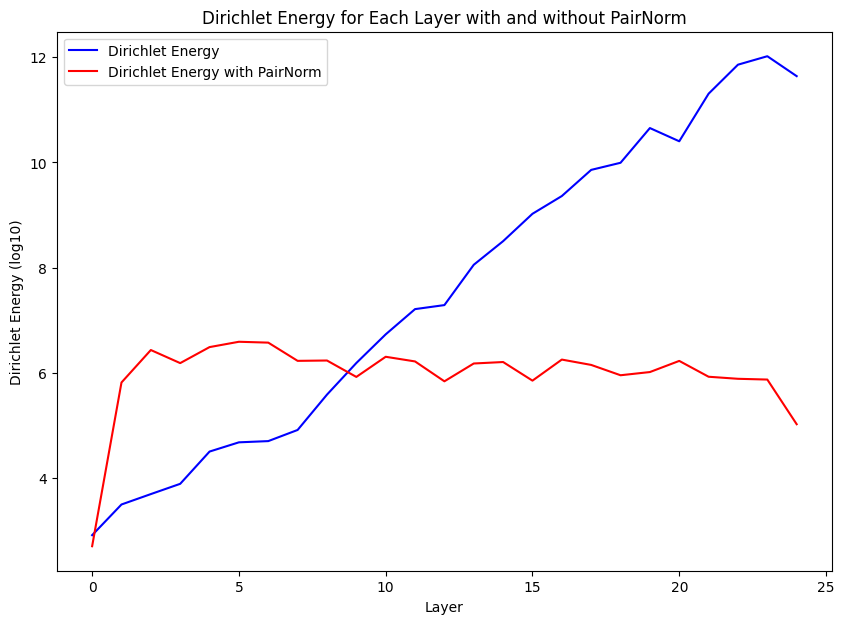

In [ ]:
data = dataset[0]

lr = 0.003
weight_decay = 0.0005
EPOCHS = 20
set_seed(42)


model = RGCN_Pairnom(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=25, num_hidden=16, scale=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

best_val_loss = np.inf
best_val_acc = 0
best_val_epoch = 0
best_state_dict = None
best_dirchlet_energy = np.inf

# Perform stratified split
train_labels = data.train_y.cpu().numpy()
train_indices, val_indices = train_test_split(np.arange(len(train_labels)), test_size=0.2, stratify=train_labels, random_state=seed)

train_data = data.train_idx[train_indices]
val_data = data.train_idx[val_indices]

train_labels = data.train_y[train_indices]
val_labels = data.train_y[val_indices]

# Update data structure
data.train_idx = train_data
data.val_idx = val_data
data.train_y = train_labels
data.val_y = val_labels

for epoch in range(EPOCHS):

    epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn)
    epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn)

    # Log metrics
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    if epoch_val_acc > best_val_acc:
        best_val_loss = epoch_val_loss
        best_val_acc = epoch_val_acc
        best_state_dict = model.state_dict()

    print(f'Epoch {epoch + 1}: train loss {epoch_train_loss:.4f}, train accuracy {epoch_train_acc:.4f}, val loss {epoch_val_loss:.4f}, val accuracy {epoch_val_acc:.4f}')


#  test model wtih best state dict
model = RGCN_Pairnom(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=25, num_hidden=16, scale=1)
model.load_state_dict(best_state_dict)

layer_dirichlet_energies_pairnorm = []
layer_outputs = model(data.edge_index, data.edge_type, return_all_layers=True)
out = layer_outputs[-1]
with torch.no_grad():
    for layer_output in layer_outputs:
        dir_energy = dirichlet_energy(layer_output, data.edge_index)
        layer_dirichlet_energies_pairnorm.append(dir_energy)

# plot dirchlet energies pairnorm vs no pairnorm
plt.figure(figsize=(10, 7))
plt.plot(np.log10(layer_dirichlet_energies), 'b-', label='Dirichlet Energy')
plt.plot(np.log10(layer_dirichlet_energies_pairnorm), 'r-', label='Dirichlet Energy with PairNorm')
plt.xlabel('Layer')
plt.ylabel('Dirichlet Energy (log10)')
plt.title('Dirichlet Energy for Each Layer with and without PairNorm')
plt.legend()
plt.show()

## 1.2 AM Dataset

### 1.2.1 Data exploration and baselines

In [ ]:
dataset = Entities(root='data/Entities', name='AM')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting data/Entities/am.tgz
Processing...


Number of graphs: 1
Number of features: 0
Number of classes: 11


Done!


In [ ]:
data = dataset[0]
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

Number of nodes: 1666764
Number of edges: 11976642


In [ ]:
# AM graphs too big to process them in a full-batch fashion.
# Since our model does only make use of a rather small receptive field, we
# filter the graph to only contain the nodes that are at most 1-hop neighbors
# away from any training/test node. --> idea from https://github.com/pyg-team/pytorch_geometric/blob/master/examples/rgcn.py

node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 1, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]

del dataset
gc.collect()

39679474

In [ ]:
gx = to_networkx(data, to_undirected=True)
print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features for each node: {data.num_node_features}')
print(f'Number of edge types: {data.num_edge_types}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 190378], edge_type=[190378], train_idx=[802], train_y=[802], test_idx=[198], test_y=[198], num_nodes=18176)
Number of nodes: 18176
Number of edges: 190378
Number of features for each node: 0
Number of edge types: 250
Contains isolated nodes: False
Contains self-loops: True
Is undirected: True


In [ ]:
print("Statistics on class imbalance")
classes, counts = np.unique(torch.concatenate([data.train_y, data.test_y]),return_counts=True)
display(pd.DataFrame({'classes': classes, 'counts': counts}))

print("Statistics on node degree")
degrees = [gx.degree(node) for node in gx.nodes()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))

Statistics on class imbalance


,classes,counts
0,0,50
1,1,347
2,2,55
3,3,56
4,4,81
5,5,116
6,6,42
7,7,25
8,8,127
9,9,15


Statistics on node degree


,count,mean,std,min,25%,50%,75%,max
0,18176.0,7.97,46.81,1.0,1.0,1.0,5.0,3793.0


In [ ]:
# Random predictions as baseline
DATA_PERTURB_SEEDS = [123, 345, 567]
accuracies = []

for seed in DATA_PERTURB_SEEDS:

    set_seed(seed)
    classes = np.unique(data.train_y.numpy())
    predictions = random.choices(classes, k=len(data.test_y.numpy()))
    print(f'Accuracy for seed {seed}: {accuracy_score(data.test_y, predictions):.4f}')
    accuracies.append(accuracy_score(data.test_y, predictions))

print(f'Average accuracy: {np.mean(accuracies):.4f}')
print(f'Std accuracy: {np.std(accuracies):.4f}')

Accuracy for seed 123: 0.0859
Accuracy for seed 345: 0.1263
Accuracy for seed 567: 0.0758
Average accuracy: 0.0960
Std accuracy: 0.0218


In [ ]:
# Random Forest with node degrees as features
features = np.array([gx.degree(node) for node in gx.nodes()]).reshape(-1,1)
X_train = features[data.train_idx]
X_test = features[data.test_idx]

DATA_PERTURB_SEEDS = [123, 345, 567]
accuracies = []

for seed in DATA_PERTURB_SEEDS:

    set_seed(seed)
    clf = RandomForestClassifier(random_state=seed)
    clf.fit(X_train, data.train_y)
    predictions = clf.predict(X_test)
    print(f'Accuracy for seed {seed}: {accuracy_score(data.test_y, predictions):.4f}')
    accuracies.append(accuracy_score(data.test_y, predictions))

print(f'Average accuracy: {np.mean(accuracies):.4f}')
print(f'Std accuracy: {np.std(accuracies):.4f}')

Accuracy for seed 123: 0.3535
Accuracy for seed 345: 0.3586
Accuracy for seed 567: 0.3535
Average accuracy: 0.3552
Std accuracy: 0.0024


### 1.2.2 Is bigger = better?

In [ ]:
# Perform a stratified split
seed = 42
set_seed(seed)

train_labels = data.train_y.cpu().numpy()
train_indices, val_indices = train_test_split(np.arange(len(train_labels)), test_size=0.2, stratify=train_labels, random_state=seed)

train_data = data.train_idx[train_indices]
val_data = data.train_idx[val_indices]

train_labels = data.train_y[train_indices]
val_labels = data.train_y[val_indices]

# Update data structure
data.train_idx = train_data
data.val_idx = val_data
data.train_y = train_labels
data.val_y = val_labels


In [ ]:
class RGCN(torch.nn.Module):
    def __init__(self, num_relations, num_classes, num_layers=2, num_hidden=16):
        super(RGCN, self).__init__()
        self.num_layers = num_layers
        self.num_hidden = num_hidden

        for i in range(num_layers):
            if i == 0:
                self.add_module(f'conv{i}', RGCNConv(data.num_nodes, self.num_hidden, num_relations))
            elif i == num_layers - 1:
                self.add_module(f'conv{i}', RGCNConv(self.num_hidden, num_classes, num_relations))
            else:
                self.add_module(f'conv{i}', RGCNConv(self.num_hidden, self.num_hidden, num_relations))


    def forward(self, edge_index, edge_type, return_all_layers=False):
        layer_outputs = []

        for i in range(self.num_layers):
            if i == 0:
                x = self._modules[f'conv{i}'](None, edge_index, edge_type)
            else:
                x = self._modules[f'conv{i}'](x, edge_index, edge_type)
            if return_all_layers:
                layer_outputs.append(x)
            if i != self.num_layers - 1:
                x = F.relu(x)

        if return_all_layers:
            return layer_outputs
        else:
            return F.log_softmax(x, dim=1)

In [ ]:
def train(model, optimizer, data, loss_fn, device):
    model.train()

    data = data.to(device)

    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type)
    loss = loss_fn(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()

    correct = out[data.train_idx].argmax(dim=1).eq(data.train_y).sum().item()
    train_acc = correct / data.train_idx.shape[0]

    return loss.item(), train_acc

def test(model, data, loss_fn, device, with_dirchlet=False):
    model.eval()

    data = data.to(device)

    with torch.no_grad():
        out = model(data.edge_index, data.edge_type)
        loss = loss_fn(out[data.test_idx], data.test_y)
        correct = out[data.test_idx].argmax(dim=1).eq(data.test_y).sum().item()
        test_acc = correct / data.test_idx.shape[0]
        if with_dirchlet:
            dir_energy = dirichlet_energy(out, data.edge_index)
            return loss.item(), test_acc, dir_energy
        else:
            return loss.item(), test_acc

def validate(model, data, loss_fn, device):
    model.eval()

    data = data.to(device)

    with torch.no_grad():
        out = model(data.edge_index, data.edge_type)
        loss = loss_fn(out[data.val_idx], data.val_y)
        correct = out[data.val_idx].argmax(dim=1).eq(data.val_y).sum().item()
        val_acc = correct / data.val_idx.shape[0]

        return loss.item(), val_acc


#### Small model: 2 layers, Width 16

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
NUM_RELATIONS = data.num_edge_types
NUM_CLASSES = len(np.unique(data.train_y.cpu().numpy()))

lr = 0.01
weight_decay = 0.01
EPOCHS = 30
width = 16
depth = 2

results = {}

for seed in DATA_PERTURB_SEEDS:

    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []


    best_val_loss = np.inf
    best_val_acc = 0
    best_val_epoch = 0
    best_state_dict = None
    best_dirchlet_energy = np.inf


    for epoch in range(EPOCHS):

        epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn, device)

        epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn, device)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_loss = epoch_val_loss
            best_val_acc = epoch_val_acc
            best_state_dict = model.state_dict()

        gc.collect()

    # Test with best model
    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.load_state_dict(best_state_dict)
    model.to(device)
    test_loss, test_acc = test(model, data, loss_fn, device)


    key = f"{seed}"

    results[key] = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
    }

    print(f"seed: {seed}, Test loss: {test_loss:.4f}, Test Accuracy {test_acc:.4f}")

    del model, optimizer, loss_fn
    gc.collect()





seed: 123, Test loss: 0.6060, Test Accuracy 0.8586
seed: 345, Test loss: 0.6150, Test Accuracy 0.8535
seed: 567, Test loss: 0.6268, Test Accuracy 0.8434


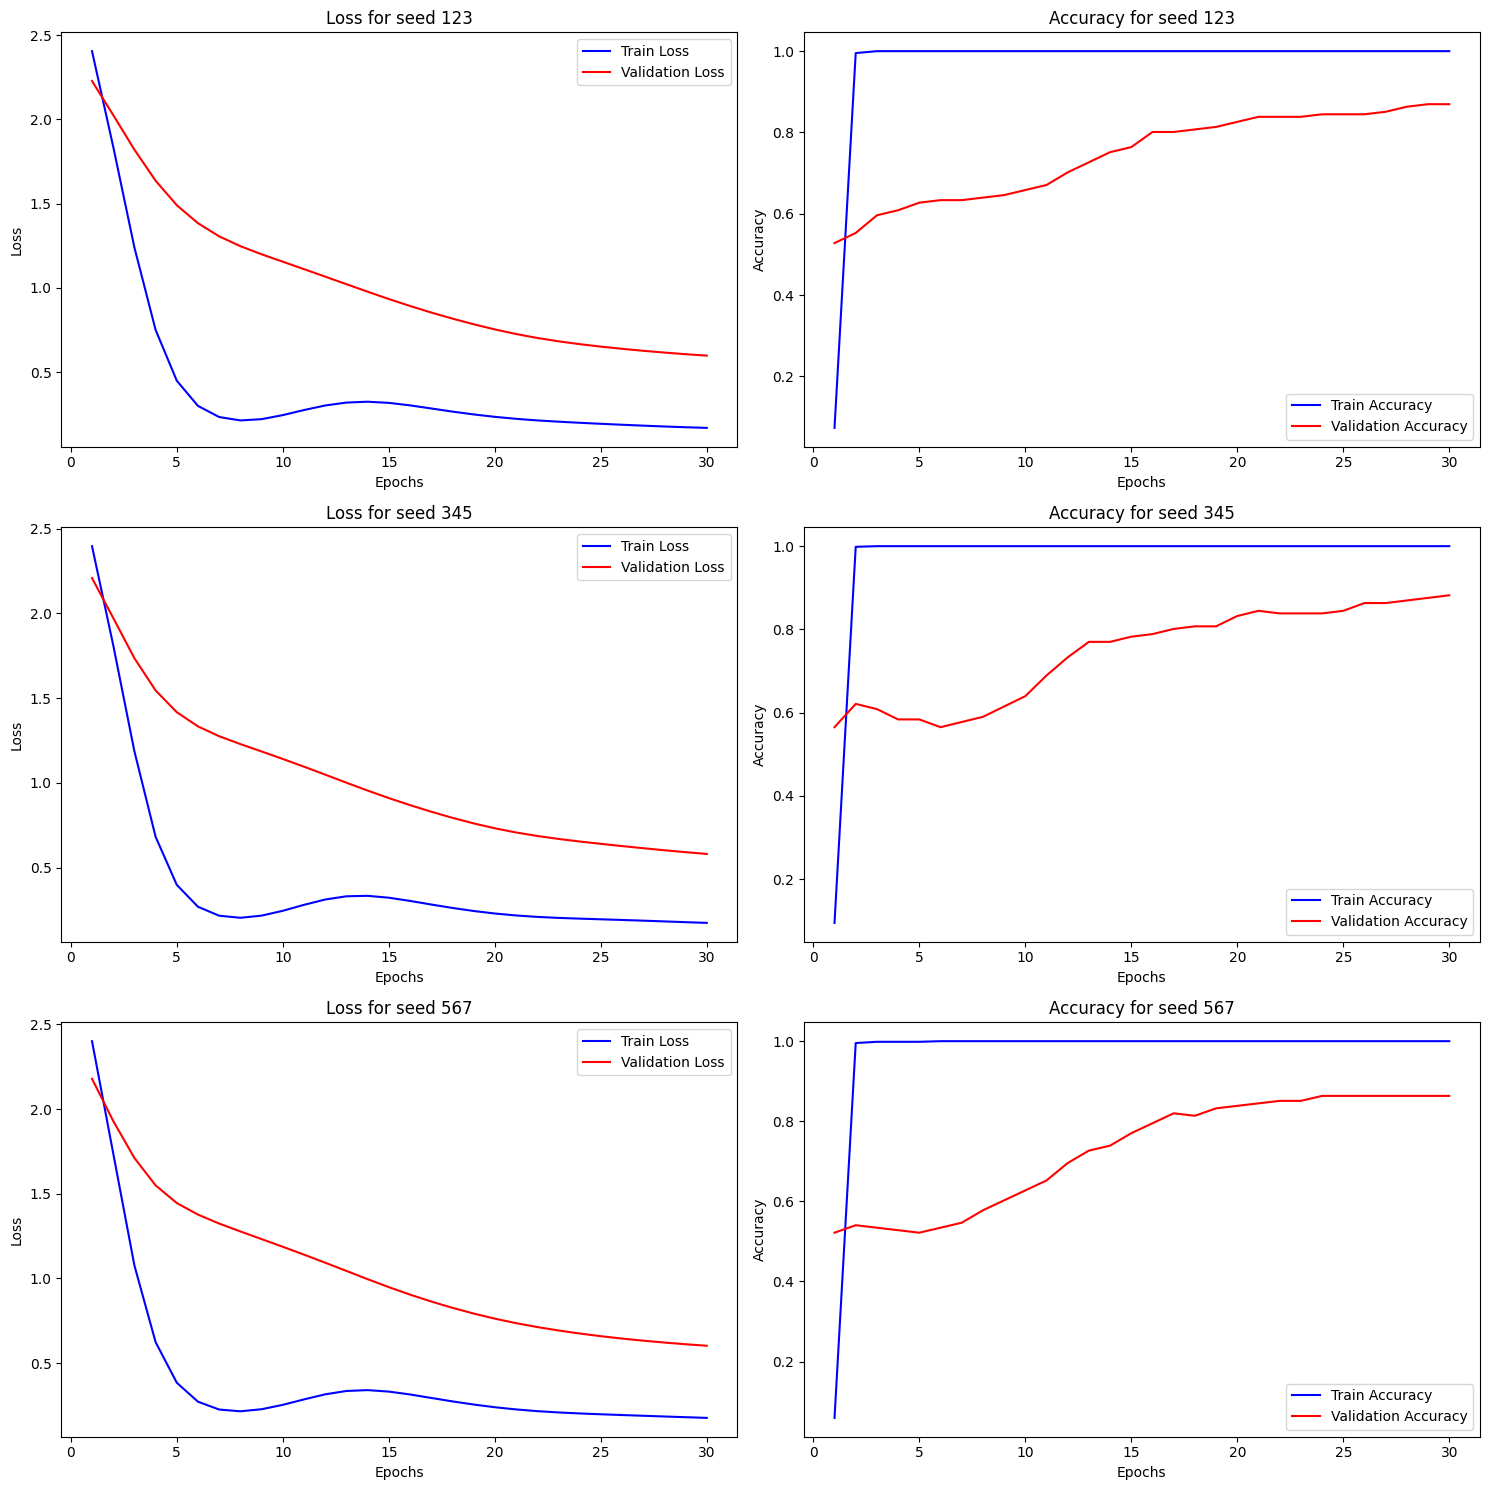

In [ ]:
plot_results(results)

In [ ]:
test_accuracies = [results[f"{seed}"]["test_accuracy"] for seed in DATA_PERTURB_SEEDS]
print(f'Test accuracies: {np.round(test_accuracies, 4)}')
print(f'Average test accuracy: {np.mean(test_accuracies):.4f}')
print(f'Std test accuracy: {np.std(test_accuracies):.4f}')

Test accuracies: [0.8586 0.8535 0.8434]
Average test accuracy: 0.8519
Std test accuracy: 0.0063


#### Large model: 25 layers, Width 16

In [ ]:
NUM_RELATIONS = data.num_edge_types
NUM_CLASSES = len(np.unique(data.train_y.cpu().numpy()))

lr = 0.001
weight_decay = 0.01
EPOCHS = 30
width = 16
depth = 25

results = {}

for seed in DATA_PERTURB_SEEDS:

    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []


    best_val_loss = np.inf
    best_val_acc = 0
    best_val_epoch = 0
    best_state_dict = None
    best_dirchlet_energy = np.inf


    for epoch in range(EPOCHS):

        epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn, device)
        epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn, device)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_loss = epoch_val_loss
            best_val_acc = epoch_val_acc
            best_state_dict = model.state_dict()

        gc.collect()

    # Test with best model
    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.load_state_dict(best_state_dict)
    model.to(device)
    test_loss, test_acc = test(model, data, loss_fn, device)


    key = f"{seed}"

    results[key] = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
    }

    print(f"seed: {seed}, Test loss: {test_loss:.4f}, Test Accuracy {test_acc:.4f}")

    del model, optimizer, loss_fn
    gc.collect()




seed: 123, Test loss: 60.8221, Test Accuracy 0.5303
seed: 345, Test loss: 34.7607, Test Accuracy 0.5404
seed: 567, Test loss: 72.7827, Test Accuracy 0.5404


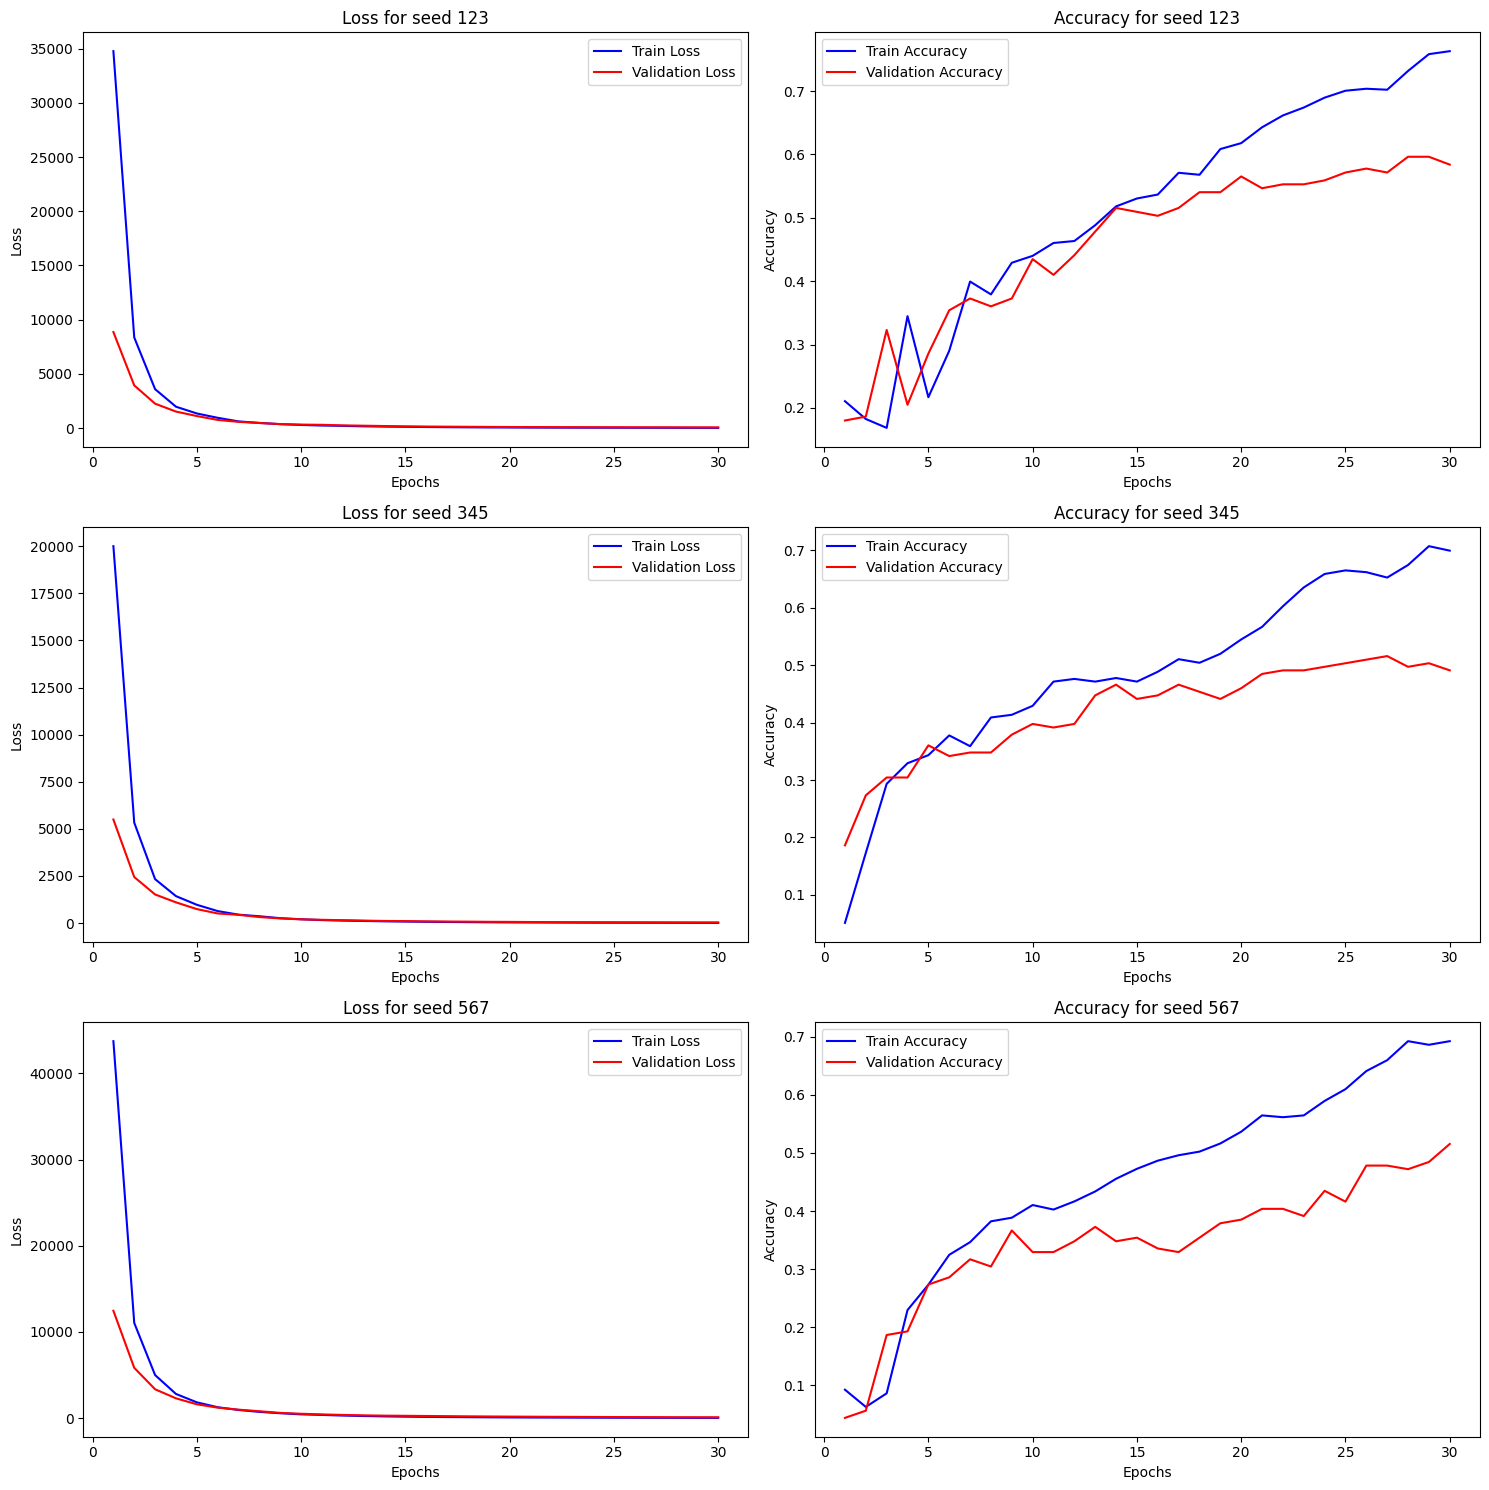

In [ ]:
plot_results(results)

In [ ]:
test_accuracies = [results[f"{seed}"]["test_accuracy"] for seed in DATA_PERTURB_SEEDS]
print(f'Test accuracies: {np.round(test_accuracies, 4)}')
print(f'Average test accuracy: {np.mean(test_accuracies):.4f}')
print(f'Std test accuracy: {np.std(test_accuracies):.4f}')

Test accuracies: [0.5303 0.5404 0.5404]
Average test accuracy: 0.5370
Std test accuracy: 0.0048


### 1.2.3 Better GNN

#### Longer training

In [ ]:
NUM_RELATIONS = data.num_edge_types
NUM_CLASSES = len(np.unique(data.train_y.cpu().numpy()))

lr = 0.01
weight_decay = 0.01
EPOCHS = 100
width = 16
depth = 2

results = {}

for seed in DATA_PERTURB_SEEDS:

    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []


    best_val_loss = np.inf
    best_val_acc = 0
    best_val_epoch = 0
    best_state_dict = None
    best_dirchlet_energy = np.inf


    for epoch in range(EPOCHS):

        epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn, device)

        epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn, device)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_loss = epoch_val_loss
            best_val_acc = epoch_val_acc
            best_state_dict = model.state_dict()

        gc.collect()

    # Test with best model
    model = RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.load_state_dict(best_state_dict)
    model.to(device)
    test_loss, test_acc = test(model, data, loss_fn, device)


    key = f"{seed}"

    results[key] = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
    }

    print(f"seed: {seed}, Test loss: {test_loss:.4f}, Test Accuracy {test_acc:.4f}")

    del model, optimizer, loss_fn
    gc.collect()




seed: 123, Test loss: 0.5478, Test Accuracy 0.8586
seed: 345, Test loss: 0.5475, Test Accuracy 0.8586
seed: 567, Test loss: 0.5498, Test Accuracy 0.8586


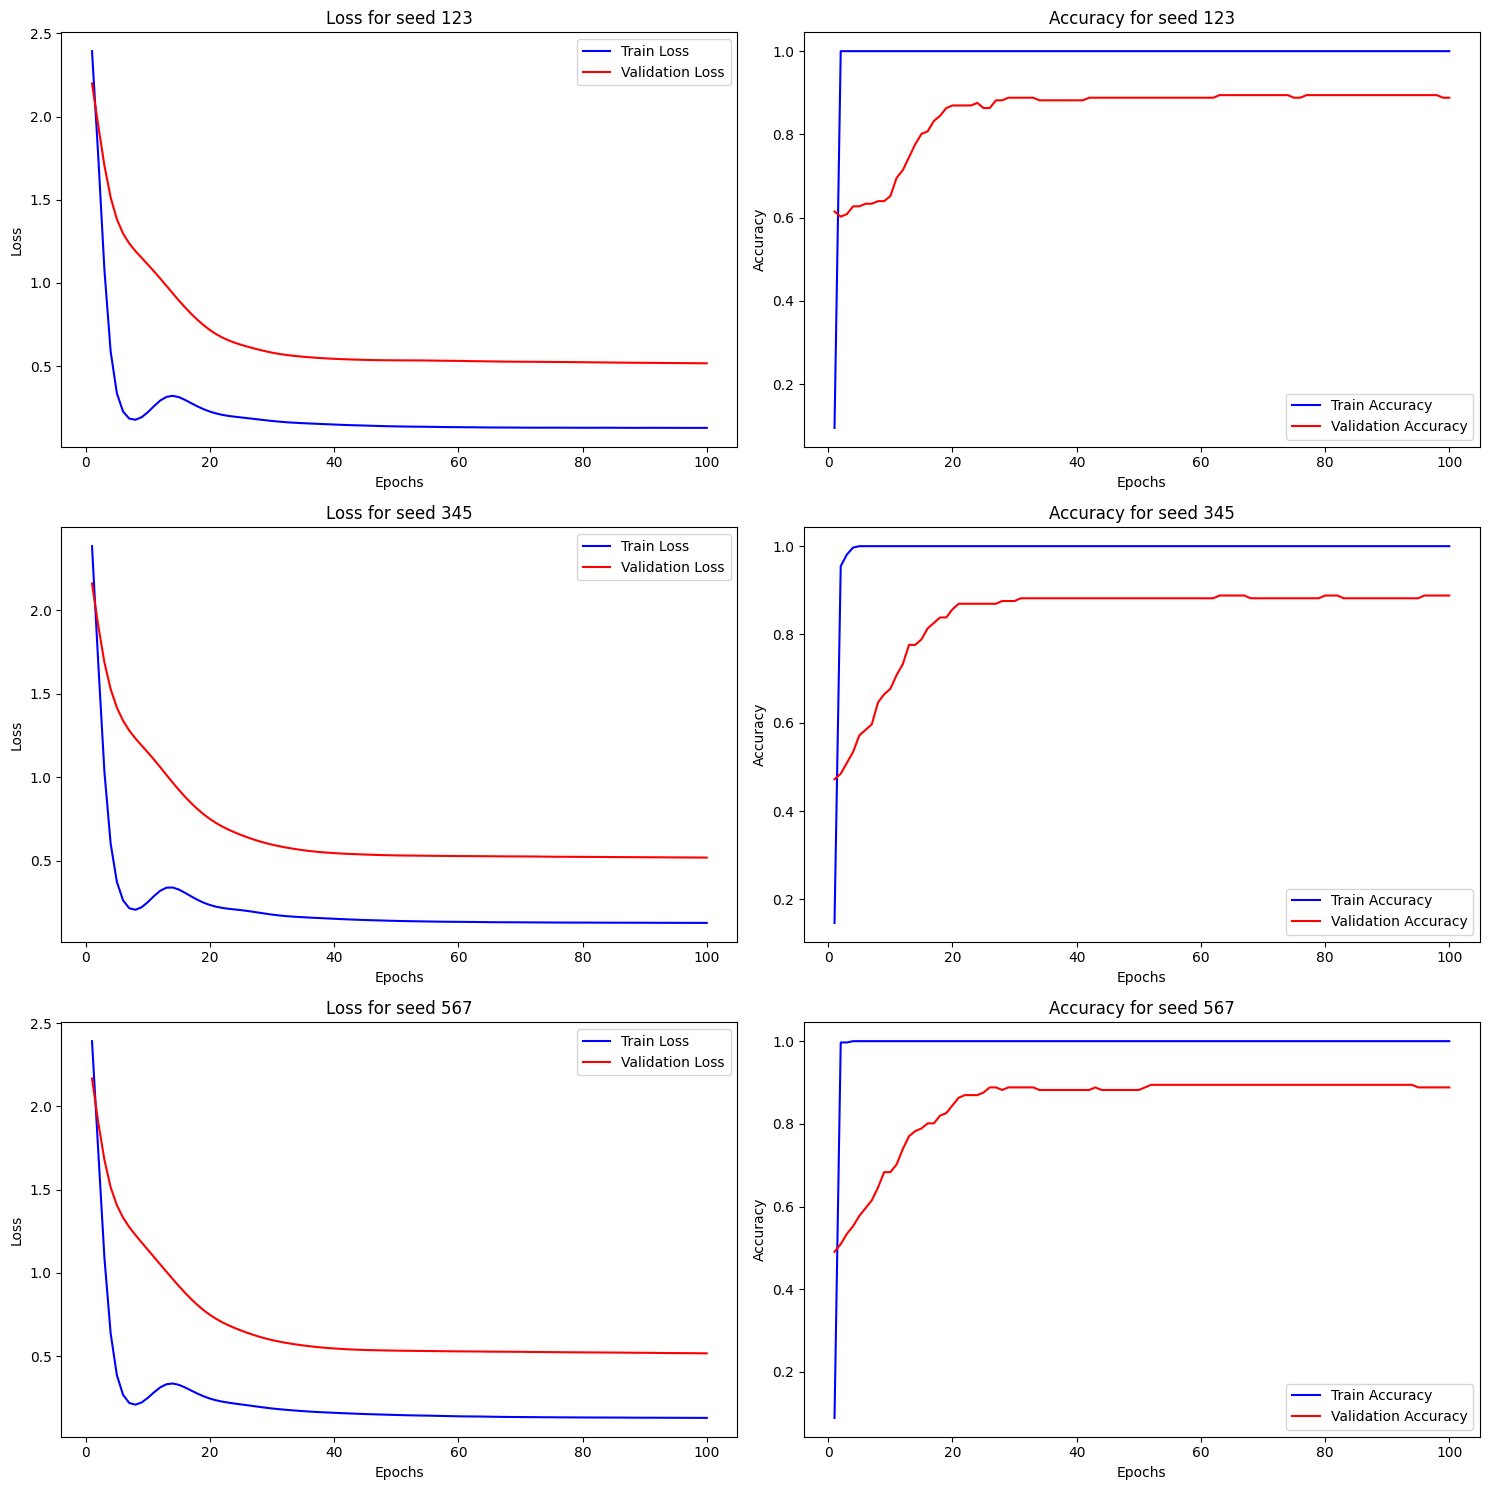

In [ ]:
plot_results(results)

In [ ]:
test_accuracies = [results[f"{seed}"]["test_accuracy"] for seed in DATA_PERTURB_SEEDS]
print(f'Test accuracies: {np.round(test_accuracies, 4)}')
print(f'Average test accuracy: {np.mean(test_accuracies):.4f}')
print(f'Std test accuracy: {np.std(test_accuracies):.4f}')

Test accuracies: [0.8586 0.8586 0.8586]
Average test accuracy: 0.8586
Std test accuracy: 0.0000


#### Changing architecture

In [ ]:
class Better_RGCN(torch.nn.Module):
    def __init__(self, num_relations, num_classes, num_layers=2, num_hidden=16, dropout_rate=0.5):
        super(Better_RGCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.dropout_rate = dropout_rate

        for i in range(num_layers):
            in_channels = num_hidden if i > 0 else data.num_nodes
            out_channels = num_classes if i == num_layers - 1 else num_hidden
            self.convs.append(RGCNConv(in_channels, out_channels, num_relations))
            if i < num_layers - 1:
                self.bns.append(torch.nn.BatchNorm1d(num_hidden))

    def forward(self, edge_index, edge_type):
        x = None

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_type) if x is not None else conv(None, edge_index, edge_type)

            if i < len(self.convs) - 1:
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_rate, training=self.training)

        return F.log_softmax(x, dim=1)



In [ ]:
NUM_RELATIONS = data.num_edge_types
NUM_CLASSES = len(np.unique(data.train_y.cpu().numpy()))

lr = 0.01
weight_decay = 0.01
EPOCHS = 100
width = 32
depth = 3

results = {}

for seed in DATA_PERTURB_SEEDS:

    model = Better_RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []


    best_val_loss = np.inf
    best_val_acc = 0
    best_val_epoch = 0
    best_state_dict = None
    best_dirchlet_energy = np.inf


    for epoch in range(EPOCHS):

        epoch_train_loss, epoch_train_acc = train(model, optimizer, data, loss_fn, device)

        epoch_val_loss, epoch_val_acc = validate(model, data, loss_fn, device)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_loss = epoch_val_loss
            best_val_acc = epoch_val_acc
            best_state_dict = model.state_dict()

        gc.collect()

    # Test with best model
    model = Better_RGCN(num_relations = NUM_RELATIONS, num_classes = NUM_CLASSES, num_layers=depth, num_hidden=width)
    model.load_state_dict(best_state_dict)
    model.to(device)
    test_loss, test_acc = test(model, data, loss_fn, device)


    key = f"{seed}"

    results[key] = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_acc,
    }

    print(f"seed: {seed}, Test loss: {test_loss:.4f}, Test Accuracy {test_acc:.4f}")

    del model, optimizer, loss_fn
    gc.collect()



seed: 123, Test loss: 0.4730, Test Accuracy 0.8788
seed: 345, Test loss: 0.3892, Test Accuracy 0.8788
seed: 567, Test loss: 0.4894, Test Accuracy 0.8636


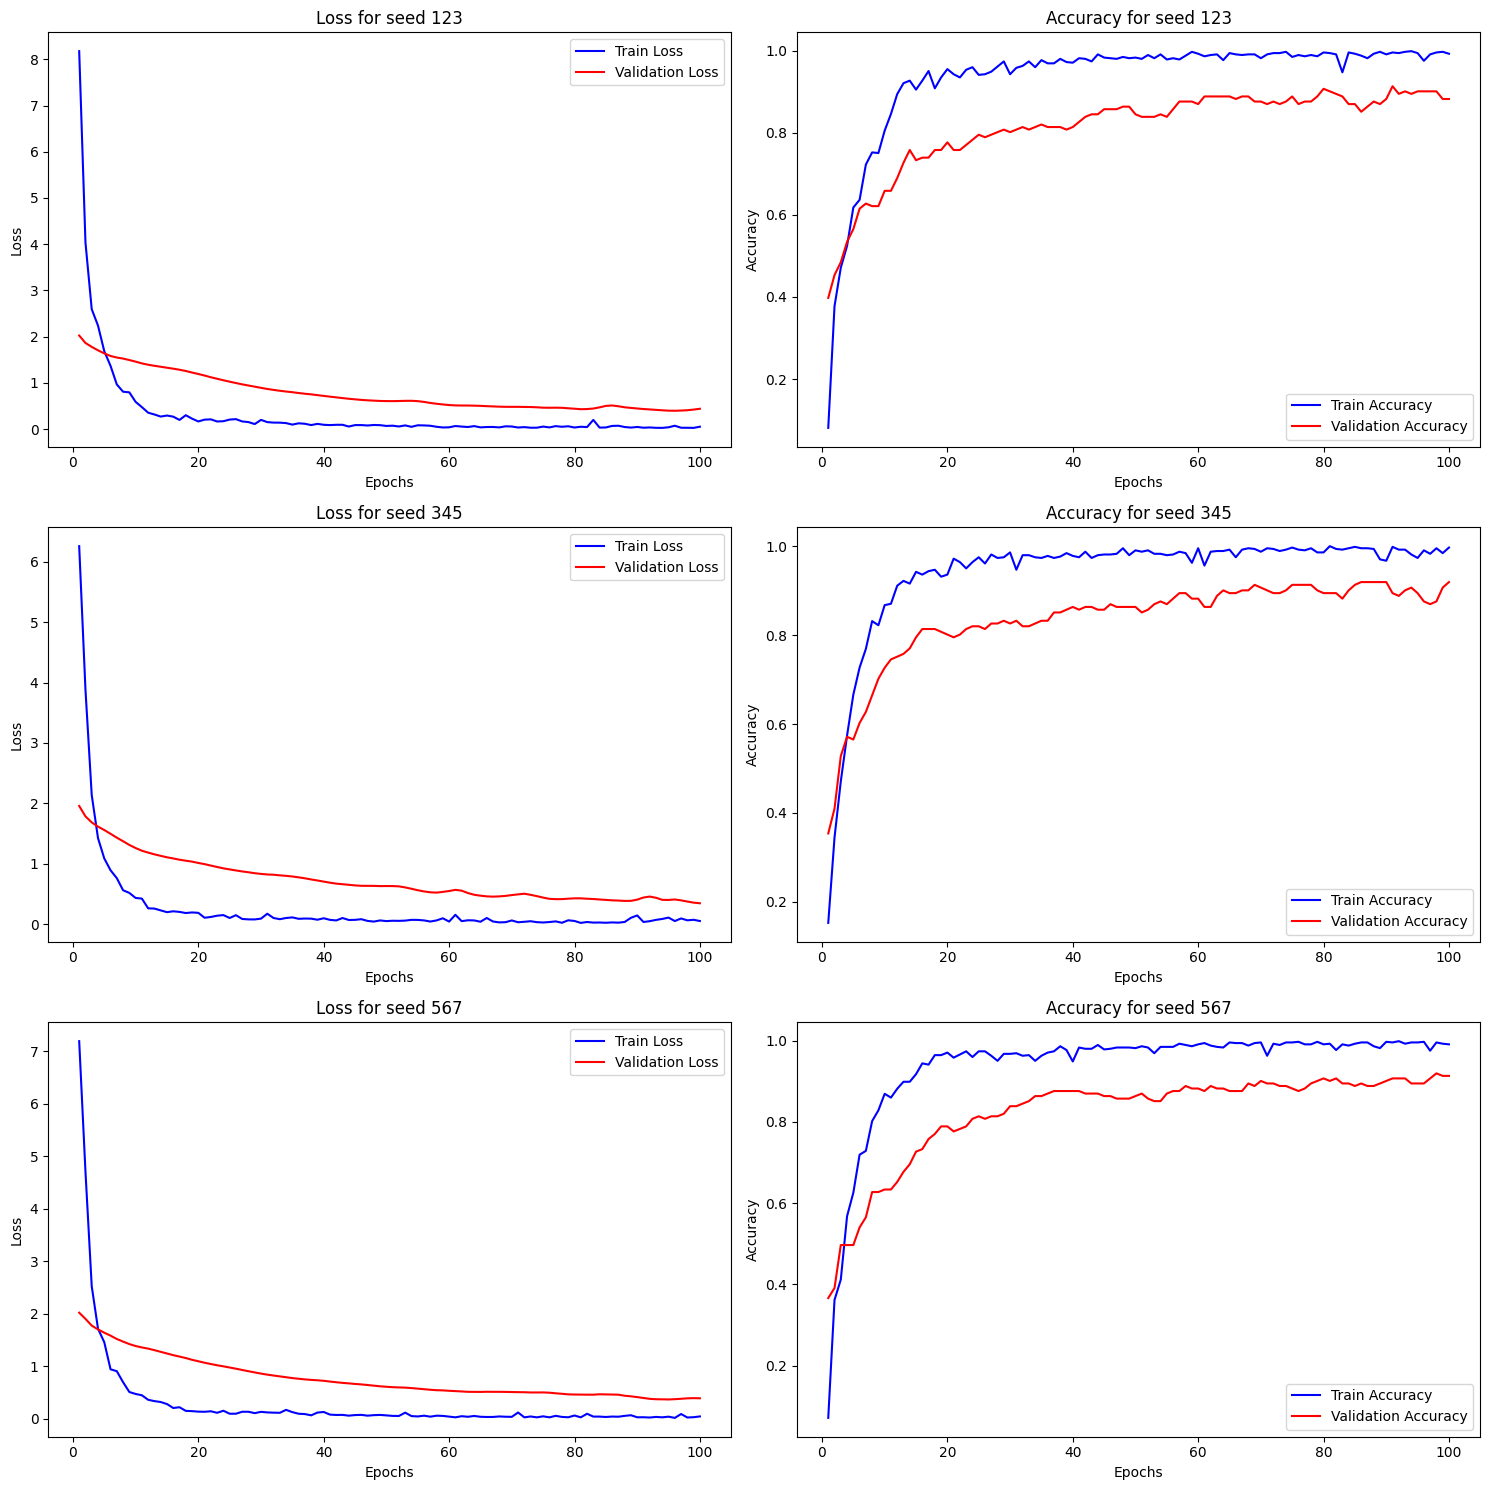

In [ ]:
plot_results(results)

In [ ]:
test_accuracies = [results[f"{seed}"]["test_accuracy"] for seed in DATA_PERTURB_SEEDS]
print(f'Test accuracies: {np.round(test_accuracies, 4)}')
print(f'Average test accuracy: {np.mean(test_accuracies):.4f}')
print(f'Std test accuracy: {np.std(test_accuracies):.4f}')

Test accuracies: [0.8788 0.8788 0.8636]
Average test accuracy: 0.8737
Std test accuracy: 0.0071


## 1.3 Link prediction (FB15k-237)

### Imports

In [ ]:
!pip install torch_geometric
!pip install torcheval
!pip install info-nce-pytorch

In [ ]:
# Standard libraries
import random
import os
import math
from itertools import product
import statistics
from tqdm import tqdm

# Numeric and plotting libraries
import numpy as np
from numpy import linalg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# PyTorch and related modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LSTM
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split, DataLoader
#from torch_scatter import scatter

# Network-related libraries
#import networkx as nx


# PyTorch Geometric
import torch_geometric
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, SAGEConv, RGCNConv
from torch_geometric.nn.pool import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.transforms import Compose, FaceToEdge
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx, dropout_edge

# PyTorch Geometric datasets
from torch_geometric.datasets import FB15k_237


# Machine learning metrics
from sklearn.metrics import accuracy_score
from torcheval.metrics.functional import hit_rate
from info_nce import InfoNCE, info_nce

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = 'cpu'

print("Device: ", device)


Device:  cuda


### Helper functions and Dataset
Since the dataset has no node attributes, we add the degree of each node as an attribute. We use this later to build features

In [ ]:
def add_degs(dataset):
    row, col = dataset.edge_index
    num_nodes = dataset.num_nodes
    degs = torch.zeros((num_nodes, 1), dtype=torch.float)
    for i in range(num_nodes):
        degs[i] = (row == i).sum().float() + (col == i).sum().float()
    return degs

def mrr(logits, true_tags): #For metrics
    logits = logits.clone().detach()  # Convert logits to a PyTorch tensor
    true_tags = true_tags.clone().detach().long() # Convert true_tags to a PyTorch tensor with 'long' data type

    ranks = torch.sum(logits >= torch.gather(logits, 1, true_tags.view(-1, 1)), dim=1)
    mrr = torch.mean(1 / (ranks + 1), dtype=torch.float32)  # Specify the data type for mean calculation
    return mrr.item()  # Convert the result to a Python float


In [ ]:
dataset_train = FB15k_237(root='...', split='train')[0]
dataset_val = FB15k_237(root='...', split='val')[0] #, transform=transform)
dataset_test = FB15k_237(root='...', split='test')[0] #, transform=transform)
dataset_train.degs = add_degs(dataset_train)
dataset_val.degs = add_degs(dataset_train)
dataset_test.degs = add_degs(dataset_test)

class_num = len(torch.unique(dataset_train.edge_type)) #Overall classification class size



In [ ]:
dataset_train.to(device)
dataset_val.to(device)
dataset_test.to(device)

Data(edge_index=[2, 20466], edge_type=[20466], num_nodes=14541, degs=[14541, 1])

### 1.3.1 Data exploration and baselines

In [ ]:
# Training data
print(f'Training data')
print(f'Number of nodes: {dataset_train.num_nodes}')
print(f'Number of edges: {dataset_train.num_edges}')
print(f'Number of features for each node: {dataset_train.num_node_features}')
print(f'Number of edge types: {dataset_train.num_edge_types}')
print(f'Contains isolated nodes: {dataset_train.has_isolated_nodes()}')
print(f'Contains self-loops: {dataset_train.has_self_loops()}')
print(f'Is undirected: {dataset_train.is_undirected()}')
print('-'*50)
print(f'Validation data')
print(f'Number of nodes: {dataset_val.num_nodes}')
print(f'Number of edges: {dataset_val.num_edges}')
print(f'Number of features for each node: {dataset_val.num_node_features}')
print(f'Number of edge types: {dataset_val.num_edge_types}')
print(f'Contains isolated nodes: {dataset_val.has_isolated_nodes()}')
print(f'Contains self-loops: {dataset_val.has_self_loops()}')
print(f'Is undirected: {dataset_val.is_undirected()}')
print('-'*50)
print(f'Test data')
print(f'Number of nodes: {dataset_test.num_nodes}')
print(f'Number of edges: {dataset_test.num_edges}')
print(f'Number of features for each node: {dataset_test.num_node_features}')
print(f'Number of edge types: {dataset_test.num_edge_types}')
print(f'Contains isolated nodes: {dataset_test.has_isolated_nodes()}')
print(f'Contains self-loops: {dataset_test.has_self_loops()}')
print(f'Is undirected: {dataset_test.is_undirected()}')

Training data
Number of nodes: 14541
Number of edges: 272115
Number of features for each node: 0
Number of edge types: 237
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False
--------------------------------------------------
Validation data
Number of nodes: 14541
Number of edges: 17535
Number of features for each node: 0
Number of edge types: 237
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False
--------------------------------------------------
Test data
Number of nodes: 14541
Number of edges: 20466
Number of features for each node: 0
Number of edge types: 237
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False


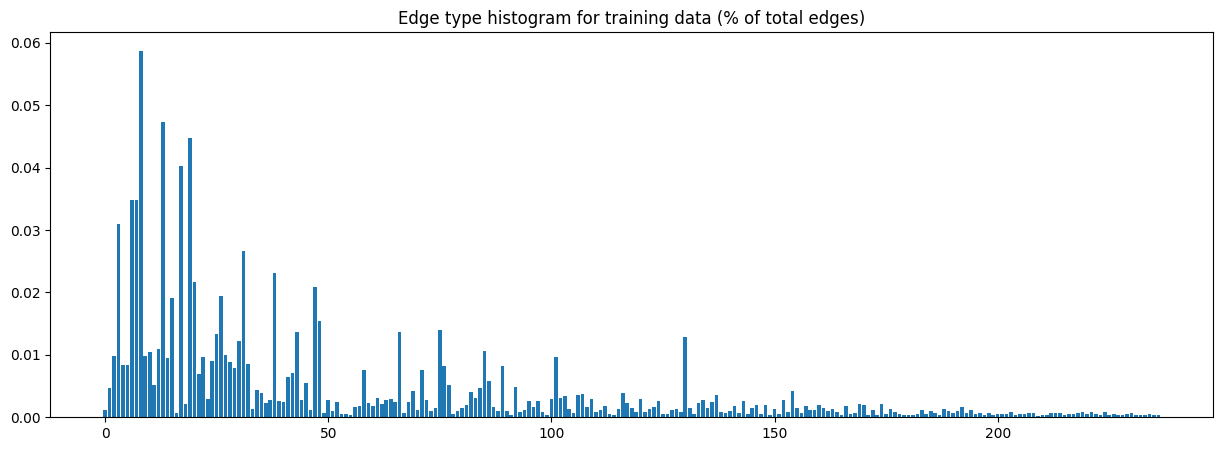

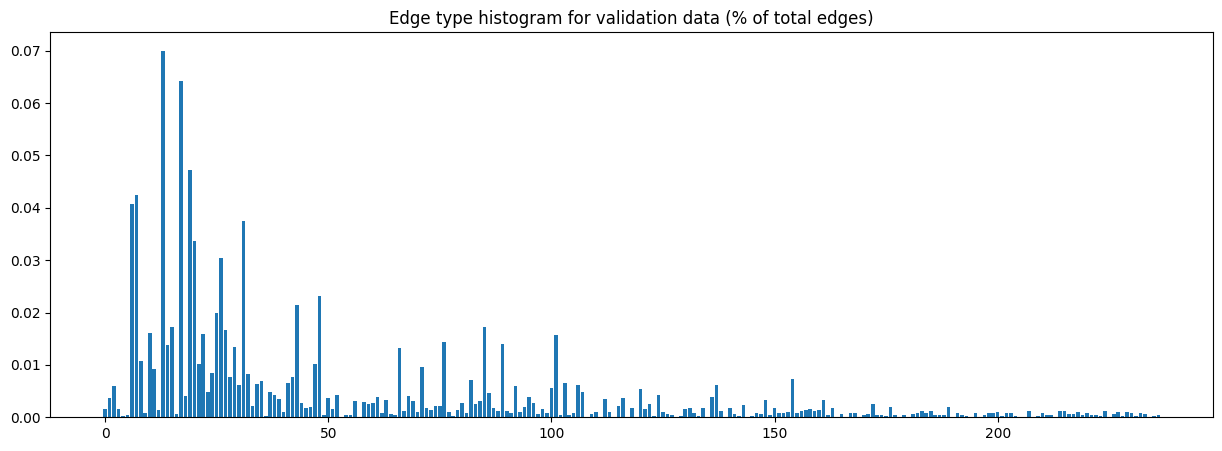

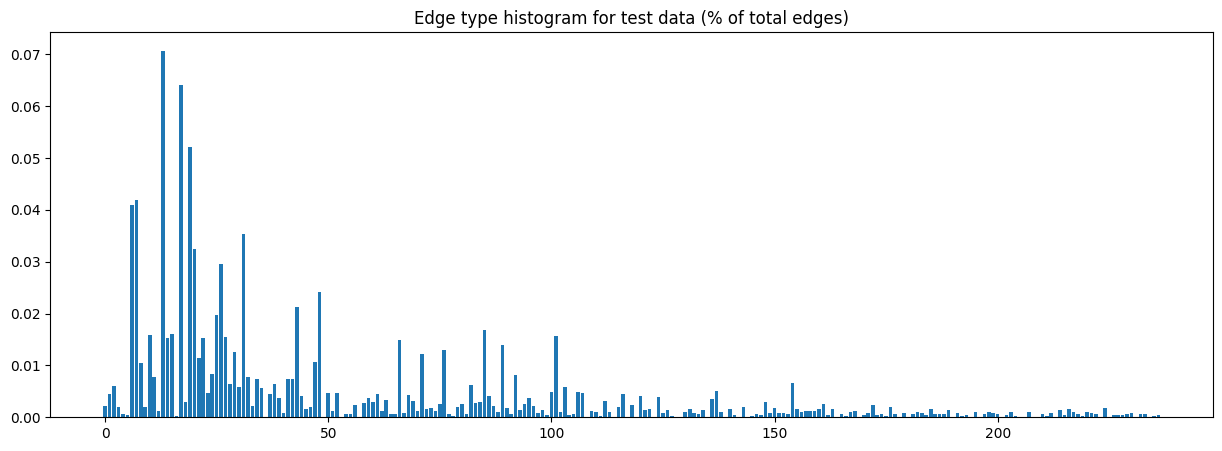

In [ ]:
# Statistics on edge types
edge_type_count_train = torch.bincount(dataset_train.edge_type)
edge_type_count_val = torch.bincount(dataset_val.edge_type)
edge_type_count_test = torch.bincount(dataset_test.edge_type)

edge_type_train_percentage = edge_type_count_train / torch.sum(edge_type_count_train)
edge_type_val_percentage = edge_type_count_val / torch.sum(edge_type_count_val)
edge_type_test_percentage = edge_type_count_test / torch.sum(edge_type_count_test)

# plot train edge type histogram (%)
fig = plt.figure(figsize=(15, 5))
plt.bar(range(len(edge_type_train_percentage)), edge_type_train_percentage.cpu().numpy(), align='center')
plt.title('Edge type histogram for training data (% of total edges)')
plt.show()

# plot val edge type histogram (%)
fig = plt.figure(figsize=(15, 5))
plt.bar(range(len(edge_type_val_percentage)), edge_type_val_percentage.cpu().numpy(), align='center')
plt.title('Edge type histogram for validation data (% of total edges)')
plt.show()

# plot test edge type histogram
fig = plt.figure(figsize=(15, 5))
plt.bar(range(len(edge_type_test_percentage)), edge_type_test_percentage.cpu().numpy(), align='center')
plt.title('Edge type histogram for test data (% of total edges)')
plt.show()

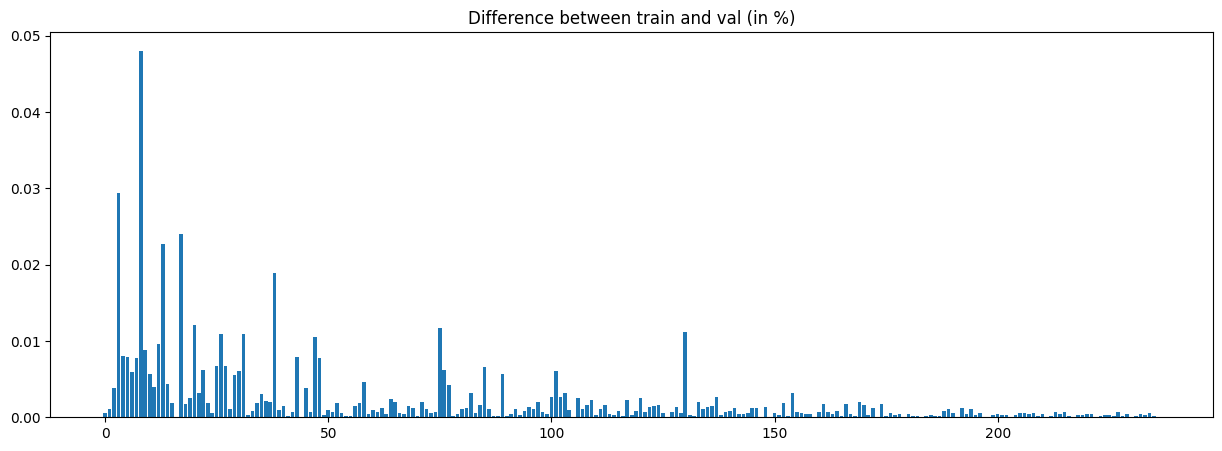

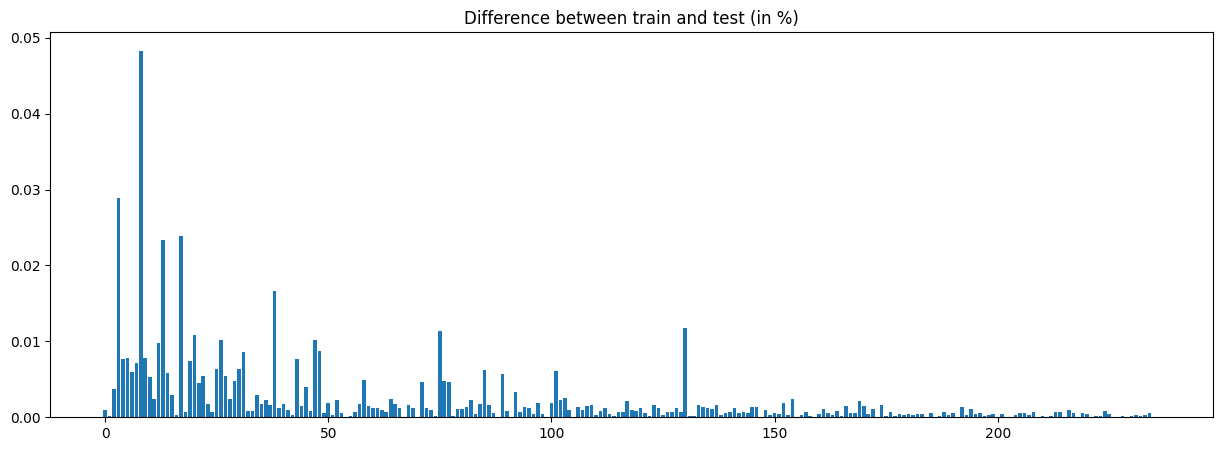

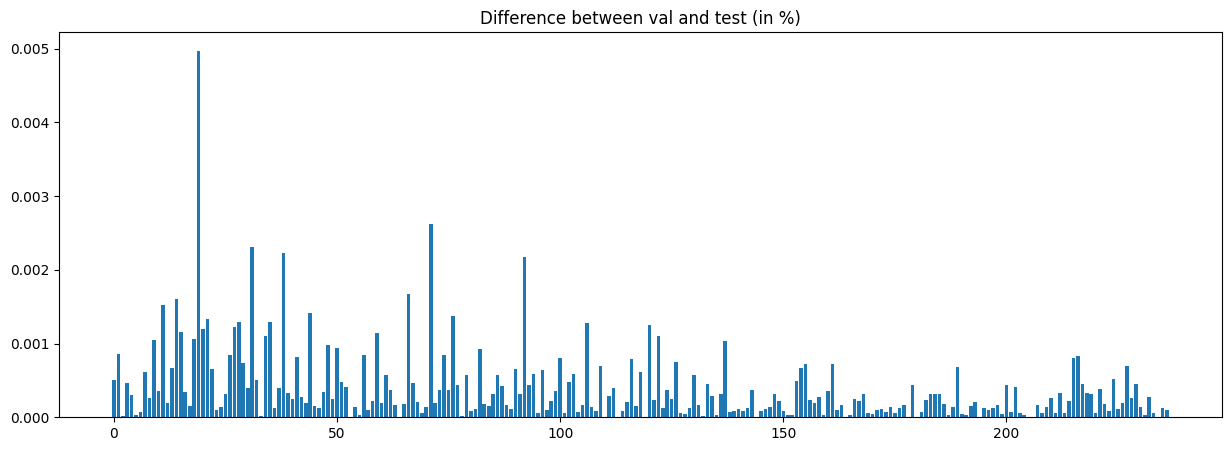

In [ ]:
# compare percentage of edge types in train, val and test data
edge_type_train_percentage = edge_type_count_train / torch.sum(edge_type_count_train)
edge_type_val_percentage = edge_type_count_val / torch.sum(edge_type_count_val)
edge_type_test_percentage = edge_type_count_test / torch.sum(edge_type_count_test)

# Calculate differnces
diff_train_val = torch.abs(edge_type_train_percentage - edge_type_val_percentage)
diff_train_test = torch.abs(edge_type_train_percentage - edge_type_test_percentage)
diff_val_test = torch.abs(edge_type_val_percentage - edge_type_test_percentage)

# Plot the differences
fig = plt.figure(figsize=(15, 5))
plt.bar(range(len(diff_train_val)), diff_train_val.cpu().numpy(), align='center')
plt.title('Difference between train and val (in %)')
plt.show()

fig = plt.figure(figsize=(15, 5))
plt.bar(range(len(diff_train_test)), diff_train_test.cpu().numpy(), align='center')
plt.title('Difference between train and test (in %)')
plt.show()

fig = plt.figure(figsize=(15, 5))
plt.bar(range(len(diff_val_test)), diff_val_test.cpu().numpy(), align='center')
plt.title('Difference between val and test (in %)')
plt.show()

#### Random baseline

In [ ]:
# Random baseline
DATA_PERTURB_SEEDS = [123, 345, 567]
accuracies = []
mrr_scores = []
hit_10_scores = []

for seed in DATA_PERTURB_SEEDS:

    set_seed(seed)
    edge_types = np.unique(dataset_train.edge_type.cpu().numpy())
    predictions = np.random.choice(edge_types, size=len(dataset_test.edge_type))
    accuracy = accuracy_score(dataset_test.edge_type.cpu().numpy(), predictions)

    predictions_tensor = torch.rand(len(predictions), len(edge_types))
    mrr_score = mrr(predictions_tensor, dataset_test.edge_type)
    hit_10 = hit_rate(predictions_tensor, dataset_test.edge_type,  k=10).mean()

    accuracies.append(accuracy)
    mrr_scores.append(mrr_score)
    hit_10_scores.append(hit_10)


print(f'Average accuracy: {np.mean(accuracies):.4f}, std: {np.std(accuracies):.4f}, Accuracy: {np.round(accuracies, 4)}')
print(f'Average mrr: {np.mean(mrr_scores):.4f}, std: {np.std(mrr_scores):.4f}, mrr: {np.round(mrr_scores, 4)}')
print(f'Average hit_10: {np.mean(hit_10_scores):.4f}, std: {np.std(hit_10_scores):.4f}, hit_10: {np.round(hit_10_scores, 4)}')

Average accuracy: 0.0037, std: 0.0005, Accuracy: [0.0038 0.003  0.0043]
Average mrr: 0.0215, std: 0.0003, mrr: [0.0215 0.0218 0.021 ]
Average hit_10: 0.0427, std: 0.0016, hit_10: [0.0442 0.0434 0.0405]


#### Feature baseline

In [ ]:
def create_feature_matrix(edge_indices, degs):
    feature_matrix = []
    for i in range(edge_indices.shape[1]):
        node1, node2 = edge_indices[:, i]
        degree_node1 = degs[node1.item()].item()
        degree_node2 = degs[node2.item()].item()
        feature_matrix.append([degree_node1, degree_node2])
    return np.array(feature_matrix)

train_features = create_feature_matrix(dataset_train.edge_index, dataset_train.degs)
test_features = create_feature_matrix(dataset_test.edge_index, dataset_test.degs)


In [ ]:
# Random Forest with the degrees of the two nodes connected by each edge as features
DATA_PERTURB_SEEDS = [123, 345, 567]
accuracies = []
mrr_scores = []
hit_10_scores = []

for seed in DATA_PERTURB_SEEDS:

    set_seed(seed)
    clf = RandomForestClassifier(random_state=seed, n_estimators = 10)
    clf.fit(train_features, dataset_train.edge_type)
    predictions = clf.predict(test_features)
    predictions_proba = clf.predict_proba(test_features)

    accuracy = accuracy_score(dataset_test.edge_type, predictions)
    mrr_score = mrr(torch.tensor(predictions_proba), dataset_test.edge_type)
    hit_10 = hit_rate(torch.tensor(predictions_proba), dataset_test.edge_type,  k=10).mean()

    accuracies.append(accuracy)
    mrr_scores.append(mrr_score)
    hit_10_scores.append(hit_10)

print(f'Average accuracy: {np.mean(accuracies):.4f}, std: {np.std(accuracies):.4f}, Accuracy: {np.round(accuracies, 4)}')
print(f'Average mrr: {np.mean(mrr_scores):.4f}, std: {np.std(mrr_scores):.4f}, mrr: {np.round(mrr_scores, 4)}')
print(f'Average hit_10: {np.mean(hit_10_scores):.4f}, std: {np.std(hit_10_scores):.4f}, hit_10: {np.round(hit_10_scores, 4)}')

Average accuracy: 0.0182, std: 0.0028, Accuracy: [0.0142 0.0201 0.0202]
Average mrr: 0.0181, std: 0.0007, mrr: [0.0173 0.0189 0.018 ]
Average hit_10: 0.8593, std: 0.0036, hit_10: [0.8619 0.8618 0.8542]


### 1.3.2 End to End GNN For Link Prediction

#### Model Declaration

In [ ]:
### Model Declaration
### GNN layer for node embeddings
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = RGCNConv(hidden_channels, hidden_channels, num_relations=237)
        #self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations=237)
    def forward(self, x, edge_index,edge_type):
        x = self.conv1(x, edge_index,edge_type)
        #x = self.conv2(x, edge_index)
        return x
### Classification Head for node to node link prediction
class ClassificationHead(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_classes, dropout = 0.5):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_classes)
        self.dropout = dropout

    def forward(self, x_i, x_j, edge_label_index):
        x_input = torch.cat([x_i, x_j], dim=1)
        x = F.relu(self.lin1(x_input))
        x = F.dropout(x, p=self.dropout, training=self.training)
        logits = self.lin2(x)
        return logits


class link_predictor_1_3_2(torch.nn.Module):
    def __init__(self, hidden_channels, dropout, out_classes):
        super().__init__()
        self.embedder = torch.nn.Linear(1, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.classifier = ClassificationHead(hidden_channels, hidden_channels, out_classes,dropout)
        #self.classifier = ClassificationHead()

    def forward(self, degs, edge_index,edge_type):

        #deg = torch_geometric.utils.degree(edge_index[0]).unsqueeze(1).float()
        x = self.embedder(degs)
        x = self.gnn(x, edge_index,edge_type)
        indices_i = edge_index[0].int()
        indices_j = edge_index[1].int()
        x_i, x_j = x[indices_i], x[indices_j]
        logits = self.classifier(x_i, x_j, edge_index)
        return logits




#### Hyperparameter Tuning Hidden Dimension Size and Dropout Rate

In [ ]:
perturb_seed = 42
dropouts = [0, 0.2, 0.5, 0.7]
hidden_channels = [128, 256, 512, 1024]
train_size = 512
test_size = 256
batch_size = 256
learning_rate = 0.0001
weight_decay = 0.005
scheduler = True
schedule_patience = 20
epochs = 10
results = {}
verbose = False
torch.manual_seed(perturb_seed)

for dropout in dropouts:
    for hidden_channel in hidden_channels:
        model = link_predictor_1_3_2(hidden_channels=hidden_channel, dropout = dropout, out_classes=class_num).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        model_name = "Hidden Size: {}, Dropout: {}".format(hidden_channel, dropout)
        print("Testing Model: {}".format(model_name))

        for epoch in tqdm(range(epochs)):
            #Forward pass model to get logits
            logits = model(dataset_train.degs,dataset_train.edge_index,dataset_train.edge_type)
            # Compute loss
            loss_train = F.cross_entropy(logits, dataset_train.edge_type)
            predicted_tag = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_tags = dataset_train.edge_type.detach().cpu()
            accuracy_train = accuracy_score(true_tags.numpy(), predicted_tag)
            # Backward pass
            loss_train.backward()
            # Update weights
            optimizer.step()
            #Get hitrate scores


            h_5_train = hit_rate(logits.cpu(), true_tags.cpu(), k=5).mean()
            h_10_train = hit_rate(logits.cpu(), true_tags.cpu(), k=10).mean()
            h_20_train = hit_rate(logits.cpu(), true_tags.cpu(), k=20).mean()
            mrr_train = mrr(logits.cpu(), true_tags.cpu())

            #Validation Step
            with torch.no_grad():
                logits_test = model(dataset_val.degs,dataset_val.edge_index,dataset_val.edge_type)
                loss_test = F.cross_entropy(logits_test, dataset_val.edge_type)
                predicted_tag_test = torch.argmax(logits_test, dim=1).detach().cpu().numpy()
                true_tags_test = dataset_val.edge_type.detach().cpu()
                accuracy_test = accuracy_score(true_tags_test.numpy(), predicted_tag_test)
                h_5_test = hit_rate(logits_test.cpu(), true_tags_test.cpu(), k=5).mean()
                h_10_test = hit_rate(logits_test.cpu(), true_tags_test.cpu(), k=10).mean()
                h_20_test = hit_rate(logits_test.cpu(), true_tags_test.cpu(), k=20).mean()
                mrr_test = mrr(logits_test.cpu(), true_tags_test.cpu())

            #Print Update
            if verbose:
                print("Epoch: {}".format(epoch))
                print("Train Loss: {}, Train Accuracy: {}, MRR Train: {}, Train H@5: {}, Train Train H@10: {}, Train H@20: {}".format(loss_train, accuracy_train, mrr_train, h_5_train, h_10_train, h_20_train))
                print("Val Loss: {}, Test Accuracy: {}, MRR Test: {}, Test H@5: {}, Test H@10: {}, Test H@20: {}".format(loss_test, accuracy_test, mrr_test, h_5_test, h_10_test, h_20_test))
    # Save the results


        key = model_name

        results[key] = {
            "train_loss": loss_train,
            "test_loss": loss_test,
            "h_10_train": h_10_train,
            "h_10_test": h_10_test,
            "mrr_train": mrr_train,
            "mrr_test": mrr_test,
            }
        print("Results for Model: {}".format(model_name))
        print("Train Loss: {}, Val Loss: {}, Train MRR: {}, Val MRR: {}, Train H@10: {}, Val H@10: {}".format(loss_train, loss_test, mrr_train, mrr_test, h_10_train, h_10_test))
        torch.cuda.empty_cache()

Testing Model: Hidden Size: 128, Dropout: 0


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


Results for Model: Hidden Size: 128, Dropout: 0
Train Loss: 308.5723571777344, Val Loss: 144.11000061035156, Train MRR: 0.04333766549825668, Val MRR: 0.02305324375629425, Train H@10: 0.11294856667518616, Val H@10: 0.04453949257731438
Testing Model: Hidden Size: 256, Dropout: 0


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


Results for Model: Hidden Size: 256, Dropout: 0
Train Loss: 174.2951202392578, Val Loss: 105.71697235107422, Train MRR: 0.14703911542892456, Val MRR: 0.07214725017547607, Train H@10: 0.3721882402896881, Val H@10: 0.22862845659255981
Testing Model: Hidden Size: 512, Dropout: 0


100%|██████████| 10/10 [02:49<00:00, 16.95s/it]


Results for Model: Hidden Size: 512, Dropout: 0
Train Loss: 149.71466064453125, Val Loss: 81.83866119384766, Train MRR: 0.2924024760723114, Val MRR: 0.22137685120105743, Train H@10: 0.7282546162605286, Val H@10: 0.5880810022354126
Testing Model: Hidden Size: 1024, Dropout: 0


100%|██████████| 10/10 [08:26<00:00, 50.61s/it]


Results for Model: Hidden Size: 1024, Dropout: 0
Train Loss: 342.3458251953125, Val Loss: 211.78038024902344, Train MRR: 0.2800118923187256, Val MRR: 0.21213999390602112, Train H@10: 0.7109531164169312, Val H@10: 0.5329911708831787
Testing Model: Hidden Size: 128, Dropout: 0.2


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Results for Model: Hidden Size: 128, Dropout: 0.2
Train Loss: 321.7581481933594, Val Loss: 185.11715698242188, Train MRR: 0.045930493623018265, Val MRR: 0.03355005756020546, Train H@10: 0.1272880882024765, Val H@10: 0.08645565807819366
Testing Model: Hidden Size: 256, Dropout: 0.2


100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


Results for Model: Hidden Size: 256, Dropout: 0.2
Train Loss: 209.22483825683594, Val Loss: 110.9874267578125, Train MRR: 0.14526638388633728, Val MRR: 0.07674198597669601, Train H@10: 0.4078826904296875, Val H@10: 0.22212716937065125
Testing Model: Hidden Size: 512, Dropout: 0.2


100%|██████████| 10/10 [03:00<00:00, 18.10s/it]


Results for Model: Hidden Size: 512, Dropout: 0.2
Train Loss: 195.65679931640625, Val Loss: 125.46399688720703, Train MRR: 0.276826947927475, Val MRR: 0.1837722361087799, Train H@10: 0.7167337536811829, Val H@10: 0.5315654277801514
Testing Model: Hidden Size: 1024, Dropout: 0.2


100%|██████████| 10/10 [08:37<00:00, 51.72s/it]


Results for Model: Hidden Size: 1024, Dropout: 0.2
Train Loss: 313.03448486328125, Val Loss: 158.45712280273438, Train MRR: 0.2971418797969818, Val MRR: 0.24639418721199036, Train H@10: 0.7334104776382446, Val H@10: 0.617507815361023
Testing Model: Hidden Size: 128, Dropout: 0.5


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Results for Model: Hidden Size: 128, Dropout: 0.5
Train Loss: 409.8979187011719, Val Loss: 252.40966796875, Train MRR: 0.029533831402659416, Val MRR: 0.02359492890536785, Train H@10: 0.06928688287734985, Val H@10: 0.04807527735829353
Testing Model: Hidden Size: 256, Dropout: 0.5


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Results for Model: Hidden Size: 256, Dropout: 0.5
Train Loss: 262.0408935546875, Val Loss: 135.6669921875, Train MRR: 0.10244685411453247, Val MRR: 0.06008943170309067, Train H@10: 0.2920787036418915, Val H@10: 0.17422297596931458
Testing Model: Hidden Size: 512, Dropout: 0.5


100%|██████████| 10/10 [02:59<00:00, 17.93s/it]


Results for Model: Hidden Size: 512, Dropout: 0.5
Train Loss: 218.22108459472656, Val Loss: 119.36882019042969, Train MRR: 0.2491741180419922, Val MRR: 0.16764813661575317, Train H@10: 0.6496371030807495, Val H@10: 0.4635300934314728
Testing Model: Hidden Size: 1024, Dropout: 0.5


100%|██████████| 10/10 [08:23<00:00, 50.37s/it]


Results for Model: Hidden Size: 1024, Dropout: 0.5
Train Loss: 283.2432556152344, Val Loss: 153.3688507080078, Train MRR: 0.2852281332015991, Val MRR: 0.22660502791404724, Train H@10: 0.7505099177360535, Val H@10: 0.5861990451812744
Testing Model: Hidden Size: 128, Dropout: 0.7


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


Results for Model: Hidden Size: 128, Dropout: 0.7
Train Loss: 521.0802612304688, Val Loss: 274.16729736328125, Train MRR: 0.03381827473640442, Val MRR: 0.027837514877319336, Train H@10: 0.08496040105819702, Val H@10: 0.062161389738321304
Testing Model: Hidden Size: 256, Dropout: 0.7


100%|██████████| 10/10 [01:01<00:00,  6.13s/it]


Results for Model: Hidden Size: 256, Dropout: 0.7
Train Loss: 412.39984130859375, Val Loss: 255.90736389160156, Train MRR: 0.07615064084529877, Val MRR: 0.052345216274261475, Train H@10: 0.21651139855384827, Val H@10: 0.1435985118150711
Testing Model: Hidden Size: 512, Dropout: 0.7


100%|██████████| 10/10 [02:57<00:00, 17.76s/it]


Results for Model: Hidden Size: 512, Dropout: 0.7
Train Loss: 260.5543518066406, Val Loss: 150.6845703125, Train MRR: 0.18935011327266693, Val MRR: 0.13049089908599854, Train H@10: 0.5128750801086426, Val H@10: 0.3743370473384857
Testing Model: Hidden Size: 1024, Dropout: 0.7


100%|██████████| 10/10 [08:23<00:00, 50.35s/it]

Results for Model: Hidden Size: 1024, Dropout: 0.7
Train Loss: 291.8943176269531, Val Loss: 155.4382781982422, Train MRR: 0.25237372517585754, Val MRR: 0.1955745369195938, Train H@10: 0.6678867340087891, Val H@10: 0.5110350847244263


In [ ]:
#Finding model with the highest h@10 score and dropoit from the results dictionary
max_h_10 = 0
max_h_10_model = ""
for key in results:
    if results[key]["h_10_test"] > max_h_10:
        max_h_10 = results[key]["h_10_test"]
        max_h_10_model = key
print("Best performing model at h@10: {}".format(max_h_10_model))
#Finding model with the highest mrr score and dropoit from the results dictionary
max_mrr = 0
max_mrr_model = ""
for key in results:
    if results[key]["mrr_test"] > max_mrr:
        max_mrr = results[key]["mrr_test"]
        max_mrr_model = key
print("Best performing model at MRR: {}".format(max_mrr_model))
#Finding the model with the highest average between h@10 and mrr
max_avg = 0
max_avg_model = ""
for key in results:
    avg = (results[key]["h_10_test"] + results[key]["mrr_test"])/2
    if avg > max_avg:
        max_avg = avg
        max_avg_model = key
print("Best performing model at Average MRR and H@10: {}".format(max_avg_model))


Best performing model at h@10: Hidden Size: 1024, Dropout: 0.2
Best performing model at MRR: Hidden Size: 1024, Dropout: 0.2
Best performing model at Average MRR and H@10: Hidden Size: 1024, Dropout: 0.2


#### Test Set Evaluation

In [ ]:
perturb_seeds = [123,345,567]
hidden_channel = 1024
dropout = 0.2

learning_rate = 0.0001
weight_decay = 0.005
scheduler = True
schedule_patience = 20
epochs = 10
results = {}
verbose = True

test_mrrs = []
test_h_10s = []


for seed in perturb_seeds:

        torch.manual_seed(seed)
        model = link_predictor_1_3_2(hidden_channels=hidden_channel, dropout = dropout, out_classes=class_num)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        model_name = "Hidden Size: {}, Dropout: {}".format(hidden_channel, dropout)

        train_loss_for_epoch = []
        test_loss_for_epoch = []
        train_accuracies_for_epoch = []
        test_accuracies_for_epoch = []

        for epoch in tqdm(range(epochs)):
            #Forward pass model to get logits
            logits = model(dataset_train.degs,dataset_train.edge_index,dataset_train.edge_type)
            # Compute loss
            optimizer.zero_grad()
            loss_train = F.cross_entropy(logits, dataset_train.edge_type)
            predicted_tag = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_tags = dataset_train.edge_type.detach().cpu()
            accuracy_train = accuracy_score(true_tags.numpy(), predicted_tag)
            # Backward pass
            loss_train.backward()
            train_loss_for_epoch.append(loss_train)
            train_accuracies_for_epoch.append(accuracy_train)
            # Update weights
            optimizer.step()
            #Get hitrate scores

            h_5_train = hit_rate(logits, true_tags, k=5).mean()
            h_10_train = hit_rate(logits, true_tags, k=10).mean()
            h_20_train = hit_rate(logits, true_tags, k=20).mean()
            mrr_train = mrr(logits, true_tags)

            #Validation Step
            with torch.no_grad():
                logits_test = model(dataset_val.degs,dataset_val.edge_index,dataset_val.edge_type)
                loss_test = F.cross_entropy(logits_test, dataset_val.edge_type)
                predicted_tag_test = torch.argmax(logits_test, dim=1).detach().cpu().numpy()
                true_tags_test = dataset_val.edge_type.detach().cpu()
                accuracy_test = accuracy_score(true_tags_test.numpy(), predicted_tag_test)

                test_loss_for_epoch.append(loss_test)
                test_accuracies_for_epoch.append(accuracy_test)

                h_5_test = hit_rate(logits_test, true_tags_test, k=5).mean()
                h_10_test = hit_rate(logits_test, true_tags_test, k=10).mean()
                h_20_test = hit_rate(logits_test, true_tags_test, k=20).mean()
                mrr_test = mrr(logits_test, true_tags_test)

            #Print Update
            if verbose:
                print("Epoch: {}".format(epoch))
                print("Train Loss: {}, Train Accuracy: {}, MRR Train:{}, Train H@5: {}, Train Train H@10: {}, Train H@20: {}".format(loss_train, accuracy_train, mrr_train, h_5_train, h_10_train, h_20_train))
                print("Val Loss: {}, Val Accuracy: {}, MRRR Val: {}, Val H@5: {}, Val H@10: {}, Val H@20: {}".format(loss_test, accuracy_test, mrr_test, h_5_test, h_10_test, h_20_test))
        # Save the results
        key = "Seed: {}".format(seed)
        results[key] = {
            "train_loss": train_loss_for_epoch,
            "test_loss": test_loss_for_epoch,
            "train_accuracy": train_accuracies_for_epoch,
            "test_accuracy": test_accuracies_for_epoch,
            "h_10_train": h_10_train,
            "h_10_test": h_10_test,
            "mrr_train": mrr_train,
            "mrr_test": mrr_test,
            }


        print("Results for Model: {}".format(model_name))
        print("Train Loss: {}, Val Loss: {}, Train MRR: {}, Val MRR: {}, Train H@10: {}, Val H@10: {}".format(loss_train, loss_test, mrr_train, mrr_test, h_10_train, h_10_test))
        print("Running Test on Seed: {}".format(seed))
        print("###############################################")
        with torch.no_grad():
                logits_test = model(dataset_test.degs,dataset_test.edge_index,dataset_test.edge_type)
                loss_test = F.cross_entropy(logits_test, dataset_test.edge_type)
                predicted_tag_test = torch.argmax(logits_test, dim=1).detach().cpu().numpy()
                true_tags_test = dataset_test.edge_type.detach().cpu()
                accuracy_test = accuracy_score(true_tags_test.numpy(), predicted_tag_test)
                h_5_test = hit_rate(logits_test, true_tags_test, k=5).mean()
                h_10_test = hit_rate(logits_test, true_tags_test, k=10).mean()
                h_20_test = hit_rate(logits_test, true_tags_test, k=20).mean()
                mrr_test = mrr(logits_test, true_tags_test)
                test_mrrs.append(mrr_test)
                test_h_10s.append(h_10_test)



 10%|█         | 1/10 [01:01<09:13, 61.45s/it]

Epoch: 0
Train Loss: 586.4599609375, Train Accuracy: 0.0014552670745824376, MRR Train:0.016468346118927002, Train H@5: 0.00995167437940836, Train Train H@10: 0.02340187132358551, Train H@20: 0.05561986565589905
Val Loss: 186.91122436523438, Val Accuracy: 0.03398916452808668, MRRR Val: 0.05846145376563072, Val H@5: 0.1007128581404686, Val H@10: 0.16692329943180084, Val H@20: 0.2682064473628998


 20%|██        | 2/10 [02:03<08:16, 62.09s/it]

Epoch: 1
Train Loss: 300.56243896484375, Train Accuracy: 0.10705032798632931, MRR Train:0.10971754789352417, Train H@5: 0.2294691652059555, Train Train H@10: 0.30758318305015564, Train H@20: 0.4078790247440338
Val Loss: 130.4220428466797, Val Accuracy: 0.11337325349301397, MRRR Val: 0.12276039272546768, Val H@5: 0.2632449269294739, Val H@10: 0.3626461327075958, Val H@20: 0.48046764731407166


 30%|███       | 3/10 [03:02<07:01, 60.27s/it]

Epoch: 2
Train Loss: 230.66961669921875, Train Accuracy: 0.2958014074931555, MRR Train:0.22068676352500916, Train H@5: 0.48860591650009155, Train Train H@10: 0.565558671951294, Train H@20: 0.6456902623176575
Val Loss: 126.7684097290039, Val Accuracy: 0.19486740804106073, MRRR Val: 0.1705402284860611, Val H@5: 0.3788423240184784, Val H@10: 0.47573423385620117, Val H@20: 0.5776447057723999


 40%|████      | 4/10 [03:56<05:48, 58.05s/it]

Epoch: 3
Train Loss: 179.90325927734375, Train Accuracy: 0.366569281370009, MRR Train:0.2737661898136139, Train H@5: 0.6285320520401001, Train Train H@10: 0.6990720629692078, Train H@20: 0.7639343738555908
Val Loss: 148.0660858154297, Val Accuracy: 0.22372398061020815, MRRR Val: 0.19033251702785492, Val H@5: 0.43051040172576904, Val H@10: 0.5282577872276306, Val H@20: 0.6265754103660583


 50%|█████     | 5/10 [04:56<04:52, 58.53s/it]

Epoch: 4
Train Loss: 150.8631591796875, Train Accuracy: 0.4060856623118902, MRR Train:0.29988038539886475, Train H@5: 0.6943424940109253, Train Train H@10: 0.7654300332069397, Train H@20: 0.8237730264663696
Val Loss: 144.25157165527344, Val Accuracy: 0.2529227259766182, MRRR Val: 0.20462606847286224, Val H@5: 0.4627887010574341, Val H@10: 0.5595665574073792, Val H@20: 0.6543484330177307


 60%|██████    | 6/10 [05:54<03:53, 58.44s/it]

Epoch: 5
Train Loss: 135.65170288085938, Train Accuracy: 0.44449589328041456, MRR Train:0.3181155323982239, Train H@5: 0.73460853099823, Train Train H@10: 0.8006467819213867, Train H@20: 0.8538118004798889
Val Loss: 140.6743621826172, Val Accuracy: 0.2846307385229541, MRRR Val: 0.21942545473575592, Val H@5: 0.49193042516708374, Val H@10: 0.580096960067749, Val H@20: 0.6733960509300232


 70%|███████   | 7/10 [06:55<02:57, 59.25s/it]

Epoch: 6
Train Loss: 120.33866119384766, Train Accuracy: 0.46606398030244567, MRR Train:0.32921868562698364, Train H@5: 0.7586020827293396, Train Train H@10: 0.8260955810546875, Train H@20: 0.8771475553512573
Val Loss: 133.36288452148438, Val Accuracy: 0.31953236384374106, MRRR Val: 0.23527613282203674, Val H@5: 0.5215854048728943, Val H@10: 0.6114627718925476, Val H@20: 0.6978614330291748


 80%|████████  | 8/10 [07:57<02:00, 60.22s/it]

Epoch: 7
Train Loss: 105.11640167236328, Train Accuracy: 0.4900207632802308, MRR Train:0.34043073654174805, Train H@5: 0.7828307747840881, Train Train H@10: 0.8475461006164551, Train H@20: 0.8950958251953125
Val Loss: 123.54643249511719, Val Accuracy: 0.3448531508411748, MRRR Val: 0.24796779453754425, Val H@5: 0.550727128982544, Val H@10: 0.6365554332733154, Val H@20: 0.7218705415725708


 90%|█████████ | 9/10 [08:56<00:59, 59.86s/it]

Epoch: 8
Train Loss: 95.8659896850586, Train Accuracy: 0.5119563419877625, MRR Train:0.34993162751197815, Train H@5: 0.8015140891075134, Train Train H@10: 0.8640978932380676, Train H@20: 0.9080278277397156
Val Loss: 117.31732940673828, Val Accuracy: 0.36726546906187624, MRRR Val: 0.25790393352508545, Val H@5: 0.5715426206588745, Val H@10: 0.6560022830963135, Val H@20: 0.7361847758293152


100%|██████████| 10/10 [09:57<00:00, 59.80s/it]

Epoch: 9
Train Loss: 88.24304962158203, Train Accuracy: 0.5305403965235287, MRR Train:0.35885941982269287, Train H@5: 0.8205978870391846, Train Train H@10: 0.8795986771583557, Train H@20: 0.9195266962051392
Val Loss: 112.75959777832031, Val Accuracy: 0.38511548331907614, MRRR Val: 0.26649704575538635, Val H@5: 0.591274619102478, Val H@10: 0.6740804314613342, Val H@20: 0.7506130337715149
Results for Model: Hidden Size: 1024, Dropout: 0.2
Train Loss: 88.24304962158203, Val Loss: 112.75959777832031, Train MRR: 0.35885941982269287, Val MRR: 0.26649704575538635, Train H@10: 0.8795986771583557, Val H@10: 0.6740804314613342
Running Test on Seed: 123
###############################################



 10%|█         | 1/10 [01:25<12:48, 85.35s/it]

Epoch: 0
Train Loss: 491.6358947753906, Train Accuracy: 0.002899509398599857, MRR Train:0.018774088472127914, Train H@5: 0.015633096918463707, Train Train H@10: 0.03230251744389534, Train H@20: 0.07016151398420334
Val Loss: 157.85813903808594, Val Accuracy: 0.09928714000570288, MRRR Val: 0.09407384693622589, Val H@5: 0.19560877978801727, Val H@10: 0.25161105394363403, Val H@20: 0.31896206736564636


 20%|██        | 2/10 [02:27<09:35, 71.88s/it]

Epoch: 1
Train Loss: 263.7094421386719, Train Accuracy: 0.15303823750987633, MRR Train:0.12181548029184341, Train H@5: 0.2479245960712433, Train Train H@10: 0.30559873580932617, Train H@20: 0.3855575621128082
Val Loss: 136.9701690673828, Val Accuracy: 0.1457656116338751, MRRR Val: 0.1302432417869568, Val H@5: 0.276247501373291, Val H@10: 0.34907329082489014, Val H@20: 0.44345593452453613


 30%|███       | 3/10 [03:27<07:45, 66.47s/it]

Epoch: 2
Train Loss: 189.03607177734375, Train Accuracy: 0.2761075280671775, MRR Train:0.21639758348464966, Train H@5: 0.4893115162849426, Train Train H@10: 0.5696157813072205, Train H@20: 0.6504823565483093
Val Loss: 116.92266845703125, Val Accuracy: 0.19629312802965498, MRRR Val: 0.16136351227760315, Val H@5: 0.34981465339660645, Val H@10: 0.4294268488883972, Val H@20: 0.5245509147644043


 40%|████      | 4/10 [04:26<06:20, 63.42s/it]

Epoch: 3
Train Loss: 146.67657470703125, Train Accuracy: 0.35314848501552654, MRR Train:0.26827695965766907, Train H@5: 0.6227844953536987, Train Train H@10: 0.6972934007644653, Train H@20: 0.7628686428070068
Val Loss: 114.56793212890625, Val Accuracy: 0.2275449101796407, MRRR Val: 0.1817844659090042, Val H@5: 0.40091246366500854, Val H@10: 0.4851439893245697, Val H@20: 0.5745651721954346


 50%|█████     | 5/10 [05:25<05:08, 61.74s/it]

Epoch: 4
Train Loss: 138.8548126220703, Train Accuracy: 0.39336310015985887, MRR Train:0.2923051416873932, Train H@5: 0.6765007376670837, Train Train H@10: 0.7470260858535767, Train H@20: 0.8097899556159973
Val Loss: 101.6086196899414, Val Accuracy: 0.26033646991730824, MRRR Val: 0.20116513967514038, Val H@5: 0.444596529006958, Val H@10: 0.5327060222625732, Val H@20: 0.6201881766319275


 60%|██████    | 6/10 [06:25<04:04, 61.13s/it]

Epoch: 5
Train Loss: 115.50281524658203, Train Accuracy: 0.44081730150855336, MRR Train:0.3156697750091553, Train H@5: 0.7279642820358276, Train Train H@10: 0.7975230813026428, Train H@20: 0.8534112572669983
Val Loss: 93.56231689453125, Val Accuracy: 0.2865697177074423, MRRR Val: 0.21754701435565948, Val H@5: 0.48434558510780334, Val H@10: 0.571200430393219, Val H@20: 0.6572569012641907


 70%|███████   | 7/10 [07:22<02:59, 59.92s/it]

Epoch: 6
Train Loss: 99.55858612060547, Train Accuracy: 0.48381015379527037, MRR Train:0.3344395160675049, Train H@5: 0.7646914124488831, Train Train H@10: 0.8312000632286072, Train H@20: 0.8812083005905151
Val Loss: 93.46554565429688, Val Accuracy: 0.3112631879098945, MRRR Val: 0.2305801659822464, Val H@5: 0.5129170417785645, Val H@10: 0.5980039834976196, Val H@20: 0.6828628182411194


 80%|████████  | 8/10 [08:14<01:54, 57.26s/it]

Epoch: 7
Train Loss: 91.20838165283203, Train Accuracy: 0.4994652995975966, MRR Train:0.34424808621406555, Train H@5: 0.78822922706604, Train Train H@10: 0.8524667620658875, Train H@20: 0.8991345763206482
Val Loss: 88.97247314453125, Val Accuracy: 0.3373253493013972, MRRR Val: 0.24350415170192719, Val H@5: 0.5410321950912476, Val H@10: 0.6258910894393921, Val H@20: 0.7040775418281555


 90%|█████████ | 9/10 [09:04<00:55, 55.11s/it]

Epoch: 8
Train Loss: 84.10282135009766, Train Accuracy: 0.5095419216140235, MRR Train:0.3512483835220337, Train H@5: 0.8072543144226074, Train Train H@10: 0.869507372379303, Train H@20: 0.9125553369522095
Val Loss: 82.79769897460938, Val Accuracy: 0.36161961790704306, MRRR Val: 0.2564111053943634, Val H@5: 0.57188481092453, Val H@10: 0.6477901339530945, Val H@20: 0.7162246704101562


100%|██████████| 10/10 [09:54<00:00, 59.43s/it]

Epoch: 9
Train Loss: 76.38561248779297, Train Accuracy: 0.5269242783382025, MRR Train:0.3590402901172638, Train H@5: 0.8239163756370544, Train Train H@10: 0.8837182521820068, Train H@20: 0.9237050414085388
Val Loss: 80.26346588134766, Val Accuracy: 0.3851725121186199, MRRR Val: 0.2657582759857178, Val H@5: 0.5894496440887451, Val H@10: 0.6647276878356934, Val H@20: 0.7323638200759888
Results for Model: Hidden Size: 1024, Dropout: 0.2
Train Loss: 76.38561248779297, Val Loss: 80.26346588134766, Train MRR: 0.3590402901172638, Val MRR: 0.2657582759857178, Train H@10: 0.8837182521820068, Val H@10: 0.6647276878356934
Running Test on Seed: 345
###############################################



 10%|█         | 1/10 [00:54<08:06, 54.01s/it]

Epoch: 0
Train Loss: 533.7684326171875, Train Accuracy: 0.002881134814324826, MRR Train:0.020048867911100388, Train H@5: 0.016974441707134247, Train Train H@10: 0.036591146141290665, Train H@20: 0.07847417145967484
Val Loss: 169.83541870117188, Val Accuracy: 0.016766467065868262, MRRR Val: 0.044034767895936966, Val H@5: 0.06569717824459076, Val H@10: 0.11759338527917862, Val H@20: 0.20644424855709076


 20%|██        | 2/10 [01:44<06:55, 51.97s/it]

Epoch: 1
Train Loss: 271.127197265625, Train Accuracy: 0.12530364000514488, MRR Train:0.12035125494003296, Train H@5: 0.25515681505203247, Train Train H@10: 0.3324623703956604, Train H@20: 0.4281608760356903
Val Loss: 129.4353790283203, Val Accuracy: 0.09307100085543199, MRRR Val: 0.11312303692102432, Val H@5: 0.24499572813510895, Val H@10: 0.33761048316955566, Val H@20: 0.4516680836677551


 30%|███       | 3/10 [02:35<05:59, 51.37s/it]

Epoch: 2
Train Loss: 197.88682556152344, Train Accuracy: 0.27840802601841136, MRR Train:0.22222481667995453, Train H@5: 0.5071311593055725, Train Train H@10: 0.5876155495643616, Train H@20: 0.6686878800392151
Val Loss: 106.1523666381836, Val Accuracy: 0.16036498431708013, MRRR Val: 0.1596897840499878, Val H@5: 0.36287423968315125, Val H@10: 0.4684915840625763, Val H@20: 0.5749643445014954


 40%|████      | 4/10 [03:24<05:02, 50.43s/it]

Epoch: 3
Train Loss: 167.45677185058594, Train Accuracy: 0.36230270290134686, MRR Train:0.2782973051071167, Train H@5: 0.6505889296531677, Train Train H@10: 0.7186005711555481, Train H@20: 0.7774139642715454
Val Loss: 97.96552276611328, Val Accuracy: 0.22229826062161392, MRRR Val: 0.19302727282047272, Val H@5: 0.4385514557361603, Val H@10: 0.537268340587616, Val H@20: 0.6390076875686646


 50%|█████     | 5/10 [04:14<04:11, 50.31s/it]

Epoch: 4
Train Loss: 158.99424743652344, Train Accuracy: 0.4148760634290649, MRR Train:0.30404332280158997, Train H@5: 0.706638753414154, Train Train H@10: 0.7708358764648438, Train H@20: 0.8234496712684631
Val Loss: 94.84222412109375, Val Accuracy: 0.2639292842885657, MRRR Val: 0.21411186456680298, Val H@5: 0.48331907391548157, Val H@10: 0.583005428314209, Val H@20: 0.6821784973144531


 60%|██████    | 6/10 [05:04<03:21, 50.38s/it]

Epoch: 5
Train Loss: 131.23133850097656, Train Accuracy: 0.45377138342245005, MRR Train:0.3215610384941101, Train H@5: 0.7413703799247742, Train Train H@10: 0.805446207523346, Train H@20: 0.8560130596160889
Val Loss: 88.1289291381836, Val Accuracy: 0.2979754776161962, MRRR Val: 0.2302267700433731, Val H@5: 0.5170801281929016, Val H@10: 0.6135158538818359, Val H@20: 0.7070430517196655


 70%|███████   | 7/10 [05:55<02:31, 50.53s/it]

Epoch: 6
Train Loss: 110.37374877929688, Train Accuracy: 0.4817448505227569, MRR Train:0.3343535363674164, Train H@5: 0.7659041285514832, Train Train H@10: 0.8307149410247803, Train H@20: 0.8805725574493408
Val Loss: 90.30328369140625, Val Accuracy: 0.3149700598802395, MRRR Val: 0.23691324889659882, Val H@5: 0.5295124053955078, Val H@10: 0.6173937916755676, Val H@20: 0.7080695629119873


 80%|████████  | 8/10 [06:44<01:40, 50.13s/it]

Epoch: 7
Train Loss: 100.24900817871094, Train Accuracy: 0.49244620840453485, MRR Train:0.3411151170730591, Train H@5: 0.7825514674186707, Train Train H@10: 0.848920464515686, Train H@20: 0.89738529920578
Val Loss: 92.24136352539062, Val Accuracy: 0.3324779013401768, MRRR Val: 0.24048112332820892, Val H@5: 0.5319076180458069, Val H@10: 0.6144282817840576, Val H@20: 0.6995152831077576


 90%|█████████ | 9/10 [07:34<00:50, 50.08s/it]

Epoch: 8
Train Loss: 92.1679458618164, Train Accuracy: 0.4982121529500395, MRR Train:0.3455532193183899, Train H@5: 0.7948257327079773, Train Train H@10: 0.8616283535957336, Train H@20: 0.9079543352127075
Val Loss: 89.36579132080078, Val Accuracy: 0.34759053321927574, MRRR Val: 0.2463095337152481, Val H@5: 0.5420017242431641, Val H@10: 0.6199600696563721, Val H@20: 0.7009409666061401


100%|██████████| 10/10 [08:24<00:00, 50.45s/it]

Epoch: 9
Train Loss: 86.39302825927734, Train Accuracy: 0.5111772596145012, MRR Train:0.3511195480823517, Train H@5: 0.8054829835891724, Train Train H@10: 0.8699887990951538, Train H@20: 0.9155246615409851
Val Loss: 87.2149658203125, Val Accuracy: 0.3623609923011121, MRRR Val: 0.2536696195602417, Val H@5: 0.5570573210716248, Val H@10: 0.6359851956367493, Val H@20: 0.7153692841529846
Results for Model: Hidden Size: 1024, Dropout: 0.2
Train Loss: 86.39302825927734, Val Loss: 87.2149658203125, Train MRR: 0.3511195480823517, Val MRR: 0.2536696195602417, Train H@10: 0.8699887990951538, Val H@10: 0.6359851956367493
Running Test on Seed: 567
###############################################


In [ ]:
### Results
print("###############################################")
print("Average Test MRR: {}".format(np.round(np.mean(test_mrrs),2)))
print("Test MMR Standard Deviation: {}".format(np.round(np.std(test_mrrs),2)))
print("###############################################")
print("Average Test H@10: {}".format(np.round(np.mean(test_h_10s),2)))
print("Test H@10 Standard Deviation: {}".format(np.round(np.array(test_h_10s).std(),2)))

###############################################
Average Test MRR: 0.26
Test MMR Standard Deviation: 0.01
###############################################
Average Test H@10: 0.66
Test H@10 Standard Deviation: 0.01


## 1.3.3 Data augmentation

## 1.3.3 Augmentation FB15 Datatset

#### Subgraph sampling

In [ ]:
def random_walk_subgraph(edge_index, num_nodes, walk_length=10, num_walks=2):
    # Convert edge_index to a list of tuples
    edge_list = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))

    # Initialize subgraph edge list
    subgraph_edges = set()

    for _ in range(num_walks):
        # Randomly select a starting node
        start_node = random.randint(0, num_nodes - 1)
        current_node = start_node

        for _ in range(walk_length):
            # Find the neighbors of the current node
            neighbors = [v for u, v in edge_list if u == current_node] + [u for u, v in edge_list if v == current_node]

            if neighbors:
                # Randomly select a neighbor to walk to
                next_node = random.choice(neighbors)
                # Add the edge to the subgraph
                subgraph_edges.add((min(current_node, next_node), max(current_node, next_node)))
                current_node = next_node

    # Convert subgraph edges to tensor
    subgraph_edge_index = torch.tensor(list(subgraph_edges)).t().contiguous()
    return subgraph_edge_index


In [ ]:

def map_edge_types(subgraph_edge_index, original_edge_index, original_edge_type):
    # Create a dictionary mapping from edge (as a tuple) to edge type
    edge_to_type = {(min(u.item(), v.item()), max(u.item(), v.item())): et.item() for u, v, et in zip(original_edge_index[0], original_edge_index[1], original_edge_type)}

    # Map edge types to subgraph edges and handle missing edge types
    subgraph_edge_types = []
    for u, v in subgraph_edge_index.t():
        edge = (min(u.item(), v.item()), max(u.item(), v.item()))
        if edge in edge_to_type:
            subgraph_edge_types.append(edge_to_type[edge])
        else:
            subgraph_edge_types.append(1)
            print(f'Missing edge type for edge {edge}.')

    return torch.tensor(subgraph_edge_types, dtype=original_edge_type.dtype)


subgraph_edge_index = random_walk_subgraph(dataset_train.edge_index, dataset_train.num_nodes, walk_length=30, num_walks=100)
subgraph_edge_type = map_edge_types(subgraph_edge_index, dataset_train.edge_index, dataset_train.edge_type)

dataset_train.edge_index_augmented = subgraph_edge_index
dataset_train.edge_type_augmented = subgraph_edge_type


In [ ]:
perturb_seeds = [123,345,567]
hidden_channel = 64
dropout = 0.2

learning_rate = 0.001
weight_decay = 0.01
scheduler = True
schedule_patience = 20
epochs = 30
results = {}
verbose = True

test_mrrs = []
test_h_10s = []


for seed in perturb_seeds:

        torch.manual_seed(seed)
        model = link_predictor_1_3_2(hidden_channels=hidden_channel, dropout = dropout, out_classes=class_num)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        model_name = "Hidden Size: {}, Dropout: {}".format(hidden_channel, dropout)

        train_loss_for_epoch = []
        test_loss_for_epoch = []
        train_accuracies_for_epoch = []
        test_accuracies_for_epoch = []

        for epoch in tqdm(range(epochs)):
            #Forward pass model to get logits
            logits = model(dataset_train.degs, dataset_train.edge_index_augmented,dataset_train.edge_type_augmented)
            # Compute loss
            optimizer.zero_grad()
            loss_train = F.cross_entropy(logits, dataset_train.edge_type_augmented)
            predicted_tag = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_tags = dataset_train.edge_type_augmented.detach().cpu()
            accuracy_train = accuracy_score(true_tags.numpy(), predicted_tag)
            # Backward pass
            loss_train.backward()
            train_loss_for_epoch.append(loss_train)
            train_accuracies_for_epoch.append(accuracy_train)
            # Update weights
            optimizer.step()
            #Get hitrate scores

            h_5_train = hit_rate(logits, true_tags, k=5).mean()
            h_10_train = hit_rate(logits, true_tags, k=10).mean()
            h_20_train = hit_rate(logits, true_tags, k=20).mean()
            mrr_train = mrr(logits, true_tags)

            #Validation Step
            with torch.no_grad():
                logits_test = model(dataset_val.degs,dataset_val.edge_index,dataset_val.edge_type)
                loss_test = F.cross_entropy(logits_test, dataset_val.edge_type)
                predicted_tag_test = torch.argmax(logits_test, dim=1).detach().cpu().numpy()
                true_tags_test = dataset_val.edge_type.detach().cpu()
                accuracy_test = accuracy_score(true_tags_test.numpy(), predicted_tag_test)
                print("Accuracy Test: {}".format(accuracy_test))

                test_loss_for_epoch.append(loss_test)
                test_accuracies_for_epoch.append(accuracy_test)

                h_5_test = hit_rate(logits_test, true_tags_test, k=5).mean()
                h_10_test = hit_rate(logits_test, true_tags_test, k=10).mean()
                h_20_test = hit_rate(logits_test, true_tags_test, k=20).mean()
                mrr_test = mrr(logits_test, true_tags_test)

            #Print Update
            if verbose:
                print("Epoch: {}".format(epoch))
                print("Train Loss: {}, Train Accuracy: {}, MRR Train:{}, Train H@5: {}, Train Train H@10: {}, Train H@20: {}".format(loss_train, accuracy_train, mrr_train, h_5_train, h_10_train, h_20_train))
                print("Val Loss: {}, Val Accuracy: {}, MRRR Val: {}, Val H@5: {}, Val H@10: {}, Val H@20: {}".format(loss_test, accuracy_test, mrr_test, h_5_test, h_10_test, h_20_test))


        print("Results for Model: {}".format(model_name))
        print("Train Loss: {}, Val Loss: {}, Train MRR: {}, Val MRR: {}, Train H@10: {}, Val H@10: {}".format(loss_train, loss_test, mrr_train, mrr_test, h_10_train, h_10_test))
        print("Running Test on Seed: {}".format(seed))
        print("###############################################")
        with torch.no_grad():
                logits_test = model(dataset_test.degs,dataset_test.edge_index,dataset_test.edge_type)
                loss_test = F.cross_entropy(logits_test, dataset_test.edge_type)
                predicted_tag_test = torch.argmax(logits_test, dim=1).detach().cpu().numpy()
                true_tags_test = dataset_test.edge_type.detach().cpu()
                accuracy_test = accuracy_score(true_tags_test.numpy(), predicted_tag_test)
                h_5_test = hit_rate(logits_test, true_tags_test, k=5).mean()
                h_10_test = hit_rate(logits_test, true_tags_test, k=10).mean()
                h_20_test = hit_rate(logits_test, true_tags_test, k=20).mean()
                mrr_test = mrr(logits_test, true_tags_test)
                test_mrrs.append(mrr_test)
                test_h_10s.append(h_10_test)



In [ ]:
print(f'Average mrr: {np.mean(test_mrrs):.4f}, std: {np.std(test_mrrs):.4f}, mrr: {np.round(test_mrrs, 4)}')
print(f'Average hit_10: {np.mean(test_h_10s):.4f}, std: {np.std(test_h_10s):.4f}, hit_10: {np.round(test_h_10s, 4)}')

Average mrr: 0.0766, std: 0.0059, mrr: [0.076  0.0698 0.0842]
Average hit_10: 0.2245, std: 0.0312, hit_10: [0.2376 0.1815 0.2544]


#### Adding eigenvector_centralities as feature to the dataset

In [ ]:
def to_networkx(edge_index, num_nodes):
    G = nx.Graph()
    edge_list = edge_index.t().tolist()
    G.add_edges_from(edge_list)
    G.add_nodes_from(range(num_nodes))  # Ensure all nodes are added
    return G

G_train = to_networkx(dataset_train.edge_index, dataset_train.num_nodes)
G_val = to_networkx(dataset_val.edge_index, dataset_val.num_nodes)
G_test = to_networkx(dataset_test.edge_index, dataset_test.num_nodes)



In [ ]:
eigenvector_centralities_train = nx.eigenvector_centrality(G_train)
eigenvector_centralities_val = nx.eigenvector_centrality(G_val)
eigenvector_centralities_test = nx.eigenvector_centrality(G_test)

# Convert to list
eigen_centralities_train = [eigenvector_centralities_train[i] for i in range(len(eigenvector_centralities_train))]
eigen_centralities_val = [eigenvector_centralities_val[i] for i in range(len(eigenvector_centralities_val))]
eigen_centralities_test = [eigenvector_centralities_test[i] for i in range(len(eigenvector_centralities_test))]

# Convert to tensor
eigen_centralities_tensor_train = torch.tensor(eigen_centralities_train, dtype=torch.float).reshape(-1, 1)
eigen_centralities_tensor_val = torch.tensor(eigen_centralities_val, dtype=torch.float).reshape(-1, 1)
eigen_centralities_tensor_test = torch.tensor(eigen_centralities_test, dtype=torch.float).reshape(-1, 1)


In [ ]:
node_features_train = torch.cat([dataset_train.degs.unsqueeze(1), eigen_centralities_tensor_train.unsqueeze(1)], dim=1).squeeze()
node_features_val = torch.cat([dataset_val.degs.unsqueeze(1), eigen_centralities_tensor_val.unsqueeze(1)], dim=1).squeeze()
node_features_test = torch.cat([dataset_test.degs.unsqueeze(1), eigen_centralities_tensor_test.unsqueeze(1)], dim=1).squeeze()


In [ ]:
class link_predictor_1_3_3(torch.nn.Module):
    def __init__(self, hidden_channels, dropout, out_classes):
        super().__init__()
        self.embedder = torch.nn.Linear(2, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.classifier = ClassificationHead(hidden_channels, hidden_channels, out_classes,dropout)
        #self.classifier = ClassificationHead()

    def forward(self, degs, edge_index,edge_type):

        #deg = torch_geometric.utils.degree(edge_index[0]).unsqueeze(1).float()
        x = self.embedder(degs)
        x = self.gnn(x, edge_index,edge_type)
        indices_i = edge_index[0].int()
        indices_j = edge_index[1].int()
        x_i, x_j = x[indices_i], x[indices_j]
        logits = self.classifier(x_i, x_j, edge_index)
        return logits

In [ ]:
perturb_seeds = [123,345,567]
hidden_channel = 64
dropout = 0.2

learning_rate = 0.001
weight_decay = 0.005
scheduler = True
schedule_patience = 20
epochs = 30
results = {}
verbose = True

test_mrrs = []
test_h_10s = []


for seed in perturb_seeds:

        torch.manual_seed(seed)
        model = link_predictor_1_3_3(hidden_channels=hidden_channel, dropout = dropout, out_classes=class_num)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        model_name = "Hidden Size: {}, Dropout: {}".format(hidden_channel, dropout)

        train_loss_for_epoch = []
        test_loss_for_epoch = []
        train_accuracies_for_epoch = []
        test_accuracies_for_epoch = []

        for epoch in tqdm(range(epochs)):
            #Forward pass model to get logits
            logits = model(node_features_train, dataset_train.edge_index,dataset_train.edge_type)
            # Compute loss
            optimizer.zero_grad()
            loss_train = F.cross_entropy(logits, dataset_train.edge_type)
            predicted_tag = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_tags = dataset_train.edge_type.detach().cpu()
            accuracy_train = accuracy_score(true_tags.numpy(), predicted_tag)
            # Backward pass
            loss_train.backward()
            train_loss_for_epoch.append(loss_train)
            train_accuracies_for_epoch.append(accuracy_train)
            # Update weights
            optimizer.step()
            #Get hitrate scores

            h_5_train = hit_rate(logits, true_tags, k=5).mean()
            h_10_train = hit_rate(logits, true_tags, k=10).mean()
            h_20_train = hit_rate(logits, true_tags, k=20).mean()
            mrr_train = mrr(logits, true_tags)

            #Validation Step
            with torch.no_grad():
                logits_test = model(node_features_val,dataset_val.edge_index,dataset_val.edge_type)
                loss_test = F.cross_entropy(logits_test, dataset_val.edge_type)
                predicted_tag_test = torch.argmax(logits_test, dim=1).detach().cpu().numpy()
                true_tags_test = dataset_val.edge_type.detach().cpu()
                accuracy_test = accuracy_score(true_tags_test.numpy(), predicted_tag_test)
                print("Accuracy Test: {}".format(accuracy_test))

                test_loss_for_epoch.append(loss_test)
                test_accuracies_for_epoch.append(accuracy_test)

                h_5_test = hit_rate(logits_test, true_tags_test, k=5).mean()
                h_10_test = hit_rate(logits_test, true_tags_test, k=10).mean()
                h_20_test = hit_rate(logits_test, true_tags_test, k=20).mean()
                mrr_test = mrr(logits_test, true_tags_test)

            #Print Update
            if verbose:
                print("Epoch: {}".format(epoch))
                print("Train Loss: {}, Train Accuracy: {}, MRR Train:{}, Train H@5: {}, Train Train H@10: {}, Train H@20: {}".format(loss_train, accuracy_train, mrr_train, h_5_train, h_10_train, h_20_train))
                print("Val Loss: {}, Val Accuracy: {}, MRRR Val: {}, Val H@5: {}, Val H@10: {}, Val H@20: {}".format(loss_test, accuracy_test, mrr_test, h_5_test, h_10_test, h_20_test))


        print("Results for Model: {}".format(model_name))
        print("Train Loss: {}, Val Loss: {}, Train MRR: {}, Val MRR: {}, Train H@10: {}, Val H@10: {}".format(loss_train, loss_test, mrr_train, mrr_test, h_10_train, h_10_test))
        print("Running Test on Seed: {}".format(seed))
        print("###############################################")
        with torch.no_grad():
                logits_test = model(node_features_test,dataset_test.edge_index,dataset_test.edge_type)
                loss_test = F.cross_entropy(logits_test, dataset_test.edge_type)
                predicted_tag_test = torch.argmax(logits_test, dim=1).detach().cpu().numpy()
                true_tags_test = dataset_test.edge_type.detach().cpu()
                accuracy_test = accuracy_score(true_tags_test.numpy(), predicted_tag_test)
                h_5_test = hit_rate(logits_test, true_tags_test, k=5).mean()
                h_10_test = hit_rate(logits_test, true_tags_test, k=10).mean()
                h_20_test = hit_rate(logits_test, true_tags_test, k=20).mean()
                mrr_test = mrr(logits_test, true_tags_test)
                test_mrrs.append(mrr_test)
                test_h_10s.append(h_10_test)



  3%|▎         | 1/30 [00:05<02:49,  5.86s/it]

Accuracy Test: 0.00575990875392073
Epoch: 0
Train Loss: 361.7922058105469, Train Accuracy: 0.014747441339139702, MRR Train:0.028299540281295776, Train H@5: 0.03971482813358307, Train Train H@10: 0.06144828349351883, Train H@20: 0.10254120826721191
Val Loss: 13.933319091796875, Val Accuracy: 0.00575990875392073, MRRR Val: 0.027560802176594734, Val H@5: 0.0400342158973217, Val H@10: 0.07282577455043793, Val H@20: 0.12238380312919617


  7%|▋         | 2/30 [00:12<02:51,  6.14s/it]

Accuracy Test: 0.009124607927003137
Epoch: 1
Train Loss: 285.55218505859375, Train Accuracy: 0.01827903643680062, MRR Train:0.03291475400328636, Train H@5: 0.0479135662317276, Train Train H@10: 0.07521084696054459, Train H@20: 0.12488102167844772
Val Loss: 11.858369827270508, Val Accuracy: 0.009124607927003137, MRRR Val: 0.030594130977988243, Val H@5: 0.04607927054166794, Val H@10: 0.07881379872560501, Val H@20: 0.1282007396221161


 10%|█         | 3/30 [00:18<02:51,  6.35s/it]

Accuracy Test: 0.013173652694610778
Epoch: 2
Train Loss: 227.4001922607422, Train Accuracy: 0.023409220366389212, MRR Train:0.03906155750155449, Train H@5: 0.0604119598865509, Train Train H@10: 0.09431306272745132, Train H@20: 0.15245024859905243
Val Loss: 10.280479431152344, Val Accuracy: 0.013173652694610778, MRRR Val: 0.03399369865655899, Val H@5: 0.050584543496370316, Val H@10: 0.08520102500915527, Val H@20: 0.14131736755371094


 13%|█▎        | 4/30 [00:24<02:41,  6.22s/it]

Accuracy Test: 0.01762189905902481
Epoch: 3
Train Loss: 181.19776916503906, Train Accuracy: 0.029550006431104496, MRR Train:0.046732135117053986, Train H@5: 0.07732024788856506, Train Train H@10: 0.11847931891679764, Train H@20: 0.1864910125732422
Val Loss: 9.12585163116455, Val Accuracy: 0.01762189905902481, MRRR Val: 0.038833342492580414, Val H@5: 0.06159110367298126, Val H@10: 0.09769033640623093, Val H@20: 0.1677217036485672


 17%|█▋        | 5/30 [00:31<02:36,  6.27s/it]

Accuracy Test: 0.019275734245794127
Epoch: 4
Train Loss: 144.13291931152344, Train Accuracy: 0.037895742608823474, MRR Train:0.0568714439868927, Train H@5: 0.1007368192076683, Train Train H@10: 0.15040700137615204, Train H@20: 0.23331312835216522
Val Loss: 8.186002731323242, Val Accuracy: 0.019275734245794127, MRRR Val: 0.042604535818099976, Val H@5: 0.0697462186217308, Val H@10: 0.11479897052049637, Val H@20: 0.19070430099964142


 20%|██        | 6/30 [00:37<02:30,  6.28s/it]

Accuracy Test: 0.029255774165953808
Epoch: 5
Train Loss: 115.23543548583984, Train Accuracy: 0.048270032890505854, MRR Train:0.06880403310060501, Train H@5: 0.12870661914348602, Train Train H@10: 0.19226430356502533, Train H@20: 0.28836336731910706
Val Loss: 7.4419941902160645, Val Accuracy: 0.029255774165953808, MRRR Val: 0.049989525228738785, Val H@5: 0.08406045287847519, Val H@10: 0.13686911761760712, Val H@20: 0.21699458360671997


 23%|██▎       | 7/30 [00:45<02:34,  6.73s/it]

Accuracy Test: 0.03769603649843171
Epoch: 6
Train Loss: 93.18012237548828, Train Accuracy: 0.06472998548407842, MRR Train:0.0827571377158165, Train H@5: 0.16235415637493134, Train Train H@10: 0.2368667721748352, Train H@20: 0.3411535620689392
Val Loss: 6.886345863342285, Val Accuracy: 0.03769603649843171, MRRR Val: 0.05730433389544487, Val H@5: 0.10305104404687881, Val H@10: 0.1567721664905548, Val H@20: 0.24322782456874847


 27%|██▋       | 8/30 [00:52<02:29,  6.81s/it]

Accuracy Test: 0.04220131166238951
Epoch: 7
Train Loss: 76.37879943847656, Train Accuracy: 0.08231813755213788, MRR Train:0.09639273583889008, Train H@5: 0.19647575914859772, Train Train H@10: 0.2769159972667694, Train H@20: 0.38482993841171265
Val Loss: 6.387728691101074, Val Accuracy: 0.04220131166238951, MRRR Val: 0.06271442770957947, Val H@5: 0.1179925873875618, Val H@10: 0.17684631049633026, Val H@20: 0.2669517993927002


 30%|███       | 9/30 [00:58<02:17,  6.53s/it]

Accuracy Test: 0.04739093242087254
Epoch: 8
Train Loss: 62.858924865722656, Train Accuracy: 0.09965639527405692, MRR Train:0.1084824651479721, Train H@5: 0.22658434510231018, Train Train H@10: 0.3095308840274811, Train H@20: 0.4181945025920868
Val Loss: 5.986293792724609, Val Accuracy: 0.04739093242087254, MRRR Val: 0.06821208447217941, Val H@5: 0.13076703250408173, Val H@10: 0.19749073684215546, Val H@20: 0.28925007581710815


 33%|███▎      | 10/30 [01:04<02:11,  6.60s/it]

Accuracy Test: 0.05662959794696321
Epoch: 9
Train Loss: 52.16046142578125, Train Accuracy: 0.11519026882016795, MRR Train:0.11867832392454147, Train H@5: 0.25203680992126465, Train Train H@10: 0.3362291753292084, Train H@20: 0.4428127706050873
Val Loss: 5.681544303894043, Val Accuracy: 0.05662959794696321, MRRR Val: 0.07445339858531952, Val H@5: 0.1447390913963318, Val H@10: 0.2165953814983368, Val H@20: 0.3142857253551483


 37%|███▋      | 11/30 [01:11<02:03,  6.49s/it]

Accuracy Test: 0.05873966353008269
Epoch: 10
Train Loss: 42.953433990478516, Train Accuracy: 0.12616357054921631, MRR Train:0.12570486962795258, Train H@5: 0.2676295042037964, Train Train H@10: 0.35511457920074463, Train H@20: 0.4638737440109253
Val Loss: 5.505913257598877, Val Accuracy: 0.05873966353008269, MRRR Val: 0.07739455997943878, Val H@5: 0.15078414976596832, Val H@10: 0.21899059414863586, Val H@20: 0.32318219542503357


 40%|████      | 12/30 [01:18<02:03,  6.85s/it]

Accuracy Test: 0.055603079555175364
Epoch: 11
Train Loss: 35.3309211730957, Train Accuracy: 0.13211326093747128, MRR Train:0.12889975309371948, Train H@5: 0.2730463147163391, Train Train H@10: 0.3600904047489166, Train H@20: 0.47342851758003235
Val Loss: 5.442084789276123, Val Accuracy: 0.055603079555175364, MRRR Val: 0.07641872018575668, Val H@5: 0.15152552723884583, Val H@10: 0.2230396419763565, Val H@20: 0.3145708441734314


 43%|████▎     | 13/30 [01:25<01:56,  6.84s/it]

Accuracy Test: 0.054234388366124896
Epoch: 12
Train Loss: 28.769657135009766, Train Accuracy: 0.13508994359002627, MRR Train:0.13095153868198395, Train H@5: 0.2805247902870178, Train Train H@10: 0.3657497763633728, Train H@20: 0.4743545949459076
Val Loss: 5.39060115814209, Val Accuracy: 0.054234388366124896, MRRR Val: 0.07418513298034668, Val H@5: 0.1449672132730484, Val H@10: 0.21425719559192657, Val H@20: 0.3120615780353546


 47%|████▋     | 14/30 [01:31<01:47,  6.73s/it]

Accuracy Test: 0.052751639577986884
Epoch: 13
Train Loss: 23.582670211791992, Train Accuracy: 0.13351340425922864, MRR Train:0.1301349550485611, Train H@5: 0.27919813990592957, Train Train H@10: 0.36410707235336304, Train H@20: 0.47444647550582886
Val Loss: 5.34117317199707, Val Accuracy: 0.052751639577986884, MRRR Val: 0.07390090823173523, Val H@5: 0.14183062314987183, Val H@10: 0.21591103076934814, Val H@20: 0.31411463022232056


 50%|█████     | 15/30 [01:39<01:45,  7.01s/it]

Accuracy Test: 0.052808668377530656
Epoch: 14
Train Loss: 19.287220001220703, Train Accuracy: 0.12563070760524042, MRR Train:0.12513530254364014, Train H@5: 0.2656303346157074, Train Train H@10: 0.3495948314666748, Train H@20: 0.46160629391670227
Val Loss: 5.324296951293945, Val Accuracy: 0.052808668377530656, MRRR Val: 0.07544693350791931, Val H@5: 0.16874821484088898, Val H@10: 0.2257770150899887, Val H@20: 0.3253493010997772


 53%|█████▎    | 16/30 [01:45<01:34,  6.72s/it]

Accuracy Test: 0.0510407755916738
Epoch: 15
Train Loss: 15.848427772521973, Train Accuracy: 0.11649486430369513, MRR Train:0.1179218590259552, Train H@5: 0.2557448148727417, Train Train H@10: 0.32804879546165466, Train H@20: 0.43942081928253174
Val Loss: 5.325094699859619, Val Accuracy: 0.0510407755916738, MRRR Val: 0.07495393604040146, Val H@5: 0.17097234725952148, Val H@10: 0.2235528975725174, Val H@20: 0.3189050555229187


 57%|█████▋    | 17/30 [01:52<01:26,  6.65s/it]

Accuracy Test: 0.04733390362132877
Epoch: 16
Train Loss: 13.37259578704834, Train Accuracy: 0.10944637377579332, MRR Train:0.11091746389865875, Train H@5: 0.23924443125724792, Train Train H@10: 0.3063373863697052, Train H@20: 0.4085441827774048
Val Loss: 5.3192458152771, Val Accuracy: 0.04733390362132877, MRRR Val: 0.0724063590168953, Val H@5: 0.16589677333831787, Val H@10: 0.21785001456737518, Val H@20: 0.3082406520843506


 60%|██████    | 18/30 [01:59<01:20,  6.71s/it]

Accuracy Test: 0.04664955802680354
Epoch: 17
Train Loss: 11.472209930419922, Train Accuracy: 0.10207449056465097, MRR Train:0.10524796694517136, Train H@5: 0.23010124266147614, Train Train H@10: 0.29050585627555847, Train H@20: 0.38770005106925964
Val Loss: 5.321166038513184, Val Accuracy: 0.04664955802680354, MRRR Val: 0.07119174301624298, Val H@5: 0.1626461297273636, Val H@10: 0.21140575408935547, Val H@20: 0.3068719804286957


 63%|██████▎   | 19/30 [02:06<01:15,  6.89s/it]

Accuracy Test: 0.044767607641859136
Epoch: 18
Train Loss: 10.098780632019043, Train Accuracy: 0.0952795692997446, MRR Train:0.10085860639810562, Train H@5: 0.22456681728363037, Train Train H@10: 0.2764456272125244, Train H@20: 0.36999431252479553
Val Loss: 5.319550514221191, Val Accuracy: 0.044767607641859136, MRRR Val: 0.06993162631988525, Val H@5: 0.16099229454994202, Val H@10: 0.2104932963848114, Val H@20: 0.29694896936416626


 67%|██████▋   | 20/30 [02:12<01:07,  6.71s/it]

Accuracy Test: 0.04807527801539778
Epoch: 19
Train Loss: 9.03860092163086, Train Accuracy: 0.08916450765301435, MRR Train:0.09687423706054688, Train H@5: 0.21587932109832764, Train Train H@10: 0.26283371448516846, Train H@20: 0.35379159450531006
Val Loss: 5.3229570388793945, Val Accuracy: 0.04807527801539778, MRRR Val: 0.06947210431098938, Val H@5: 0.157171368598938, Val H@10: 0.20325064659118652, Val H@20: 0.2882235646247864


 70%|███████   | 21/30 [02:18<00:58,  6.55s/it]

Accuracy Test: 0.049215854006273166
Epoch: 20
Train Loss: 8.141942977905273, Train Accuracy: 0.08468110908990684, MRR Train:0.09328556060791016, Train H@5: 0.20767690241336823, Train Train H@10: 0.2518714368343353, Train H@20: 0.3392866849899292
Val Loss: 5.330429553985596, Val Accuracy: 0.049215854006273166, MRRR Val: 0.06933774054050446, Val H@5: 0.15620188415050507, Val H@10: 0.21368691325187683, Val H@20: 0.28229254484176636


 73%|███████▎  | 22/30 [02:25<00:52,  6.54s/it]

Accuracy Test: 0.05001425719988594
Epoch: 21
Train Loss: 7.509012699127197, Train Accuracy: 0.08030795803244951, MRR Train:0.09005405753850937, Train H@5: 0.19781342148780823, Train Train H@10: 0.2514083981513977, Train H@20: 0.32662293314933777
Val Loss: 5.332999229431152, Val Accuracy: 0.05001425719988594, MRRR Val: 0.07502713054418564, Val H@5: 0.15289421379566193, Val H@10: 0.20752780139446259, Val H@20: 0.2760193943977356


 77%|███████▋  | 23/30 [02:31<00:44,  6.42s/it]

Accuracy Test: 0.05143997718848018
Epoch: 22
Train Loss: 7.048146724700928, Train Accuracy: 0.07628759899307277, MRR Train:0.0898502767086029, Train H@5: 0.18973228335380554, Train Train H@10: 0.2431802749633789, Train H@20: 0.3204343616962433
Val Loss: 5.3360700607299805, Val Accuracy: 0.05143997718848018, MRRR Val: 0.07520151138305664, Val H@5: 0.15420587360858917, Val H@10: 0.20456230640411377, Val H@20: 0.2757912874221802


 80%|████████  | 24/30 [02:38<00:38,  6.46s/it]

Accuracy Test: 0.051382948388936416
Epoch: 23
Train Loss: 6.639703750610352, Train Accuracy: 0.07250610954927145, MRR Train:0.08695214986801147, Train H@5: 0.18254047632217407, Train Train H@10: 0.2349558025598526, Train H@20: 0.3116954267024994
Val Loss: 5.3376054763793945, Val Accuracy: 0.051382948388936416, MRRR Val: 0.0753539428114891, Val H@5: 0.15363559126853943, Val H@10: 0.20370687544345856, Val H@20: 0.27311092615127563


 83%|████████▎ | 25/30 [02:44<00:31,  6.34s/it]

Accuracy Test: 0.052580553179355574
Epoch: 24
Train Loss: 6.292965888977051, Train Accuracy: 0.06936038072138617, MRR Train:0.08471757918596268, Train H@5: 0.17645113170146942, Train Train H@10: 0.22786322236061096, Train H@20: 0.30235376954078674
Val Loss: 5.338214874267578, Val Accuracy: 0.052580553179355574, MRRR Val: 0.0754677802324295, Val H@5: 0.15158255398273468, Val H@10: 0.1979469656944275, Val H@20: 0.2698032557964325


 87%|████████▋ | 26/30 [02:49<00:24,  6.07s/it]

Accuracy Test: 0.05218135158254919
Epoch: 25
Train Loss: 6.0076165199279785, Train Accuracy: 0.06771769288719842, MRR Train:0.08304069191217422, Train H@5: 0.17187218368053436, Train Train H@10: 0.2207963615655899, Train H@20: 0.2933245003223419
Val Loss: 5.344825744628906, Val Accuracy: 0.05218135158254919, MRRR Val: 0.07587359845638275, Val H@5: 0.15363559126853943, Val H@10: 0.20285144448280334, Val H@20: 0.2674650549888611


 90%|█████████ | 27/30 [02:54<00:17,  5.72s/it]

Accuracy Test: 0.05320786997433704
Epoch: 26
Train Loss: 5.804732799530029, Train Accuracy: 0.06566708928210499, MRR Train:0.08179577440023422, Train H@5: 0.1686750054359436, Train Train H@10: 0.22121529281139374, Train H@20: 0.28699997067451477
Val Loss: 5.3469414710998535, Val Accuracy: 0.05320786997433704, MRRR Val: 0.07625988125801086, Val H@5: 0.15346449613571167, Val H@10: 0.2047904133796692, Val H@20: 0.26786425709724426


 93%|█████████▎| 28/30 [02:59<00:10,  5.48s/it]

Accuracy Test: 0.05343598517251212
Epoch: 27
Train Loss: 5.660330772399902, Train Accuracy: 0.06391782885912206, MRR Train:0.0806230828166008, Train H@5: 0.16601437330245972, Train Train H@10: 0.21908016502857208, Train H@20: 0.28164562582969666
Val Loss: 5.35351037979126, Val Accuracy: 0.05343598517251212, MRRR Val: 0.07609108090400696, Val H@5: 0.15215283632278442, Val H@10: 0.20262332260608673, Val H@20: 0.28132307529449463


 97%|█████████▋| 29/30 [03:04<00:05,  5.33s/it]

Accuracy Test: 0.05377815796977473
Epoch: 28
Train Loss: 5.563064098358154, Train Accuracy: 0.06352093783878139, MRR Train:0.07992519438266754, Train H@5: 0.16308178007602692, Train Train H@10: 0.21746321022510529, Train H@20: 0.29903164505958557
Val Loss: 5.354227066040039, Val Accuracy: 0.05377815796977473, MRRR Val: 0.07596506178379059, Val H@5: 0.15124037861824036, Val H@10: 0.20039920508861542, Val H@20: 0.2818363308906555


100%|██████████| 30/30 [03:09<00:00,  6.32s/it]

Accuracy Test: 0.05446250356429997
Epoch: 29
Train Loss: 5.480330944061279, Train Accuracy: 0.06362383551072157, MRR Train:0.0799674540758133, Train H@5: 0.16190949082374573, Train Train H@10: 0.2169707715511322, Train H@20: 0.2955184280872345
Val Loss: 5.355372905731201, Val Accuracy: 0.05446250356429997, MRRR Val: 0.07718361914157867, Val H@5: 0.16732250154018402, Val H@10: 0.21243228018283844, Val H@20: 0.28651270270347595
Results for Model: Hidden Size: 64, Dropout: 0.2
Train Loss: 5.480330944061279, Val Loss: 5.355372905731201, Train MRR: 0.0799674540758133, Val MRR: 0.07718361914157867, Train H@10: 0.2169707715511322, Val H@10: 0.21243228018283844
Running Test on Seed: 123
###############################################



  3%|▎         | 1/30 [00:05<02:28,  5.13s/it]

Accuracy Test: 0.0030795551753635586
Epoch: 0
Train Loss: 328.0677795410156, Train Accuracy: 0.002837035812064752, MRR Train:0.017870552837848663, Train H@5: 0.014894437976181507, Train Train H@10: 0.029491208493709564, Train H@20: 0.06035315990447998
Val Loss: 12.394078254699707, Val Accuracy: 0.0030795551753635586, MRRR Val: 0.02260853350162506, Val H@5: 0.020587395876646042, Val H@10: 0.04568006843328476, Val H@20: 0.09769033640623093


  7%|▋         | 2/30 [00:10<02:28,  5.32s/it]

Accuracy Test: 0.005588822355289421
Epoch: 1
Train Loss: 251.8134765625, Train Accuracy: 0.005170608014993661, MRR Train:0.02206532098352909, Train H@5: 0.02167833410203457, Train Train H@10: 0.04074747860431671, Train H@20: 0.08078937232494354
Val Loss: 10.625479698181152, Val Accuracy: 0.005588822355289421, MRRR Val: 0.028071187436580658, Val H@5: 0.03273453190922737, Val H@10: 0.06609638035297394, Val H@20: 0.12785856425762177


 10%|█         | 3/30 [00:16<02:26,  5.42s/it]

Accuracy Test: 0.00872540633019675
Epoch: 2
Train Loss: 196.1297149658203, Train Accuracy: 0.008893298789114896, MRR Train:0.028756607323884964, Train H@5: 0.033125702291727066, Train Train H@10: 0.06179005280137062, Train H@20: 0.12007790803909302
Val Loss: 9.43173599243164, Val Accuracy: 0.00872540633019675, MRRR Val: 0.03400387242436409, Val H@5: 0.04619332775473595, Val H@10: 0.0883946418762207, Val H@20: 0.16007983684539795


 13%|█▎        | 4/30 [00:21<02:18,  5.32s/it]

Accuracy Test: 0.014770459081836327
Epoch: 3
Train Loss: 154.34738159179688, Train Accuracy: 0.015758043474266396, MRR Train:0.03950292244553566, Train H@5: 0.05757859721779823, Train Train H@10: 0.10163350403308868, Train H@20: 0.1787075251340866
Val Loss: 8.482466697692871, Val Accuracy: 0.014770459081836327, MRRR Val: 0.04123261198401451, Val H@5: 0.06301682442426682, Val H@10: 0.1124037653207779, Val H@20: 0.1903621256351471


 17%|█▋        | 5/30 [00:26<02:12,  5.31s/it]

Accuracy Test: 0.02332477901340177
Epoch: 4
Train Loss: 122.98502349853516, Train Accuracy: 0.029685978354739725, MRR Train:0.054089780896902084, Train H@5: 0.0933612659573555, Train Train H@10: 0.1487128585577011, Train H@20: 0.2376127690076828
Val Loss: 7.625905990600586, Val Accuracy: 0.02332477901340177, MRRR Val: 0.048884738236665726, Val H@5: 0.08445965498685837, Val H@10: 0.1351582556962967, Val H@20: 0.21750783920288086


 20%|██        | 6/30 [00:32<02:13,  5.56s/it]

Accuracy Test: 0.030453378956372967
Epoch: 5
Train Loss: 99.06910705566406, Train Accuracy: 0.04674126747882329, MRR Train:0.06905046850442886, Train H@5: 0.1304117739200592, Train Train H@10: 0.19362033903598785, Train H@20: 0.2910975217819214
Val Loss: 6.984839916229248, Val Accuracy: 0.030453378956372967, MRRR Val: 0.055977363139390945, Val H@5: 0.10196749120950699, Val H@10: 0.1559167355298996, Val H@20: 0.2402053028345108


 23%|██▎       | 7/30 [00:38<02:14,  5.83s/it]

Accuracy Test: 0.039806102081551185
Epoch: 6
Train Loss: 79.99465942382812, Train Accuracy: 0.06463076272899326, MRR Train:0.08349954336881638, Train H@5: 0.16496701538562775, Train Train H@10: 0.235995814204216, Train H@20: 0.33895227313041687
Val Loss: 6.447355270385742, Val Accuracy: 0.039806102081551185, MRRR Val: 0.06285054236650467, Val H@5: 0.11576846241950989, Val H@10: 0.17644710838794708, Val H@20: 0.26626747846603394


 27%|██▋       | 8/30 [00:45<02:13,  6.07s/it]

Accuracy Test: 0.04944396920444825
Epoch: 7
Train Loss: 65.58863830566406, Train Accuracy: 0.08267460448707348, MRR Train:0.0958237275481224, Train H@5: 0.1935027539730072, Train Train H@10: 0.2689304053783417, Train H@20: 0.37526780366897583
Val Loss: 6.114554405212402, Val Accuracy: 0.04944396920444825, MRRR Val: 0.06914190948009491, Val H@5: 0.12814371287822723, Val H@10: 0.19674935936927795, Val H@20: 0.29535216093063354


 30%|███       | 9/30 [00:52<02:15,  6.46s/it]

Accuracy Test: 0.052637581978899346
Epoch: 8
Train Loss: 53.806785583496094, Train Accuracy: 0.09788508534994396, MRR Train:0.10651206225156784, Train H@5: 0.21915733814239502, Train Train H@10: 0.3002811372280121, Train H@20: 0.40851476788520813
Val Loss: 5.843613147735596, Val Accuracy: 0.052637581978899346, MRRR Val: 0.07440654933452606, Val H@5: 0.1463358998298645, Val H@10: 0.21437126398086548, Val H@20: 0.31012260913848877


 33%|███▎      | 10/30 [00:59<02:08,  6.42s/it]

Accuracy Test: 0.059880239520958084
Epoch: 9
Train Loss: 43.808353424072266, Train Accuracy: 0.10926262793304302, MRR Train:0.11471778899431229, Train H@5: 0.24047185480594635, Train Train H@10: 0.321772038936615, Train H@20: 0.43270307779312134
Val Loss: 5.654350280761719, Val Accuracy: 0.059880239520958084, MRRR Val: 0.0787237286567688, Val H@5: 0.1554034799337387, Val H@10: 0.232392355799675, Val H@20: 0.32717421650886536


 37%|███▋      | 11/30 [01:05<02:02,  6.46s/it]

Accuracy Test: 0.06370116909039064
Epoch: 10
Train Loss: 35.41943359375, Train Accuracy: 0.1174282931848667, MRR Train:0.12081382423639297, Train H@5: 0.2555500566959381, Train Train H@10: 0.33895596861839294, Train H@20: 0.4501993656158447
Val Loss: 5.504423141479492, Val Accuracy: 0.06370116909039064, MRRR Val: 0.08163248002529144, Val H@5: 0.16481323540210724, Val H@10: 0.24465355277061462, Val H@20: 0.3386940360069275


 40%|████      | 12/30 [01:12<01:55,  6.43s/it]

Accuracy Test: 0.0634160250926718
Epoch: 11
Train Loss: 29.043067932128906, Train Accuracy: 0.11856384249306359, MRR Train:0.12108372896909714, Train H@5: 0.2588096857070923, Train Train H@10: 0.33846718072891235, Train H@20: 0.44775187969207764
Val Loss: 5.433627128601074, Val Accuracy: 0.0634160250926718, MRRR Val: 0.0810791477560997, Val H@5: 0.16441403329372406, Val H@10: 0.24573709070682526, Val H@20: 0.3353293538093567


 43%|████▎     | 13/30 [01:18<01:49,  6.42s/it]

Accuracy Test: 0.06039349871685201
Epoch: 12
Train Loss: 23.815587997436523, Train Accuracy: 0.1213751538871433, MRR Train:0.12190307676792145, Train H@5: 0.2625875174999237, Train Train H@10: 0.33827608823776245, Train H@20: 0.4445326328277588
Val Loss: 5.399142265319824, Val Accuracy: 0.06039349871685201, MRRR Val: 0.0799899622797966, Val H@5: 0.15905332565307617, Val H@10: 0.24453949928283691, Val H@20: 0.3304818868637085


 47%|████▋     | 14/30 [01:24<01:42,  6.42s/it]

Accuracy Test: 0.06250356429997149
Epoch: 13
Train Loss: 19.436737060546875, Train Accuracy: 0.12025430424636642, MRR Train:0.1207624152302742, Train H@5: 0.26166877150535583, Train Train H@10: 0.34009885787963867, Train H@20: 0.4380206763744354
Val Loss: 5.349784851074219, Val Accuracy: 0.06250356429997149, MRRR Val: 0.08089090138673782, Val H@5: 0.1643570065498352, Val H@10: 0.23364698886871338, Val H@20: 0.33264899253845215


 50%|█████     | 15/30 [01:31<01:34,  6.32s/it]

Accuracy Test: 0.0626746506986028
Epoch: 14
Train Loss: 15.887242317199707, Train Accuracy: 0.11990886206199584, MRR Train:0.1185901015996933, Train H@5: 0.2569097578525543, Train Train H@10: 0.3332855701446533, Train H@20: 0.4255222976207733
Val Loss: 5.321225643157959, Val Accuracy: 0.0626746506986028, MRRR Val: 0.08088008314371109, Val H@5: 0.16481323540210724, Val H@10: 0.2368406057357788, Val H@20: 0.33242088556289673


 53%|█████▎    | 16/30 [01:37<01:27,  6.28s/it]

Accuracy Test: 0.06067864271457086
Epoch: 15
Train Loss: 13.334980964660645, Train Accuracy: 0.11658673722507028, MRR Train:0.11493964493274689, Train H@5: 0.24571964144706726, Train Train H@10: 0.3211730420589447, Train H@20: 0.4077099859714508
Val Loss: 5.334644317626953, Val Accuracy: 0.06067864271457086, MRRR Val: 0.0777759924530983, Val H@5: 0.15067008137702942, Val H@10: 0.22594811022281647, Val H@20: 0.32495009899139404


 57%|█████▋    | 17/30 [01:43<01:22,  6.33s/it]

Accuracy Test: 0.06849158825206729
Epoch: 16
Train Loss: 11.439719200134277, Train Accuracy: 0.11078036859416056, MRR Train:0.10976341366767883, Train H@5: 0.23290152847766876, Train Train H@10: 0.30876651406288147, Train H@20: 0.3840728998184204
Val Loss: 5.358107089996338, Val Accuracy: 0.06849158825206729, MRRR Val: 0.08074980229139328, Val H@5: 0.15483319759368896, Val H@10: 0.24910180270671844, Val H@20: 0.31462788581848145


 60%|██████    | 18/30 [01:50<01:16,  6.36s/it]

Accuracy Test: 0.04756201881950385
Epoch: 17
Train Loss: 9.914933204650879, Train Accuracy: 0.1064476416221083, MRR Train:0.10435141623020172, Train H@5: 0.21615861356258392, Train Train H@10: 0.29495617747306824, Train H@20: 0.36176982522010803
Val Loss: 5.369070053100586, Val Accuracy: 0.04756201881950385, MRRR Val: 0.07421445846557617, Val H@5: 0.1462218463420868, Val H@10: 0.2525235116481781, Val H@20: 0.31303107738494873


 63%|██████▎   | 19/30 [01:56<01:08,  6.25s/it]

Accuracy Test: 0.044083262047333906
Epoch: 18
Train Loss: 8.755365371704102, Train Accuracy: 0.09637469452253643, MRR Train:0.09709153324365616, Train H@5: 0.19618543982505798, Train Train H@10: 0.2757510542869568, Train H@20: 0.33719566464424133
Val Loss: 5.371874809265137, Val Accuracy: 0.044083262047333906, MRRR Val: 0.07062841951847076, Val H@5: 0.17114342749118805, Val H@10: 0.23210720717906952, Val H@20: 0.29039064049720764


 67%|██████▋   | 20/30 [02:01<01:00,  6.08s/it]

Accuracy Test: 0.041916167664670656
Epoch: 19
Train Loss: 7.862026214599609, Train Accuracy: 0.08754754423681164, MRR Train:0.09151008725166321, Train H@5: 0.20289215445518494, Train Train H@10: 0.25973209738731384, Train H@20: 0.31708651781082153
Val Loss: 5.3707356452941895, Val Accuracy: 0.041916167664670656, MRRR Val: 0.07089164853096008, Val H@5: 0.16812090575695038, Val H@10: 0.22583404183387756, Val H@20: 0.28554320335388184


 70%|███████   | 21/30 [02:07<00:54,  6.09s/it]

Accuracy Test: 0.04128885086968919
Epoch: 20
Train Loss: 7.16804313659668, Train Accuracy: 0.0823254873858479, MRR Train:0.08854308724403381, Train H@5: 0.19435900449752808, Train Train H@10: 0.24988698959350586, Train H@20: 0.30355915427207947
Val Loss: 5.373511791229248, Val Accuracy: 0.04128885086968919, MRRR Val: 0.0700613409280777, Val H@5: 0.16766467690467834, Val H@10: 0.2244083285331726, Val H@20: 0.2958083748817444


 73%|███████▎  | 22/30 [02:13<00:47,  6.00s/it]

Accuracy Test: 0.03832335329341317
Epoch: 21
Train Loss: 6.642699718475342, Train Accuracy: 0.07697848336181394, MRR Train:0.08516761660575867, Train H@5: 0.18681439757347107, Train Train H@10: 0.24060048162937164, Train H@20: 0.3041030466556549
Val Loss: 5.374852657318115, Val Accuracy: 0.03832335329341317, MRRR Val: 0.06936473399400711, Val H@5: 0.16566866636276245, Val H@10: 0.22127173840999603, Val H@20: 0.2977473735809326


 77%|███████▋  | 23/30 [02:19<00:41,  5.87s/it]

Accuracy Test: 0.037467921300256626
Epoch: 22
Train Loss: 6.232871055603027, Train Accuracy: 0.07019826176432759, MRR Train:0.08215092867612839, Train H@5: 0.1878911554813385, Train Train H@10: 0.23242011666297913, Train H@20: 0.2957242429256439
Val Loss: 5.374982833862305, Val Accuracy: 0.037467921300256626, MRRR Val: 0.06891550123691559, Val H@5: 0.16127744317054749, Val H@10: 0.21973197162151337, Val H@20: 0.3147989809513092


 80%|████████  | 24/30 [02:25<00:35,  5.88s/it]

Accuracy Test: 0.03917878528656972
Epoch: 23
Train Loss: 5.962274074554443, Train Accuracy: 0.06511952667070907, MRR Train:0.07934023439884186, Train H@5: 0.18268011510372162, Train Train H@10: 0.22717233002185822, Train H@20: 0.30124029517173767
Val Loss: 5.3741936683654785, Val Accuracy: 0.03917878528656972, MRRR Val: 0.06922728568315506, Val H@5: 0.16407185792922974, Val H@10: 0.21824921667575836, Val H@20: 0.3106929063796997


 83%|████████▎ | 25/30 [02:30<00:28,  5.75s/it]

Accuracy Test: 0.041003706871970344
Epoch: 24
Train Loss: 5.762829780578613, Train Accuracy: 0.06038990867831615, MRR Train:0.07694386690855026, Train H@5: 0.17827388644218445, Train Train H@10: 0.22141006588935852, Train H@20: 0.295132577419281
Val Loss: 5.374910354614258, Val Accuracy: 0.041003706871970344, MRRR Val: 0.06957536190748215, Val H@5: 0.1622469276189804, Val H@10: 0.21317365765571594, Val H@20: 0.3094382584095001


 87%|████████▋ | 26/30 [02:35<00:22,  5.61s/it]

Accuracy Test: 0.042999714856002284
Epoch: 25
Train Loss: 5.612917900085449, Train Accuracy: 0.0575491979493964, MRR Train:0.07562137395143509, Train H@5: 0.17494073510169983, Train Train H@10: 0.21535012125968933, Train H@20: 0.2913253605365753
Val Loss: 5.3761115074157715, Val Accuracy: 0.042999714856002284, MRRR Val: 0.07685249298810959, Val H@5: 0.16070716083049774, Val H@10: 0.21094952523708344, Val H@20: 0.30692899227142334


 90%|█████████ | 27/30 [02:41<00:17,  5.74s/it]

Accuracy Test: 0.04562303963501568
Epoch: 26
Train Loss: 5.5126495361328125, Train Accuracy: 0.05638057438950444, MRR Train:0.07906123250722885, Train H@5: 0.17182809114456177, Train Train H@10: 0.2125057429075241, Train H@20: 0.2886059284210205
Val Loss: 5.376017093658447, Val Accuracy: 0.04562303963501568, MRRR Val: 0.07668772339820862, Val H@5: 0.15768462419509888, Val H@10: 0.2090105563402176, Val H@20: 0.3042486310005188


 93%|█████████▎| 28/30 [02:47<00:11,  5.78s/it]

Accuracy Test: 0.04944396920444825
Epoch: 27
Train Loss: 5.421603679656982, Train Accuracy: 0.055627216434228174, MRR Train:0.07968845963478088, Train H@5: 0.17223601043224335, Train Train H@10: 0.211443692445755, Train H@20: 0.28689339756965637
Val Loss: 5.375445365905762, Val Accuracy: 0.04944396920444825, MRRR Val: 0.07755947858095169, Val H@5: 0.15700028836727142, Val H@10: 0.20866838097572327, Val H@20: 0.302366703748703


 97%|█████████▋| 29/30 [02:53<00:05,  5.76s/it]

Accuracy Test: 0.05503279155973767
Epoch: 28
Train Loss: 5.3541083335876465, Train Accuracy: 0.05553901842970803, MRR Train:0.08009371906518936, Train H@5: 0.17309226095676422, Train Train H@10: 0.21006560325622559, Train H@20: 0.28576889634132385
Val Loss: 5.372330188751221, Val Accuracy: 0.05503279155973767, MRRR Val: 0.07920544594526291, Val H@5: 0.1587681770324707, Val H@10: 0.23159395158290863, Val H@20: 0.30333617329597473


100%|██████████| 30/30 [02:59<00:00,  5.98s/it]

Accuracy Test: 0.05588822355289421
Epoch: 29
Train Loss: 5.297117710113525, Train Accuracy: 0.05763004612020653, MRR Train:0.08095203340053558, Train H@5: 0.17344504594802856, Train Train H@10: 0.22923028469085693, Train H@20: 0.2855851352214813
Val Loss: 5.372562885284424, Val Accuracy: 0.05588822355289421, MRRR Val: 0.07984183728694916, Val H@5: 0.1643570065498352, Val H@10: 0.230510413646698, Val H@20: 0.3019675016403198
Results for Model: Hidden Size: 64, Dropout: 0.2
Train Loss: 5.297117710113525, Val Loss: 5.372562885284424, Train MRR: 0.08095203340053558, Val MRR: 0.07984183728694916, Train H@10: 0.22923028469085693, Val H@10: 0.230510413646698
Running Test on Seed: 345
###############################################



  3%|▎         | 1/30 [00:05<02:40,  5.53s/it]

Accuracy Test: 0.0027944111776447107
Epoch: 0
Train Loss: 441.2174987792969, Train Accuracy: 0.002690039137864506, MRR Train:0.018734680488705635, Train H@5: 0.01644892804324627, Train Train H@10: 0.03450379520654678, Train H@20: 0.0715506300330162
Val Loss: 18.164230346679688, Val Accuracy: 0.0027944111776447107, MRRR Val: 0.018724868074059486, Val H@5: 0.015226689167320728, Val H@10: 0.03011120669543743, Val H@20: 0.06558311730623245


  7%|▋         | 2/30 [00:11<02:43,  5.84s/it]

Accuracy Test: 0.004220131166238951
Epoch: 1
Train Loss: 348.47186279296875, Train Accuracy: 0.005640997372434449, MRR Train:0.02440895140171051, Train H@5: 0.02827848494052887, Train Train H@10: 0.053922053426504135, Train H@20: 0.10312919318675995
Val Loss: 15.121952056884766, Val Accuracy: 0.004220131166238951, MRRR Val: 0.022824706509709358, Val H@5: 0.023666951805353165, Val H@10: 0.04442543536424637, Val H@20: 0.09107499569654465


 10%|█         | 3/30 [00:17<02:36,  5.79s/it]

Accuracy Test: 0.007470772740233818
Epoch: 2
Train Loss: 275.2730407714844, Train Accuracy: 0.015221505613435497, MRR Train:0.034162573516368866, Train H@5: 0.04985392093658447, Train Train H@10: 0.08465538173913956, Train H@20: 0.1441669911146164
Val Loss: 12.834416389465332, Val Accuracy: 0.007470772740233818, MRRR Val: 0.028304019942879677, Val H@5: 0.03421727940440178, Val H@10: 0.0655260905623436, Val H@20: 0.12335329502820969


 13%|█▎        | 4/30 [00:23<02:30,  5.77s/it]

Accuracy Test: 0.010892500712859994
Epoch: 3
Train Loss: 218.49691772460938, Train Accuracy: 0.02978520110982489, MRR Train:0.0471590980887413, Train H@5: 0.08035940676927567, Train Train H@10: 0.12453558295965195, Train H@20: 0.19329695403575897
Val Loss: 10.945180892944336, Val Accuracy: 0.010892500712859994, MRRR Val: 0.034375425428152084, Val H@5: 0.050299402326345444, Val H@10: 0.08634160459041595, Val H@20: 0.14935842156410217


 17%|█▋        | 5/30 [00:29<02:26,  5.85s/it]

Accuracy Test: 0.019617907043056743
Epoch: 4
Train Loss: 173.27369689941406, Train Accuracy: 0.04750565018466457, MRR Train:0.06165270134806633, Train H@5: 0.11486687511205673, Train Train H@10: 0.1668669432401657, Train H@20: 0.24168825149536133
Val Loss: 9.325469017028809, Val Accuracy: 0.019617907043056743, MRRR Val: 0.04309564828872681, Val H@5: 0.06968919187784195, Val H@10: 0.11439976841211319, Val H@20: 0.1851154863834381


 20%|██        | 6/30 [00:34<02:18,  5.78s/it]

Accuracy Test: 0.025035642999714856
Epoch: 5
Train Loss: 136.92506408691406, Train Accuracy: 0.0669312606802271, MRR Train:0.07683355361223221, Train H@5: 0.15152785181999207, Train Train H@10: 0.20926447212696075, Train H@20: 0.2893335521221161
Val Loss: 8.103372573852539, Val Accuracy: 0.025035642999714856, MRRR Val: 0.04989490658044815, Val H@5: 0.08645565807819366, Val H@10: 0.13972055912017822, Val H@20: 0.21562589704990387


 23%|██▎       | 7/30 [00:40<02:11,  5.71s/it]

Accuracy Test: 0.03147989734816082
Epoch: 6
Train Loss: 108.45484924316406, Train Accuracy: 0.08664351469048012, MRR Train:0.09154284000396729, Train H@5: 0.1867666244506836, Train Train H@10: 0.24969957768917084, Train H@20: 0.33570733666419983
Val Loss: 7.258555889129639, Val Accuracy: 0.03147989734816082, MRRR Val: 0.05645712465047836, Val H@5: 0.10738523304462433, Val H@10: 0.16059309244155884, Val H@20: 0.23501569032669067


 27%|██▋       | 8/30 [00:46<02:09,  5.88s/it]

Accuracy Test: 0.036384374108925005
Epoch: 7
Train Loss: 87.26791381835938, Train Accuracy: 0.10278374951766717, MRR Train:0.10416952520608902, Train H@5: 0.21693769097328186, Train Train H@10: 0.2867317199707031, Train H@20: 0.3765503466129303
Val Loss: 6.638068675994873, Val Accuracy: 0.036384374108925005, MRRR Val: 0.061883632093667984, Val H@5: 0.12169945985078812, Val H@10: 0.1808953583240509, Val H@20: 0.2601083517074585


 30%|███       | 9/30 [00:52<02:03,  5.87s/it]

Accuracy Test: 0.0420302252637582
Epoch: 8
Train Loss: 70.66569519042969, Train Accuracy: 0.1175495654410819, MRR Train:0.11519331485033035, Train H@5: 0.24421660602092743, Train Train H@10: 0.31765982508659363, Train H@20: 0.40963563323020935
Val Loss: 6.16049861907959, Val Accuracy: 0.0420302252637582, MRRR Val: 0.0655069500207901, Val H@5: 0.13059595227241516, Val H@10: 0.19007699191570282, Val H@20: 0.2689478099346161


 33%|███▎      | 10/30 [00:58<01:59,  5.95s/it]

Accuracy Test: 0.042600513259195893
Epoch: 9
Train Loss: 59.19392395019531, Train Accuracy: 0.12408724252613784, MRR Train:0.12120887637138367, Train H@5: 0.26056262850761414, Train Train H@10: 0.3360821604728699, Train H@20: 0.4294176995754242
Val Loss: 5.8353962898254395, Val Accuracy: 0.042600513259195893, MRRR Val: 0.06746453791856766, Val H@5: 0.13612774014472961, Val H@10: 0.1980610191822052, Val H@20: 0.27892786264419556


 37%|███▋      | 11/30 [01:04<01:53,  5.95s/it]

Accuracy Test: 0.04094667807242658
Epoch: 10
Train Loss: 49.056495666503906, Train Accuracy: 0.12496554765448432, MRR Train:0.12432054430246353, Train H@5: 0.26861438155174255, Train Train H@10: 0.34817999601364136, Train H@20: 0.44596952199935913
Val Loss: 5.690586090087891, Val Accuracy: 0.04094667807242658, MRRR Val: 0.06579165905714035, Val H@5: 0.13048189878463745, Val H@10: 0.19167380034923553, Val H@20: 0.2824636399745941


 40%|████      | 12/30 [01:10<01:45,  5.84s/it]

Accuracy Test: 0.05611633875106929
Epoch: 11
Train Loss: 40.61159133911133, Train Accuracy: 0.12621501938518642, MRR Train:0.12666505575180054, Train H@5: 0.2732778489589691, Train Train H@10: 0.3583962619304657, Train H@20: 0.45857083797454834
Val Loss: 5.597816467285156, Val Accuracy: 0.05611633875106929, MRRR Val: 0.07205090671777725, Val H@5: 0.14416880905628204, Val H@10: 0.20102651417255402, Val H@20: 0.2819503843784332


 43%|████▎     | 13/30 [01:15<01:39,  5.83s/it]

Accuracy Test: 0.0427715996578272
Epoch: 12
Train Loss: 33.48320007324219, Train Accuracy: 0.12136045421972327, MRR Train:0.1263083815574646, Train H@5: 0.27506017684936523, Train Train H@10: 0.3602704703807831, Train H@20: 0.4636201560497284
Val Loss: 5.548007965087891, Val Accuracy: 0.0427715996578272, MRRR Val: 0.06540565192699432, Val H@5: 0.1303108036518097, Val H@10: 0.18893641233444214, Val H@20: 0.2688337564468384


 47%|████▋     | 14/30 [01:22<01:36,  6.04s/it]

Accuracy Test: 0.0407185628742515
Epoch: 13
Train Loss: 27.21979331970215, Train Accuracy: 0.11630744354408981, MRR Train:0.12152478843927383, Train H@5: 0.26294398307800293, Train Train H@10: 0.3457104563713074, Train H@20: 0.4503132998943329
Val Loss: 5.499142169952393, Val Accuracy: 0.0407185628742515, MRRR Val: 0.06428070366382599, Val H@5: 0.12871399521827698, Val H@10: 0.18591389060020447, Val H@20: 0.2639292776584625


 50%|█████     | 15/30 [01:30<01:38,  6.58s/it]

Accuracy Test: 0.03934987168520103
Epoch: 14
Train Loss: 22.1444149017334, Train Accuracy: 0.1120592396597027, MRR Train:0.1181759312748909, Train H@5: 0.25358763337135315, Train Train H@10: 0.33674365282058716, Train H@20: 0.4402109384536743
Val Loss: 5.460403919219971, Val Accuracy: 0.03934987168520103, MRRR Val: 0.0639839619398117, Val H@5: 0.12677502632141113, Val H@10: 0.18768177926540375, Val H@20: 0.26501283049583435


 53%|█████▎    | 16/30 [01:37<01:34,  6.78s/it]

Accuracy Test: 0.04054747647562019
Epoch: 15
Train Loss: 18.022615432739258, Train Accuracy: 0.10601400143321757, MRR Train:0.11462359130382538, Train H@5: 0.24539624154567719, Train Train H@10: 0.3289344608783722, Train H@20: 0.4341105818748474
Val Loss: 5.425933837890625, Val Accuracy: 0.04054747647562019, MRRR Val: 0.06325188279151917, Val H@5: 0.12563444674015045, Val H@10: 0.18443113565444946, Val H@20: 0.26193326711654663


 57%|█████▋    | 17/30 [01:45<01:32,  7.10s/it]

Accuracy Test: 0.03952095808383234
Epoch: 16
Train Loss: 14.682892799377441, Train Accuracy: 0.09949102401558164, MRR Train:0.11016591638326645, Train H@5: 0.2319975048303604, Train Train H@10: 0.31754955649375916, Train H@20: 0.4218510687351227
Val Loss: 5.414488315582275, Val Accuracy: 0.03952095808383234, MRRR Val: 0.06200548633933067, Val H@5: 0.12192757427692413, Val H@10: 0.1773025393486023, Val H@20: 0.2538922131061554


 60%|██████    | 18/30 [01:53<01:29,  7.45s/it]

Accuracy Test: 0.03575705731394354
Epoch: 17
Train Loss: 12.017678260803223, Train Accuracy: 0.09063447439501682, MRR Train:0.10479530692100525, Train H@5: 0.22013486921787262, Train Train H@10: 0.3035077154636383, Train H@20: 0.4026165306568146
Val Loss: 5.400644779205322, Val Accuracy: 0.03575705731394354, MRRR Val: 0.060632042586803436, Val H@5: 0.11856287717819214, Val H@10: 0.17827202379703522, Val H@20: 0.2500142455101013


 63%|██████▎   | 19/30 [02:01<01:22,  7.50s/it]

Accuracy Test: 0.03969204448246364
Epoch: 18
Train Loss: 10.056914329528809, Train Accuracy: 0.08315601859507929, MRR Train:0.09933700412511826, Train H@5: 0.2073645293712616, Train Train H@10: 0.2887345552444458, Train H@20: 0.37957850098609924
Val Loss: 5.383460998535156, Val Accuracy: 0.03969204448246364, MRRR Val: 0.06078647822141647, Val H@5: 0.11753635853528976, Val H@10: 0.1717137098312378, Val H@20: 0.24311377108097076


 67%|██████▋   | 20/30 [02:09<01:16,  7.66s/it]

Accuracy Test: 0.042258340461933275
Epoch: 19
Train Loss: 8.708613395690918, Train Accuracy: 0.08302739650515407, MRR Train:0.0954587385058403, Train H@5: 0.1946934163570404, Train Train H@10: 0.2754717767238617, Train H@20: 0.35961267352104187
Val Loss: 5.367607593536377, Val Accuracy: 0.042258340461933275, MRRR Val: 0.0611284002661705, Val H@5: 0.11690904200077057, Val H@10: 0.16726547479629517, Val H@20: 0.23695465922355652


 70%|███████   | 21/30 [02:16<01:09,  7.69s/it]

Accuracy Test: 0.04197319646421443
Epoch: 20
Train Loss: 7.752475261688232, Train Accuracy: 0.07977877000532863, MRR Train:0.0912165716290474, Train H@5: 0.18657919764518738, Train Train H@10: 0.2618415057659149, Train H@20: 0.33923158049583435
Val Loss: 5.373848915100098, Val Accuracy: 0.04197319646421443, MRRR Val: 0.060089267790317535, Val H@5: 0.115255206823349, Val H@10: 0.16144853830337524, Val H@20: 0.229027658700943


 73%|███████▎  | 22/30 [02:25<01:03,  7.90s/it]

Accuracy Test: 0.04077559167379527
Epoch: 21
Train Loss: 7.084582805633545, Train Accuracy: 0.07435826764419455, MRR Train:0.0860157236456871, Train H@5: 0.17259982228279114, Train Train H@10: 0.24684417247772217, Train H@20: 0.32171323895454407
Val Loss: 5.367158889770508, Val Accuracy: 0.04077559167379527, MRRR Val: 0.060333315283060074, Val H@5: 0.11742229759693146, Val H@10: 0.16144853830337524, Val H@20: 0.2282862812280655


 77%|███████▋  | 23/30 [02:32<00:54,  7.82s/it]

Accuracy Test: 0.04054747647562019
Epoch: 22
Train Loss: 6.596159934997559, Train Accuracy: 0.06962864965180163, MRR Train:0.08252954483032227, Train H@5: 0.16294580698013306, Train Train H@10: 0.2355732023715973, Train H@20: 0.30949047207832336
Val Loss: 5.365663528442383, Val Accuracy: 0.04054747647562019, MRRR Val: 0.0593961626291275, Val H@5: 0.11382948607206345, Val H@10: 0.1629883050918579, Val H@20: 0.22560593485832214


 80%|████████  | 24/30 [02:39<00:44,  7.48s/it]

Accuracy Test: 0.03952095808383234
Epoch: 23
Train Loss: 6.270994663238525, Train Accuracy: 0.06753027212759312, MRR Train:0.08019963651895523, Train H@5: 0.1590246707201004, Train Train H@10: 0.2403358817100525, Train H@20: 0.3027837574481964
Val Loss: 5.366320610046387, Val Accuracy: 0.03952095808383234, MRRR Val: 0.058782659471035004, Val H@5: 0.11211861670017242, Val H@10: 0.1607641875743866, Val H@20: 0.24385514855384827


 83%|████████▎ | 25/30 [02:45<00:34,  6.97s/it]

Accuracy Test: 0.038551468491588255
Epoch: 24
Train Loss: 6.038647174835205, Train Accuracy: 0.06514157617183912, MRR Train:0.07771485298871994, Train H@5: 0.1547544300556183, Train Train H@10: 0.23612076044082642, Train H@20: 0.3134373426437378
Val Loss: 5.3708086013793945, Val Accuracy: 0.038551468491588255, MRRR Val: 0.05903002992272377, Val H@5: 0.11291702091693878, Val H@10: 0.1662389487028122, Val H@20: 0.2429426908493042


 87%|████████▋ | 26/30 [02:51<00:26,  6.70s/it]

Accuracy Test: 0.03632734530938124
Epoch: 25
Train Loss: 5.870480537414551, Train Accuracy: 0.061044043878507245, MRR Train:0.07581163197755814, Train H@5: 0.15023794770240784, Train Train H@10: 0.23486393690109253, Train H@20: 0.30765300989151
Val Loss: 5.374777793884277, Val Accuracy: 0.03632734530938124, MRRR Val: 0.05860188230872154, Val H@5: 0.11263187974691391, Val H@10: 0.16749358177185059, Val H@20: 0.2476760745048523


 90%|█████████ | 27/30 [02:57<00:19,  6.51s/it]

Accuracy Test: 0.03689763330481893
Epoch: 26
Train Loss: 5.779780864715576, Train Accuracy: 0.05779541737868181, MRR Train:0.07466389983892441, Train H@5: 0.14782720804214478, Train Train H@10: 0.23300810158252716, Train H@20: 0.31053048372268677
Val Loss: 5.377943515777588, Val Accuracy: 0.03689763330481893, MRRR Val: 0.057904403656721115, Val H@5: 0.10943826287984848, Val H@10: 0.16504134237766266, Val H@20: 0.2423153668642044


 93%|█████████▎| 28/30 [03:03<00:12,  6.28s/it]

Accuracy Test: 0.035642999714856
Epoch: 27
Train Loss: 5.689068794250488, Train Accuracy: 0.05565294085221322, MRR Train:0.07371099293231964, Train H@5: 0.14449773728847504, Train Train H@10: 0.23111183941364288, Train H@20: 0.3061058819293976
Val Loss: 5.379849433898926, Val Accuracy: 0.035642999714856, MRRR Val: 0.05751538649201393, Val H@5: 0.10715711116790771, Val H@10: 0.16321642696857452, Val H@20: 0.2654690742492676


 97%|█████████▋| 29/30 [03:09<00:06,  6.24s/it]

Accuracy Test: 0.03484459652124323
Epoch: 28
Train Loss: 5.610908031463623, Train Accuracy: 0.05465703838450655, MRR Train:0.07462187111377716, Train H@5: 0.14268232882022858, Train Train H@10: 0.2306157350540161, Train H@20: 0.326446533203125
Val Loss: 5.3817572593688965, Val Accuracy: 0.03484459652124323, MRRR Val: 0.05805354565382004, Val H@5: 0.10550327599048615, Val H@10: 0.16504134237766266, Val H@20: 0.26575419306755066


100%|██████████| 30/30 [03:15<00:00,  6.52s/it]

Accuracy Test: 0.03330481893356145
Epoch: 29
Train Loss: 5.5312581062316895, Train Accuracy: 0.05411682560682064, MRR Train:0.07519133388996124, Train H@5: 0.16760192811489105, Train Train H@10: 0.23277658224105835, Train H@20: 0.32835015654563904
Val Loss: 5.384045600891113, Val Accuracy: 0.03330481893356145, MRRR Val: 0.05729542672634125, Val H@5: 0.10413458943367004, Val H@10: 0.16350157558918, Val H@20: 0.2674080431461334
Results for Model: Hidden Size: 64, Dropout: 0.2
Train Loss: 5.5312581062316895, Val Loss: 5.384045600891113, Train MRR: 0.07519133388996124, Val MRR: 0.05729542672634125, Train H@10: 0.23277658224105835, Val H@10: 0.16350157558918
Running Test on Seed: 567
###############################################


In [ ]:
print(f'Average mrr: {np.mean(test_mrrs):.4f}, std: {np.std(test_mrrs):.4f}, mrr: {np.round(test_mrrs, 4)}')
print(f'Average hit_10: {np.mean(test_h_10s):.4f}, std: {np.std(test_h_10s):.4f}, hit_10: {np.round(test_h_10s, 4)}')

Average mrr: 0.0717, std: 0.0095, mrr: [0.0775 0.0793 0.0582]
Average hit_10: 0.2025, std: 0.0283, hit_10: [0.215  0.2292 0.1633]


## 1.3.4 Link Prediction Using Contrastive Learning

### Building a GNN to compute node embeddings

We follow a similar structure to 1.3.2 and use R-GCN to model relational data. However, instead we train  using infoNCE loss on positive and negative pairs of edge type attributes

In [ ]:
### Model Declaration
### GNN layer for node embeddings
class Node_Embedder(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super().__init__()
        self.lin = torch.nn.Linear(1, hidden_channels)
        self.conv1 = RGCNConv(hidden_channels, hidden_channels, num_relations=237, num_blocks=num_layers)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations=237, num_blocks=num_layers)
    def forward(self, deg, edge_index,edge_type):
        x = self.lin(deg)
        x = self.conv1(x, edge_index,edge_type)
        x = F.dropout(x, p=0.5)
        x = self.conv2(x, edge_index,edge_type)
        return x



We create a custom dataset and dataclass loader so that we can conduct negative sampling. Each time a batch is called, an equal number of true truplies (node_i, node_j, edge_type_ij) and corrupted triples (node_i,node_j,edge_type_xx)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data

class EdgePredictionDataset(Dataset):
    def __init__(self, graph_data):
        self.graph_data = graph_data
        self.edges = graph_data.edge_index
        self.edge_types = graph_data.edge_type  # Assuming edge types are available in the dataset

    def __len__(self):
        return len(self.edges[0])

    def __getitem__(self, idx):
# Positive example
        src, tgt = self.edges[:, idx]
        pos_label = self.edge_types[idx]

        # Negative example
        neg_idx = torch.randint(high=len(self.edges[0]), size=(1,)).item()
        neg_tgt = self.edges[1, neg_idx]
        while self.edge_types[neg_idx] == pos_label or src == neg_tgt:
            neg_idx = torch.randint(high=len(self.edges[0]), size=(1,)).item()
            neg_tgt = self.edges[1, neg_idx]

        return {
            'pos': (src, tgt, pos_label),
            'neg': (src, neg_tgt, self.edge_types[neg_idx])
        }

class EdgePredictionDataLoader(DataLoader):
    def __init__(self, graph_data, batch_size=1, shuffle=True, num_workers=1):
        dataset = EdgePredictionDataset(graph_data)
        super(EdgePredictionDataLoader, self).__init__(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
        )
train_loader = EdgePredictionDataLoader(dataset_train, batch_size=10000, shuffle=True, num_workers=0)
val_loader = EdgePredictionDataLoader(dataset_val, batch_size=10000, shuffle=False, num_workers=0)
test_loader = EdgePredictionDataLoader(dataset_test, batch_size=10000, shuffle=False, num_workers=0)

#### Training the node embedder

Please note, the following outputs come from the first training checkpoint. Due to memory concerns, we had to train at 50 epochs a time, for 3 checkpoints

In [ ]:

#Traiing similar to above now use the positive and negative labels in the dataloader
perturb_seed = 42 #Due to computational constraints, we will only use 1 seed
hidden_channels = 32
batch_size = 10000
learning_rate = 0.0001
weight_decay = 0.0005
scheduler = True
schedule_patience = 20
epochs = 50
results = {}
device = 'cpu'
verbose = False
torch.manual_seed(perturb_seed)
loss = InfoNCE(negative_mode='paired')
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

embedder_triplet = Node_Embedder(hidden_channels = 64, num_layers=1)
optimizer = torch.optim.Adam(embedder_triplet.parameters(), lr=learning_rate, weight_decay=weight_decay)


train_loader = EdgePredictionDataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = EdgePredictionDataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)


for epoch in tqdm(range(epochs)):
            #Model Declaration
            total_train_loss = 0
            total_val_loss = 0
            for idx, batch in enumerate(train_loader):
                #Forward pass model to get logits
                src, pos_target, pos_label = batch['pos']
                src, neg_target, neg_label = batch['neg']
                optimizer.zero_grad()
                batch_length = src.shape[0]
                logits = embedder_triplet(dataset_train.degs,dataset_train.edge_index,dataset_train.edge_type)
                query = logits[src,:]
                positive_key = logits[pos_target,:]
                negative_key = logits[neg_target,:]
                loss_val = triplet_loss(query,positive_key,negative_key)
                loss_val.backward()
                optimizer.step()
                total_train_loss += loss_val.item()

            #Validation Step
            with torch.no_grad():
                for idx, batch in enumerate(test_loader):
                    logits = embedder_triplet(dataset_test.degs,dataset_test.edge_index,dataset_test.edge_type)
                    src, pos_target, pos_label = batch['pos']
                    src, neg_target, neg_label = batch['neg']
                    query = logits[src,:]
                    positive_key = logits[pos_target,:]
                    negative_key = logits[neg_target,:]
                    loss_val = triplet_loss(query,positive_key,negative_key)
                    total_val_loss += loss_val.item()

            print("Epoch: {}, Total Train Loss: {}, Total Val Loss: {}".format(epoch, total_train_loss, total_val_loss))

PATH = 'embedder_triplet.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': embedder_triplet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)


  2%|▏         | 1/50 [00:51<42:04, 51.53s/it]

Epoch: 0, Total Train Loss: 223851.25830078125, Total Val Loss: 1071.1089172363281


  4%|▍         | 2/50 [03:33<1:33:20, 116.68s/it]

Epoch: 1, Total Train Loss: 173814.2255859375, Total Val Loss: 978.3223266601562


  6%|▌         | 3/50 [04:22<1:07:13, 85.82s/it] 

Epoch: 2, Total Train Loss: 137821.3896484375, Total Val Loss: 851.97314453125


  8%|▊         | 4/50 [06:35<1:19:53, 104.21s/it]

Epoch: 3, Total Train Loss: 113955.63525390625, Total Val Loss: 811.4229888916016


 10%|█         | 5/50 [09:20<1:34:37, 126.18s/it]

Epoch: 4, Total Train Loss: 94479.47705078125, Total Val Loss: 752.0496063232422


 12%|█▏        | 6/50 [12:21<1:46:11, 144.81s/it]

Epoch: 5, Total Train Loss: 76317.52685546875, Total Val Loss: 719.9635772705078


 14%|█▍        | 7/50 [14:52<1:45:20, 146.98s/it]

Epoch: 6, Total Train Loss: 63624.202392578125, Total Val Loss: 683.5089416503906


 16%|█▌        | 8/50 [17:26<1:44:26, 149.19s/it]

Epoch: 7, Total Train Loss: 53839.45129394531, Total Val Loss: 659.3929748535156


 18%|█▊        | 9/50 [20:04<1:43:51, 152.00s/it]

Epoch: 8, Total Train Loss: 46330.498779296875, Total Val Loss: 599.5677337646484


 20%|██        | 10/50 [21:11<1:23:44, 125.62s/it]

Epoch: 9, Total Train Loss: 39909.48937988281, Total Val Loss: 565.2199096679688


 22%|██▏       | 11/50 [22:01<1:06:32, 102.37s/it]

Epoch: 10, Total Train Loss: 35144.987060546875, Total Val Loss: 550.8081970214844


 24%|██▍       | 12/50 [22:51<54:50, 86.60s/it]   

Epoch: 11, Total Train Loss: 31425.034301757812, Total Val Loss: 524.9086456298828


 26%|██▌       | 13/50 [23:42<46:41, 75.71s/it]

Epoch: 12, Total Train Loss: 28073.150024414062, Total Val Loss: 494.994873046875


 28%|██▊       | 14/50 [24:32<40:43, 67.86s/it]

Epoch: 13, Total Train Loss: 25543.114807128906, Total Val Loss: 465.31683349609375


 30%|███       | 15/50 [25:21<36:19, 62.27s/it]

Epoch: 14, Total Train Loss: 23066.734008789062, Total Val Loss: 467.20367431640625


 32%|███▏      | 16/50 [26:11<33:11, 58.56s/it]

Epoch: 15, Total Train Loss: 21414.22833251953, Total Val Loss: 438.53814697265625


 34%|███▍      | 17/50 [27:03<31:08, 56.63s/it]

Epoch: 16, Total Train Loss: 19711.636962890625, Total Val Loss: 407.3937225341797


 36%|███▌      | 18/50 [27:57<29:45, 55.78s/it]

Epoch: 17, Total Train Loss: 17912.189331054688, Total Val Loss: 410.6902618408203


 38%|███▊      | 19/50 [29:37<35:38, 68.98s/it]

Epoch: 18, Total Train Loss: 16476.57666015625, Total Val Loss: 386.67039489746094


 40%|████      | 20/50 [30:43<34:09, 68.31s/it]

Epoch: 19, Total Train Loss: 15290.624450683594, Total Val Loss: 360.30517578125


 42%|████▏     | 21/50 [31:35<30:39, 63.44s/it]

Epoch: 20, Total Train Loss: 14081.302947998047, Total Val Loss: 339.50152587890625


 44%|████▍     | 22/50 [32:27<28:00, 60.01s/it]

Epoch: 21, Total Train Loss: 13174.988220214844, Total Val Loss: 334.09393310546875


 46%|████▌     | 23/50 [33:19<25:53, 57.53s/it]

Epoch: 22, Total Train Loss: 12125.659942626953, Total Val Loss: 309.42510986328125


 48%|████▊     | 24/50 [34:15<24:45, 57.13s/it]

Epoch: 23, Total Train Loss: 11332.99526977539, Total Val Loss: 300.4457321166992


 50%|█████     | 25/50 [35:08<23:14, 55.77s/it]

Epoch: 24, Total Train Loss: 10627.216735839844, Total Val Loss: 276.7969741821289


 52%|█████▏    | 26/50 [36:00<21:54, 54.78s/it]

Epoch: 25, Total Train Loss: 9933.539855957031, Total Val Loss: 261.0976867675781


 54%|█████▍    | 27/50 [37:01<21:40, 56.53s/it]

Epoch: 26, Total Train Loss: 9161.420806884766, Total Val Loss: 258.16959381103516


 56%|█████▌    | 28/50 [37:54<20:20, 55.47s/it]

Epoch: 27, Total Train Loss: 8602.64306640625, Total Val Loss: 242.43753814697266


 58%|█████▊    | 29/50 [38:45<18:58, 54.22s/it]

Epoch: 28, Total Train Loss: 8133.140869140625, Total Val Loss: 244.14723205566406


 60%|██████    | 30/50 [39:57<19:47, 59.36s/it]

Epoch: 29, Total Train Loss: 7479.325500488281, Total Val Loss: 235.3263931274414


 62%|██████▏   | 31/50 [40:49<18:07, 57.25s/it]

Epoch: 30, Total Train Loss: 7093.015045166016, Total Val Loss: 208.28900146484375


 64%|██████▍   | 32/50 [41:39<16:33, 55.21s/it]

Epoch: 31, Total Train Loss: 6653.55061340332, Total Val Loss: 192.29966354370117


 66%|██████▌   | 33/50 [42:30<15:12, 53.68s/it]

Epoch: 32, Total Train Loss: 6287.575744628906, Total Val Loss: 208.33184814453125


 68%|██████▊   | 34/50 [43:20<14:01, 52.60s/it]

Epoch: 33, Total Train Loss: 5956.554061889648, Total Val Loss: 181.1881866455078


 70%|███████   | 35/50 [44:10<12:59, 51.95s/it]

Epoch: 34, Total Train Loss: 5558.419509887695, Total Val Loss: 172.07364654541016


 72%|███████▏  | 36/50 [45:00<12:00, 51.44s/it]

Epoch: 35, Total Train Loss: 5298.970031738281, Total Val Loss: 153.714599609375


 74%|███████▍  | 37/50 [45:50<11:00, 50.78s/it]

Epoch: 36, Total Train Loss: 4938.94221496582, Total Val Loss: 152.9130859375


 76%|███████▌  | 38/50 [46:41<10:10, 50.87s/it]

Epoch: 37, Total Train Loss: 4619.123886108398, Total Val Loss: 145.5251808166504


 78%|███████▊  | 39/50 [47:30<09:15, 50.54s/it]

Epoch: 38, Total Train Loss: 4320.3511962890625, Total Val Loss: 146.20658111572266


 80%|████████  | 40/50 [48:21<08:24, 50.49s/it]

Epoch: 39, Total Train Loss: 4119.022857666016, Total Val Loss: 131.18912887573242


 82%|████████▏ | 41/50 [49:11<07:32, 50.27s/it]

Epoch: 40, Total Train Loss: 3862.745330810547, Total Val Loss: 123.92923736572266


 84%|████████▍ | 42/50 [50:00<06:39, 50.00s/it]

Epoch: 41, Total Train Loss: 3649.836494445801, Total Val Loss: 120.66230773925781


 86%|████████▌ | 43/50 [50:49<05:48, 49.74s/it]

Epoch: 42, Total Train Loss: 3421.0931854248047, Total Val Loss: 110.29640197753906


 88%|████████▊ | 44/50 [51:40<05:00, 50.01s/it]

Epoch: 43, Total Train Loss: 3269.646873474121, Total Val Loss: 102.98954200744629


 90%|█████████ | 45/50 [52:29<04:09, 49.84s/it]

Epoch: 44, Total Train Loss: 3086.4573135375977, Total Val Loss: 101.929443359375


 92%|█████████▏| 46/50 [53:17<03:17, 49.40s/it]

Epoch: 45, Total Train Loss: 2922.7494888305664, Total Val Loss: 105.04814529418945


 94%|█████████▍| 47/50 [54:07<02:27, 49.32s/it]

Epoch: 46, Total Train Loss: 2761.0337295532227, Total Val Loss: 96.58956718444824


 96%|█████████▌| 48/50 [54:58<01:39, 49.87s/it]

Epoch: 47, Total Train Loss: 2616.1378631591797, Total Val Loss: 87.36288452148438


 98%|█████████▊| 49/50 [55:48<00:50, 50.06s/it]

Epoch: 48, Total Train Loss: 2498.351593017578, Total Val Loss: 89.96425819396973


100%|██████████| 50/50 [56:39<00:00, 68.00s/it]

Epoch: 49, Total Train Loss: 2361.602523803711, Total Val Loss: 80.73415756225586


#### (Optional) Loading a saved embedder from training Checkpoint
We load the latest model weights achieved after 3 checkpoint trainings at 50 epochs

In [ ]:
PATH = 'embedder_triplet.pt'

learning_rate = 0.001
weight_decay = 0.0005

embeddder = Node_Embedder(hidden_channels = 64, num_layers=1)
optimizer_embedder = torch.optim.Adam(embeddder.parameters(), lr=learning_rate, weight_decay=weight_decay)

checkpoint = torch.load(PATH)
embeddder.load_state_dict(checkpoint['model_state_dict'])
optimizer_embedder.load_state_dict(checkpoint['optimizer_state_dict'])

### Classification Head
Implementing the method prescribed in 'Embedding entities and relations for learning and inference in knowledge bases', we define a set of score matrices for each relation type, then pass the embedding vectors through

In [ ]:
class LinkPredictionModel(nn.Module):
    def __init__(self, embedding_dim, num_relations):
        super(LinkPredictionModel, self).__init__()
        self.relation_matrices = nn.ParameterList([nn.Parameter(torch.rand(embedding_dim, embedding_dim)) for _ in range(num_relations)])
    def forward(self, src_vec, relations, tgt_vec):
        relations = relations.tolist()
        scores = torch.zeros(len(relations))
        for idx, relation in enumerate(relations):
            W_r = self.relation_matrices[relation]
            score = torch.matmul(torch.matmul(src_vec[idx], W_r), tgt_vec[idx].t())
            scores[idx] = score
        return scores



In [ ]:
dropout = 0.2
hidden_channel = 64
perturb_seeds = [123,345,567]
results = {}
learning_rate = 0.001
weight_decay = 0.0005
epochs = 100
batch_size = 100000

torch.manual_seed(42)

train_loader = EdgePredictionDataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = EdgePredictionDataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

embedder = Node_Embedder(hidden_channels = hidden_channel, num_layers=2)
model = LinkPredictionModel(embedding_dim=hidden_channel, num_relations=edge_class_num)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

with torch.no_grad():
    embeddings_train = embeddder(dataset_train.degs,dataset_train.edge_index,dataset_train.edge_type)
    embeddings_test = embeddder(dataset_test.degs,dataset_test.edge_index,dataset_test.edge_type)

for epoch in tqdm(range(epochs)):
    total_train_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    denom_train = 0
    denom_test = 0
    total_test_loss = 0
    for idx, batch in enumerate(train_loader):
    #Forward pass model to get logits

        #Positive examples
        pos_src, pos_tgt, pos_label = batch['pos']
        pos_src_embeddings = embeddings_train[pos_src,:]
        pos_tgt_embeddings = embeddings_train[pos_tgt,:]
        logits_pos = model(pos_src_embeddings,pos_label,pos_tgt_embeddings)
        ones = torch.ones(logits_pos.shape[0])


        #Negative examples
        neg_src, neg_tgt, neg_label = batch['neg']
        neg_src_embeddings = embeddings_train[neg_src,:]
        neg_tgt_embeddings = embeddings_train[neg_tgt,:]
        logits_neg = model(neg_src_embeddings,neg_label,neg_tgt_embeddings)
        zeros = torch.zeros(logits_neg.shape[0])


        cross_entropy_logits = torch.hstack((logits_pos,logits_neg))
        cross_entropy_labels = torch.hstack((ones,zeros))

        loss_train = F.binary_cross_entropy_with_logits(cross_entropy_logits, cross_entropy_labels)
        accuracy_score = torch.sum(torch.round(torch.sigmoid(cross_entropy_logits)) == cross_entropy_labels).item()/cross_entropy_labels.shape[0]
        total_train_loss += loss_train.item()
        train_accuracy += accuracy_score
        denom_train += 1

        # Backward pass
    loss_train.backward()
        # Update weights
    optimizer.step()
    #Validation Step
    train_accuracy = train_accuracy/denom_train
    for idx, batch in enumerate(test_loader):
    #Forward pass model to get logits
        #Positive examples
        pos_src, pos_tgt, pos_label = batch['pos']
        pos_src_embeddings = embeddings_test[pos_src,:]
        pos_tgt_embeddings = embeddings_test[pos_tgt,:]
        logits_pos = model(pos_src_embeddings,pos_label,pos_tgt_embeddings)
        ones = torch.ones(logits_pos.shape[0])

        #Negative examples
        neg_src, neg_tgt, neg_label = batch['neg']
        neg_src_embeddings = embeddings_test[neg_src,:]
        neg_tgt_embeddings = embeddings_test[neg_tgt,:]
        logits_neg = model(neg_src_embeddings,neg_label,neg_tgt_embeddings)
        zeros = torch.zeros(logits_neg.shape[0])

        cross_entropy_logits = torch.hstack((logits_pos,logits_neg))
        cross_entropy_labels = torch.hstack((ones,zeros))

        loss_test = F.binary_cross_entropy_with_logits(cross_entropy_logits, cross_entropy_labels)
        accuracy_score = torch.sum(torch.round(torch.sigmoid(cross_entropy_logits)) == cross_entropy_labels).item()/cross_entropy_labels.shape[0]
        denom_test += 1
        total_test_loss += loss_test.item()
        test_accuracy += accuracy_score
        # Backward pass
    test_accuracy = test_accuracy/denom_test
    if epoch % 10 == 0:
        #Save the model check point
        PATH = 'model_weights_epoch_{}.pt'.format(epoch)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)
    print("Epoch: {}, Total Train Loss: {}, Accuracy: {}, Total Test Loss: {}, Test Accuracy: {}".format(epoch, total_train_loss, train_accuracy, total_test_loss, test_accuracy))

        #Get hitrate scores
PATH = 'predictor_weights_final.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)



  1%|          | 1/100 [00:20<33:53, 20.54s/it]

Epoch: 0, Total Train Loss: 158353.51953125, Accuracy: 0.5383697352608103, Total Test Loss: 136.73162841796875, Test Accuracy: 0.5042753835629825


  2%|▏         | 2/100 [00:40<33:15, 20.37s/it]

Epoch: 1, Total Train Loss: 154917.78515625, Accuracy: 0.5433369864105942, Total Test Loss: 135.31602478027344, Test Accuracy: 0.5057412293560051


  3%|▎         | 3/100 [01:00<32:38, 20.19s/it]

Epoch: 2, Total Train Loss: 151274.44921875, Accuracy: 0.5485699739998613, Total Test Loss: 131.96739196777344, Test Accuracy: 0.5065474445421675


  4%|▍         | 4/100 [01:20<32:12, 20.14s/it]

Epoch: 3, Total Train Loss: 147710.59375, Accuracy: 0.554099607340128, Total Test Loss: 134.02415466308594, Test Accuracy: 0.5070116290432913


  5%|▌         | 5/100 [01:41<32:11, 20.33s/it]

Epoch: 4, Total Train Loss: 144494.25, Accuracy: 0.5607160866902401, Total Test Loss: 131.88807678222656, Test Accuracy: 0.5093814130753445


  6%|▌         | 6/100 [02:01<31:46, 20.28s/it]

Epoch: 5, Total Train Loss: 141879.4609375, Accuracy: 0.5650416939379233, Total Test Loss: 132.639892578125, Test Accuracy: 0.5113114433694909


  7%|▋         | 7/100 [02:22<31:31, 20.34s/it]

Epoch: 6, Total Train Loss: 138893.765625, Accuracy: 0.5703005053271396, Total Test Loss: 130.50057983398438, Test Accuracy: 0.5075491058340662


  8%|▊         | 8/100 [02:42<31:01, 20.24s/it]

Epoch: 7, Total Train Loss: 135899.59765625, Accuracy: 0.5760175353024105, Total Test Loss: 128.1011505126953, Test Accuracy: 0.513094889084335


  9%|▉         | 9/100 [03:03<31:13, 20.59s/it]

Epoch: 8, Total Train Loss: 133060.4609375, Accuracy: 0.5817417908895515, Total Test Loss: 127.99484252929688, Test Accuracy: 0.5128017199257304


 10%|█         | 10/100 [03:24<30:56, 20.63s/it]

Epoch: 9, Total Train Loss: 130976.4453125, Accuracy: 0.5868204866070397, Total Test Loss: 128.3715057373047, Test Accuracy: 0.5154646731163881


 11%|█         | 11/100 [03:45<30:40, 20.68s/it]

Epoch: 10, Total Train Loss: 128625.77734375, Accuracy: 0.5923618967390047, Total Test Loss: 127.03328704833984, Test Accuracy: 0.5110915665005374


 12%|█▏        | 12/100 [04:05<30:21, 20.69s/it]

Epoch: 11, Total Train Loss: 127411.53125, Accuracy: 0.5967183240888395, Total Test Loss: 124.41375732421875, Test Accuracy: 0.5173458418841005


 13%|█▎        | 13/100 [04:26<30:14, 20.86s/it]

Epoch: 12, Total Train Loss: 125530.8359375, Accuracy: 0.6020344010723613, Total Test Loss: 124.32868957519531, Test Accuracy: 0.5195201798104173


 14%|█▍        | 14/100 [04:47<29:54, 20.87s/it]

Epoch: 13, Total Train Loss: 123421.6796875, Accuracy: 0.6064057656751948, Total Test Loss: 127.27111053466797, Test Accuracy: 0.5189827030196423


 15%|█▌        | 15/100 [05:08<29:31, 20.84s/it]

Epoch: 14, Total Train Loss: 122080.38671875, Accuracy: 0.6111143531165499, Total Test Loss: 125.24388885498047, Test Accuracy: 0.5211570409459592


 16%|█▌        | 16/100 [05:29<29:09, 20.83s/it]

Epoch: 15, Total Train Loss: 120575.2109375, Accuracy: 0.616315405486607, Total Test Loss: 126.66058349609375, Test Accuracy: 0.5182986416495652


 17%|█▋        | 17/100 [05:49<28:39, 20.72s/it]

Epoch: 16, Total Train Loss: 118960.86328125, Accuracy: 0.6195128122905544, Total Test Loss: 125.75331115722656, Test Accuracy: 0.51883611844034


 18%|█▊        | 18/100 [06:10<28:16, 20.69s/it]

Epoch: 17, Total Train Loss: 117809.84765625, Accuracy: 0.6230607998798217, Total Test Loss: 123.06787109375, Test Accuracy: 0.5214013485781296


 19%|█▉        | 19/100 [06:31<27:53, 20.66s/it]

Epoch: 18, Total Train Loss: 116429.9375, Accuracy: 0.628049339018697, Total Test Loss: 124.07933044433594, Test Accuracy: 0.5201553796540604


 20%|██        | 20/100 [06:51<27:32, 20.66s/it]

Epoch: 19, Total Train Loss: 116051.71484375, Accuracy: 0.6314692981118121, Total Test Loss: 121.49473571777344, Test Accuracy: 0.5228671943711521


 21%|██        | 21/100 [07:12<27:16, 20.71s/it]

Epoch: 20, Total Train Loss: 114899.53125, Accuracy: 0.6354213527005478, Total Test Loss: 121.50599670410156, Test Accuracy: 0.5228916251343692


 22%|██▏       | 22/100 [07:34<27:33, 21.20s/it]

Epoch: 21, Total Train Loss: 113485.35546875, Accuracy: 0.6381594457925998, Total Test Loss: 125.37271881103516, Test Accuracy: 0.523355809635493


 23%|██▎       | 23/100 [07:55<27:00, 21.04s/it]

Epoch: 22, Total Train Loss: 112314.49609375, Accuracy: 0.6416490745106196, Total Test Loss: 122.13131713867188, Test Accuracy: 0.5220365484217727


 24%|██▍       | 24/100 [08:16<26:36, 21.00s/it]

Epoch: 23, Total Train Loss: 112018.9609375, Accuracy: 0.6440573441725023, Total Test Loss: 121.6469497680664, Test Accuracy: 0.5241131632952214


 25%|██▌       | 25/100 [08:37<26:18, 21.04s/it]

Epoch: 24, Total Train Loss: 111022.8046875, Accuracy: 0.6473841265108969, Total Test Loss: 122.3720703125, Test Accuracy: 0.5248216554285156


 26%|██▌       | 26/100 [08:58<25:41, 20.83s/it]

Epoch: 25, Total Train Loss: 109274.37109375, Accuracy: 0.6518008962536689, Total Test Loss: 123.29650115966797, Test Accuracy: 0.5214257793413466


 27%|██▋       | 27/100 [09:18<25:18, 20.80s/it]

Epoch: 26, Total Train Loss: 108912.84765625, Accuracy: 0.6548794981395457, Total Test Loss: 120.035400390625, Test Accuracy: 0.5277289162513437


 28%|██▊       | 28/100 [09:39<24:52, 20.72s/it]

Epoch: 27, Total Train Loss: 107757.15234375, Accuracy: 0.6581845055351406, Total Test Loss: 119.03421783447266, Test Accuracy: 0.5292924850972345


 29%|██▉       | 29/100 [09:59<24:16, 20.51s/it]

Epoch: 28, Total Train Loss: 107528.828125, Accuracy: 0.6598379508424045, Total Test Loss: 119.9268569946289, Test Accuracy: 0.5277533470145608


 30%|███       | 30/100 [10:20<24:00, 20.57s/it]

Epoch: 29, Total Train Loss: 106426.71484375, Accuracy: 0.6632020679932515, Total Test Loss: 118.28734588623047, Test Accuracy: 0.5292680543340174


 31%|███       | 31/100 [10:40<23:39, 20.58s/it]

Epoch: 30, Total Train Loss: 105862.9765625, Accuracy: 0.6653317185513878, Total Test Loss: 119.66473388671875, Test Accuracy: 0.5281442392260334


 32%|███▏      | 32/100 [11:02<23:40, 20.89s/it]

Epoch: 31, Total Train Loss: 105375.8828125, Accuracy: 0.6674972547320253, Total Test Loss: 119.74286651611328, Test Accuracy: 0.5262142089318871


 33%|███▎      | 33/100 [11:22<23:16, 20.84s/it]

Epoch: 32, Total Train Loss: 104049.96484375, Accuracy: 0.6706574796043356, Total Test Loss: 117.8367691040039, Test Accuracy: 0.5277044854881267


 34%|███▍      | 34/100 [11:44<23:01, 20.93s/it]

Epoch: 33, Total Train Loss: 103796.22265625, Accuracy: 0.6727149756176477, Total Test Loss: 115.92814636230469, Test Accuracy: 0.5315156845499853


 35%|███▌      | 35/100 [12:05<22:52, 21.11s/it]

Epoch: 34, Total Train Loss: 102880.66796875, Accuracy: 0.6738617324181284, Total Test Loss: 116.89434051513672, Test Accuracy: 0.5326639304211863


 36%|███▌      | 36/100 [12:26<22:19, 20.93s/it]

Epoch: 35, Total Train Loss: 102099.39453125, Accuracy: 0.6766536694862372, Total Test Loss: 116.29964447021484, Test Accuracy: 0.531344669207466


 37%|███▋      | 37/100 [12:47<22:05, 21.04s/it]

Epoch: 36, Total Train Loss: 101948.4609375, Accuracy: 0.6776970701888189, Total Test Loss: 119.38461303710938, Test Accuracy: 0.5286572852535913


 38%|███▊      | 38/100 [13:08<21:43, 21.02s/it]

Epoch: 37, Total Train Loss: 100630.40234375, Accuracy: 0.6802610962814025, Total Test Loss: 119.73538970947266, Test Accuracy: 0.5278022085409948


 39%|███▉      | 39/100 [13:29<21:21, 21.00s/it]

Epoch: 38, Total Train Loss: 99482.5703125, Accuracy: 0.6829299067461694, Total Test Loss: 115.94068145751953, Test Accuracy: 0.5348138375842861


 40%|████      | 40/100 [13:50<21:07, 21.12s/it]

Epoch: 39, Total Train Loss: 98492.201171875, Accuracy: 0.685566949317063, Total Test Loss: 118.74636840820312, Test Accuracy: 0.5308560539431252


 41%|████      | 41/100 [14:12<20:50, 21.19s/it]

Epoch: 40, Total Train Loss: 98238.494140625, Accuracy: 0.6865841540132659, Total Test Loss: 115.04641723632812, Test Accuracy: 0.5333968533176976


 42%|████▏     | 42/100 [14:33<20:36, 21.31s/it]

Epoch: 41, Total Train Loss: 98170.01171875, Accuracy: 0.6878165998751994, Total Test Loss: 117.91950225830078, Test Accuracy: 0.530758330890257


 43%|████▎     | 43/100 [14:54<20:08, 21.20s/it]

Epoch: 42, Total Train Loss: 97375.185546875, Accuracy: 0.6892208025376134, Total Test Loss: 115.01991271972656, Test Accuracy: 0.5348138375842861


 44%|████▍     | 44/100 [15:15<19:43, 21.14s/it]

Epoch: 43, Total Train Loss: 96058.044921875, Accuracy: 0.6912312067531027, Total Test Loss: 114.87618255615234, Test Accuracy: 0.5356689142968827


 45%|████▌     | 45/100 [15:36<19:21, 21.11s/it]

Epoch: 44, Total Train Loss: 95842.4375, Accuracy: 0.6923273855416117, Total Test Loss: 116.20133209228516, Test Accuracy: 0.5334945763705659


 46%|████▌     | 46/100 [15:57<18:57, 21.06s/it]

Epoch: 45, Total Train Loss: 94891.546875, Accuracy: 0.6925779635535833, Total Test Loss: 118.08354949951172, Test Accuracy: 0.5340564839245578


 47%|████▋     | 47/100 [16:18<18:39, 21.12s/it]

Epoch: 46, Total Train Loss: 94468.61328125, Accuracy: 0.6947543462987359, Total Test Loss: 117.20476531982422, Test Accuracy: 0.5315645460764195


 48%|████▊     | 48/100 [16:40<18:19, 21.14s/it]

Epoch: 47, Total Train Loss: 93892.041015625, Accuracy: 0.6970057708752223, Total Test Loss: 116.931640625, Test Accuracy: 0.5362308218508747


 49%|████▉     | 49/100 [17:01<18:01, 21.21s/it]

Epoch: 48, Total Train Loss: 93142.734375, Accuracy: 0.6976727734636808, Total Test Loss: 115.95845794677734, Test Accuracy: 0.5326639304211863


 50%|█████     | 50/100 [17:22<17:38, 21.17s/it]

Epoch: 49, Total Train Loss: 91678.4296875, Accuracy: 0.6994957109015693, Total Test Loss: 114.90519714355469, Test Accuracy: 0.5361819603244405


 51%|█████     | 51/100 [17:43<17:10, 21.03s/it]

Epoch: 50, Total Train Loss: 91869.373046875, Accuracy: 0.6995873092745383, Total Test Loss: 115.6801986694336, Test Accuracy: 0.5354978989543633


 52%|█████▏    | 52/100 [18:04<16:52, 21.09s/it]

Epoch: 51, Total Train Loss: 91295.7109375, Accuracy: 0.7011400227645659, Total Test Loss: 117.34292602539062, Test Accuracy: 0.5337633147659533


 53%|█████▎    | 53/100 [18:25<16:28, 21.03s/it]

Epoch: 52, Total Train Loss: 91102.990234375, Accuracy: 0.7026818041785111, Total Test Loss: 114.4690933227539, Test Accuracy: 0.5340076223981237


 54%|█████▍    | 54/100 [18:45<16:00, 20.88s/it]

Epoch: 53, Total Train Loss: 90162.80078125, Accuracy: 0.7036870755044027, Total Test Loss: 116.968994140625, Test Accuracy: 0.5328593765269227


 55%|█████▌    | 55/100 [19:07<15:44, 21.00s/it]

Epoch: 54, Total Train Loss: 90411.525390625, Accuracy: 0.7033456727680325, Total Test Loss: 114.03097534179688, Test Accuracy: 0.5332502687383954


 56%|█████▌    | 56/100 [19:28<15:24, 21.01s/it]

Epoch: 55, Total Train Loss: 89467.51953125, Accuracy: 0.7049859204049089, Total Test Loss: 114.91278076171875, Test Accuracy: 0.5374279292485097


 57%|█████▋    | 57/100 [19:49<15:08, 21.13s/it]

Epoch: 56, Total Train Loss: 88587.564453125, Accuracy: 0.7061011025214357, Total Test Loss: 115.27149963378906, Test Accuracy: 0.5382341444346721


 58%|█████▊    | 58/100 [20:11<14:51, 21.23s/it]

Epoch: 57, Total Train Loss: 88315.01953125, Accuracy: 0.7067755008204489, Total Test Loss: 114.70763397216797, Test Accuracy: 0.5408970976253298


 59%|█████▉    | 59/100 [20:31<14:24, 21.08s/it]

Epoch: 58, Total Train Loss: 87907.123046875, Accuracy: 0.7073639242875962, Total Test Loss: 115.99174499511719, Test Accuracy: 0.533616730186651


 60%|██████    | 60/100 [20:52<13:58, 20.96s/it]

Epoch: 59, Total Train Loss: 87940.17578125, Accuracy: 0.7076745687443666, Total Test Loss: 116.10921478271484, Test Accuracy: 0.5404084823609889


 61%|██████    | 61/100 [21:13<13:36, 20.94s/it]

Epoch: 60, Total Train Loss: 87109.486328125, Accuracy: 0.7089044167880006, Total Test Loss: 113.04986572265625, Test Accuracy: 0.5377455291703312


 62%|██████▏   | 62/100 [21:34<13:17, 20.98s/it]

Epoch: 61, Total Train Loss: 87177.9140625, Accuracy: 0.7096768361875707, Total Test Loss: 115.10150909423828, Test Accuracy: 0.5393579595426561


 63%|██████▎   | 63/100 [21:55<13:01, 21.12s/it]

Epoch: 62, Total Train Loss: 87299.484375, Accuracy: 0.7091973686704107, Total Test Loss: 116.72012329101562, Test Accuracy: 0.5369393139841688


 64%|██████▍   | 64/100 [22:16<12:36, 21.01s/it]

Epoch: 63, Total Train Loss: 87376.453125, Accuracy: 0.7096471721093623, Total Test Loss: 115.41732788085938, Test Accuracy: 0.5361819603244405


 65%|██████▌   | 65/100 [22:38<12:21, 21.18s/it]

Epoch: 64, Total Train Loss: 87651.69921875, Accuracy: 0.7100013966118931, Total Test Loss: 115.85297393798828, Test Accuracy: 0.5369393139841688


 66%|██████▌   | 66/100 [22:59<11:58, 21.12s/it]

Epoch: 65, Total Train Loss: 87063.134765625, Accuracy: 0.709663462871802, Total Test Loss: 115.48939514160156, Test Accuracy: 0.5374279292485097


 67%|██████▋   | 67/100 [23:20<11:36, 21.10s/it]

Epoch: 66, Total Train Loss: 86696.896484375, Accuracy: 0.7108281315722572, Total Test Loss: 114.63689422607422, Test Accuracy: 0.5381119906185869


 68%|██████▊   | 68/100 [23:41<11:18, 21.21s/it]

Epoch: 67, Total Train Loss: 86838.337890625, Accuracy: 0.7105047773232568, Total Test Loss: 114.88040924072266, Test Accuracy: 0.5347894068210691


 69%|██████▉   | 69/100 [24:02<10:56, 21.19s/it]

Epoch: 68, Total Train Loss: 87022.951171875, Accuracy: 0.7100797508608935, Total Test Loss: 116.14955139160156, Test Accuracy: 0.5376478061174631


 70%|███████   | 70/100 [24:24<10:39, 21.30s/it]

Epoch: 69, Total Train Loss: 86920.71484375, Accuracy: 0.7110604645358108, Total Test Loss: 117.1461181640625, Test Accuracy: 0.5368660216945177


 71%|███████   | 71/100 [24:45<10:13, 21.16s/it]

Epoch: 70, Total Train Loss: 86907.7734375, Accuracy: 0.7107889944301925, Total Test Loss: 114.84758758544922, Test Accuracy: 0.5372324831427734


 72%|███████▏  | 72/100 [25:06<09:52, 21.14s/it]

Epoch: 71, Total Train Loss: 86668.1171875, Accuracy: 0.7106738433982759, Total Test Loss: 114.73977661132812, Test Accuracy: 0.5398954363334311


 73%|███████▎  | 73/100 [25:27<09:26, 20.99s/it]

Epoch: 72, Total Train Loss: 86646.900390625, Accuracy: 0.7112032872264207, Total Test Loss: 115.4974136352539, Test Accuracy: 0.5413124206000195


 74%|███████▍  | 74/100 [25:47<09:02, 20.88s/it]

Epoch: 73, Total Train Loss: 87051.169921875, Accuracy: 0.7108529740691951, Total Test Loss: 115.9988784790039, Test Accuracy: 0.5382341444346721


 75%|███████▌  | 75/100 [26:08<08:44, 20.99s/it]

Epoch: 74, Total Train Loss: 86988.826171875, Accuracy: 0.7107021730338117, Total Test Loss: 115.62813568115234, Test Accuracy: 0.5383318674875404


 76%|███████▌  | 76/100 [26:29<08:21, 20.89s/it]

Epoch: 75, Total Train Loss: 87447.642578125, Accuracy: 0.7110343521921006, Total Test Loss: 116.35340118408203, Test Accuracy: 0.5379654060392847


 77%|███████▋  | 77/100 [26:50<08:03, 21.01s/it]

Epoch: 76, Total Train Loss: 86462.94921875, Accuracy: 0.710720506367145, Total Test Loss: 117.23878479003906, Test Accuracy: 0.5385273135932767


 78%|███████▊  | 78/100 [27:12<07:43, 21.06s/it]

Epoch: 77, Total Train Loss: 86773.982421875, Accuracy: 0.7107702861170816, Total Test Loss: 114.85533142089844, Test Accuracy: 0.5391136519104857


 79%|███████▉  | 79/100 [27:33<07:25, 21.23s/it]

Epoch: 78, Total Train Loss: 87053.732421875, Accuracy: 0.7109563538561096, Total Test Loss: 115.37821197509766, Test Accuracy: 0.5383562982507574


 80%|████████  | 80/100 [27:54<07:04, 21.23s/it]

Epoch: 79, Total Train Loss: 86509.728515625, Accuracy: 0.7120749757332039, Total Test Loss: 115.51766204833984, Test Accuracy: 0.5402618977816867


 81%|████████  | 81/100 [28:15<06:41, 21.16s/it]

Epoch: 80, Total Train Loss: 87234.794921875, Accuracy: 0.711649775474358, Total Test Loss: 116.54876708984375, Test Accuracy: 0.5380875598553699


 82%|████████▏ | 82/100 [28:37<06:20, 21.16s/it]

Epoch: 81, Total Train Loss: 86485.490234375, Accuracy: 0.711813887078509, Total Test Loss: 116.44913482666016, Test Accuracy: 0.5418743281540115


 83%|████████▎ | 83/100 [28:58<06:01, 21.26s/it]

Epoch: 82, Total Train Loss: 86664.287109375, Accuracy: 0.7119882398483903, Total Test Loss: 115.47322082519531, Test Accuracy: 0.5398710055702141


 84%|████████▍ | 84/100 [29:19<05:39, 21.21s/it]

Epoch: 83, Total Train Loss: 86440.544921875, Accuracy: 0.7128879577757748, Total Test Loss: 114.52204895019531, Test Accuracy: 0.5409215283885469


 85%|████████▌ | 85/100 [29:40<05:17, 21.18s/it]

Epoch: 84, Total Train Loss: 86274.59765625, Accuracy: 0.712972222260741, Total Test Loss: 114.73028564453125, Test Accuracy: 0.5431935893677319


 86%|████████▌ | 86/100 [30:01<04:53, 20.98s/it]

Epoch: 85, Total Train Loss: 85634.0, Accuracy: 0.7137464458388223, Total Test Loss: 113.82488250732422, Test Accuracy: 0.5399198670966481


 87%|████████▋ | 87/100 [30:22<04:32, 20.99s/it]

Epoch: 86, Total Train Loss: 85231.404296875, Accuracy: 0.7148048702304189, Total Test Loss: 115.9664077758789, Test Accuracy: 0.5395289748851754


 88%|████████▊ | 88/100 [30:43<04:11, 21.00s/it]

Epoch: 87, Total Train Loss: 85395.1171875, Accuracy: 0.7151884493517299, Total Test Loss: 116.0164794921875, Test Accuracy: 0.5397732825173458


 89%|████████▉ | 89/100 [31:03<03:49, 20.88s/it]

Epoch: 88, Total Train Loss: 84863.279296875, Accuracy: 0.7155615396704338, Total Test Loss: 114.68605041503906, Test Accuracy: 0.5431691586045148


 90%|█████████ | 90/100 [31:24<03:27, 20.79s/it]

Epoch: 89, Total Train Loss: 84541.35546875, Accuracy: 0.717233853567219, Total Test Loss: 116.38353729248047, Test Accuracy: 0.540432913124206


 91%|█████████ | 91/100 [31:45<03:06, 20.75s/it]

Epoch: 90, Total Train Loss: 84465.13671875, Accuracy: 0.717586364949502, Total Test Loss: 114.64668273925781, Test Accuracy: 0.5416788820482752


 92%|█████████▏| 92/100 [32:06<02:48, 21.00s/it]

Epoch: 91, Total Train Loss: 84029.767578125, Accuracy: 0.7193972598164967, Total Test Loss: 116.25477600097656, Test Accuracy: 0.5435600508159875


 93%|█████████▎| 93/100 [32:28<02:27, 21.13s/it]

Epoch: 92, Total Train Loss: 83661.408203125, Accuracy: 0.7211963723450969, Total Test Loss: 114.83230590820312, Test Accuracy: 0.5422652203654842


 94%|█████████▍| 94/100 [32:49<02:06, 21.08s/it]

Epoch: 93, Total Train Loss: 83655.806640625, Accuracy: 0.7217710182809864, Total Test Loss: 114.53279876708984, Test Accuracy: 0.5457343887423043


 95%|█████████▌| 95/100 [33:11<01:47, 21.57s/it]

Epoch: 94, Total Train Loss: 83564.7578125, Accuracy: 0.7233878424507153, Total Test Loss: 117.46464538574219, Test Accuracy: 0.5391869442001368


 96%|█████████▌| 96/100 [33:34<01:27, 21.93s/it]

Epoch: 95, Total Train Loss: 83059.94140625, Accuracy: 0.7245352437079665, Total Test Loss: 114.14773559570312, Test Accuracy: 0.545538942636568


 97%|█████████▋| 97/100 [33:55<01:04, 21.53s/it]

Epoch: 96, Total Train Loss: 83564.13671875, Accuracy: 0.7252270887933624, Total Test Loss: 118.3775405883789, Test Accuracy: 0.542167497312616


 98%|█████████▊| 98/100 [34:16<00:42, 21.35s/it]

Epoch: 97, Total Train Loss: 83288.435546875, Accuracy: 0.7262359118537521, Total Test Loss: 116.29151153564453, Test Accuracy: 0.5439265122642432


 99%|█████████▉| 99/100 [34:37<00:21, 21.28s/it]

Epoch: 98, Total Train Loss: 82853.18359375, Accuracy: 0.7278293608588134, Total Test Loss: 115.31478118896484, Test Accuracy: 0.547249096061761


100%|██████████| 100/100 [34:57<00:00, 20.98s/it]

Epoch: 99, Total Train Loss: 82683.45703125, Accuracy: 0.7298036736462595, Total Test Loss: 116.24725341796875, Test Accuracy: 0.5464428808755986


### Inference and Results from Constrastive Learning Approach

First we construct the embeddings from the train and test set

In [ ]:
PATH = 'embedder_triplet.pt'

checkpoint = torch.load(PATH)
embeddder = Node_Embedder(hidden_channels = 64, num_layers=1)
embeddder.load_state_dict(checkpoint['model_state_dict'])

print(embeddder)

Node_Embedder(
  (lin): Linear(in_features=1, out_features=64, bias=True)
  (conv1): RGCNConv(64, 64, num_relations=237)
  (conv2): RGCNConv(64, 64, num_relations=237)
)


In [ ]:
PATH = 'predictor_weights_final.pt'

checkpoint = torch.load(PATH)
model = LinkPredictionModel(embedding_dim=64, num_relations=237)
model.load_state_dict(checkpoint['model_state_dict'])

print(model)

LinkPredictionModel(
  (relation_matrices): ParameterList(
      (0): Parameter containing: [torch.float32 of size 64x64]
      (1): Parameter containing: [torch.float32 of size 64x64]
      (2): Parameter containing: [torch.float32 of size 64x64]
      (3): Parameter containing: [torch.float32 of size 64x64]
      (4): Parameter containing: [torch.float32 of size 64x64]
      (5): Parameter containing: [torch.float32 of size 64x64]
      (6): Parameter containing: [torch.float32 of size 64x64]
      (7): Parameter containing: [torch.float32 of size 64x64]
      (8): Parameter containing: [torch.float32 of size 64x64]
      (9): Parameter containing: [torch.float32 of size 64x64]
      (10): Parameter containing: [torch.float32 of size 64x64]
      (11): Parameter containing: [torch.float32 of size 64x64]
      (12): Parameter containing: [torch.float32 of size 64x64]
      (13): Parameter containing: [torch.float32 of size 64x64]
      (14): Parameter containing: [torch.float32 of siz

In [ ]:
with torch.no_grad():
    embeddings_train = embeddder(dataset_train.degs,dataset_train.edge_index,dataset_train.edge_type)
    embeddings_test = embeddder(dataset_val.degs,dataset_val.edge_index,dataset_val.edge_type)

    #Note we accidentially used test loader as a val loader during training
    #Therefore, we do inference on the val loader as a true 'test' analysis

In [ ]:
all_relations = torch.unique(dataset_test.edge_type)
edge_class_num = len(all_relations)

#### Calculating MRR and H@10 Scores

In [ ]:
def mrr_h_score(src_embedding, tgt_embedding, true_tag, k):
    # Get logits for each of the 237 relations

    src_embedding = src_embedding.repeat(edge_class_num, 1)
    tgt_embedding = tgt_embedding.repeat(edge_class_num, 1)


    logits = model(src_embedding, all_relations, tgt_embedding)

    rank = (torch.argsort(logits, dim=0, descending=True)==true_tag).nonzero(as_tuple=True)[0]
    #calculate mrr score
    mrr = 1/(rank+1)

    h10_score = int(rank <=k)
    # Specify the data type for mean calculation

    return mrr, h10_score

#### Test MRR and H@10 Scores

In [ ]:
mrr_scores = []
h10_scores = []
for idx in tqdm(range(dataset_test.edge_index.shape[1])):
    src, tgt = dataset_test.edge_index[:, idx]
    true_tag = dataset_test.edge_type[idx]
    src_embedding = embeddings_test[src, :]
    tgt_embedding = embeddings_test[tgt, :]
    try:
        mrr_score, h10_score = mrr_h_score(src_embedding, tgt_embedding, true_tag, 10)
    except:
        continue
    h10_scores.append(h10_score)
    mrr_scores.append(mrr_score)
print("MRR Score: {}, H@10 Score: {}".format(np.array(mrr_scores).mean(), np.array(h10_scores).mean()))

100%|██████████| 20466/20466 [01:02<00:00, 329.30it/s]

MRR Score: 0.042853306978940964, H@10 Score: 0.08219784544247134


We notice a significantly reduced MRR score and an avergae H@10 score (although not as high as our tuned GNN). That being noted, performance is still better than the random baseline. This would suggest that our embeddings have learnt some useful information of the space, however, not as well defined as the purpose built end-to-end GNN. That being said, the embeddings from the contrastive learning approach will instead be general purpose and could be used for other downstream tasks (like node-level classification or graph-level classification).


We hypothesise that this decrease in performance can be attributed to the positive/ngative pair sampling regeme and the score fucntion. Learning a different differentiable score matrix for each edge relation blows up the parameter space. Therefore, we suggest a refined version using MLPs to project to logits. We include the model below for reference. Furthermore, positive pair sampling does not seem to fully translate into a multi class classification setting. Since the class size is high (237), predicting logits may be a more stable training strategy.

In [ ]:
class RevisedClassificationHead(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_classes, dropout = 0.5):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * in_channels, 4*hidden_channels)
        self.lin2 = torch.nn.Linear(4*hidden_channels, out_classes)
        self.dropout = dropout

    def forward(self, x_i, x_j):
        x_input = torch.cat([x_i, x_j],dim=1)
        x = F.relu(self.lin1(x_input))
        x = F.dropout(x, p=self.dropout, training=self.training)
        logits = self.lin2(x)
        return logits
